# Example Notebook

Welcome to the example notebook for the Home Credit Kaggle competition. The goal of this competition is to determine how likely a customer is going to default on an issued loan. The main difference between the [first](https://www.kaggle.com/c/home-credit-default-risk) and this competition is that now your submission will be scored with a custom metric that will take into account how well the model performs in future. A decline in performance will be penalized. The goal is to create a model that is stable and performs well in the future.

In this notebook you will see how to:
* Load the data
* Join tables with Polars - a DataFrame library implemented in Rust language, designed to be blazingy fast and memory efficient.  
* Create simple aggregation features
* Train a LightGBM model
* Create a submission table

## Load the data

In [1]:
import polars as pl
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score 

dataPath = "/kaggle/input/home-credit-credit-risk-model-stability/"

In [2]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    # implement here all desired dtypes for tables
    # the following is just an example
    for col in df.columns:
        # last letter of column name will help you determine the type
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))

    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:  
        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df

In [19]:
train_basetable = pl.read_csv(dataPath + "csv_files/train/train_base.csv")
train_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/train/train_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/train/train_static_0_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
train_static_cb = pl.read_csv(dataPath + "csv_files/train/train_static_cb_0.csv").pipe(set_table_dtypes)
train_person_1 = pl.read_csv(dataPath + "csv_files/train/train_person_1.csv").pipe(set_table_dtypes) 
train_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/train/train_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

In [23]:
test_basetable = pl.read_csv(dataPath + "csv_files/test/test_base.csv")
test_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/test/test_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_1.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_2.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
test_static_cb = pl.read_csv(dataPath + "csv_files/test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1 = pl.read_csv(dataPath + "csv_files/test/test_person_1.csv").pipe(set_table_dtypes) 
test_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

## Feature engineering

In this part, we can see a simple example of joining tables via `case_id`. Here the loading and joining is done with polars library. Polars library is blazingly fast and has much smaller memory footprint than pandas. 

In [24]:
# We need to use aggregation functions in tables with depth > 1, so tables that contain num_group1 column or 
# also num_group2 column.
train_person_1_feats_1 = train_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

# Here num_group1=0 has special meaning, it is the person who applied for the loan.
train_person_1_feats_2 = train_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

# Here we have num_goup1 and num_group2, so we need to aggregate again.
train_credit_bureau_b_2_feats = train_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

# We will process in this examples only A-type and M-type columns, so we need to select them.
selected_static_cols = []
for col in train_static.columns:
    if col[-1] in ("A", "M"):
        selected_static_cols.append(col)
print(selected_static_cols)

selected_static_cb_cols = []
for col in train_static_cb.columns:
    if col[-1] in ("A", "M"):
        selected_static_cb_cols.append(col)
print(selected_static_cb_cols)

# Join all tables together.
data = train_basetable.join(
    train_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    train_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    train_person_1_feats_1, how="left", on="case_id"
).join(
    train_person_1_feats_2, how="left", on="case_id"
).join(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [25]:
case_ids = data["case_id"].unique().shuffle(seed=1)
case_ids_train, case_ids_test = train_test_split(case_ids, train_size=0.6, random_state=1)
case_ids_valid, case_ids_test = train_test_split(case_ids_test, train_size=0.5, random_state=1)

cols_pred = []
for col in data.columns:
    if col[-1].isupper() and col[:-1].islower():
        cols_pred.append(col)

print(cols_pred)

def from_polars_to_pandas(case_ids: pl.DataFrame) -> pl.DataFrame:
    return (
        data.filter(pl.col("case_id").is_in(case_ids))[["case_id", "WEEK_NUM", "target"]].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))[cols_pred].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))["target"].to_pandas()
    )

base_train, X_train, y_train = from_polars_to_pandas(case_ids_train)
base_valid, X_valid, y_valid = from_polars_to_pandas(case_ids_valid)
base_test, X_test, y_test = from_polars_to_pandas(case_ids_test)

for df in [X_train, X_valid, X_test]:
    df = convert_strings(df)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [7]:
print(f"Train: {X_train.shape}")
print(f"Valid: {X_valid.shape}")
print(f"Test: {X_test.shape}")

Train: (915995, 48)
Valid: (305332, 48)
Test: (305332, 48)


In [ ]:
data_pd = data.to_pandas()
data_train_total = data_pd

In [93]:
import matplotlib.pyplot as plt

def plot_count(data, columns):
    for col in columns:
        value_counts = data[col].value_counts()
        plt.figure(figsize=(10, 6))
        plt.bar(value_counts.index, value_counts.values)
        plt.title(f'Count of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

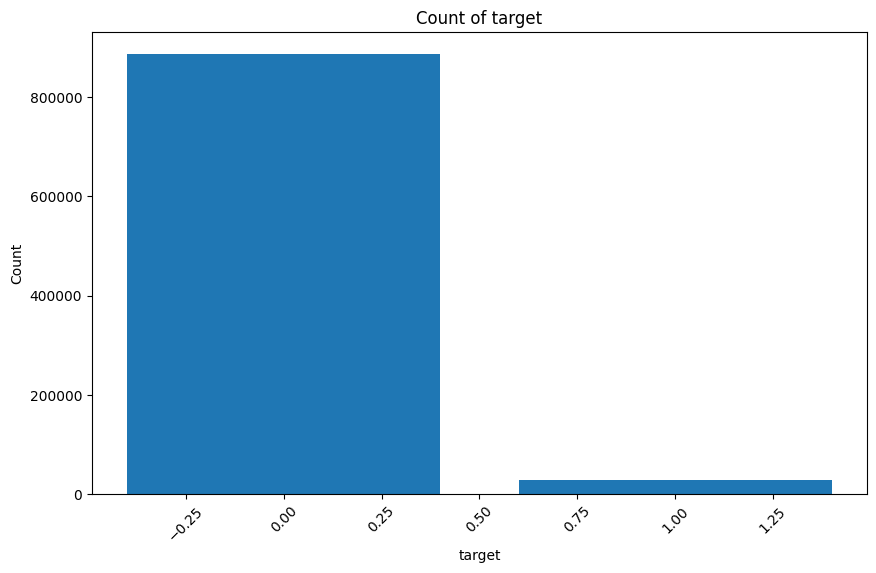

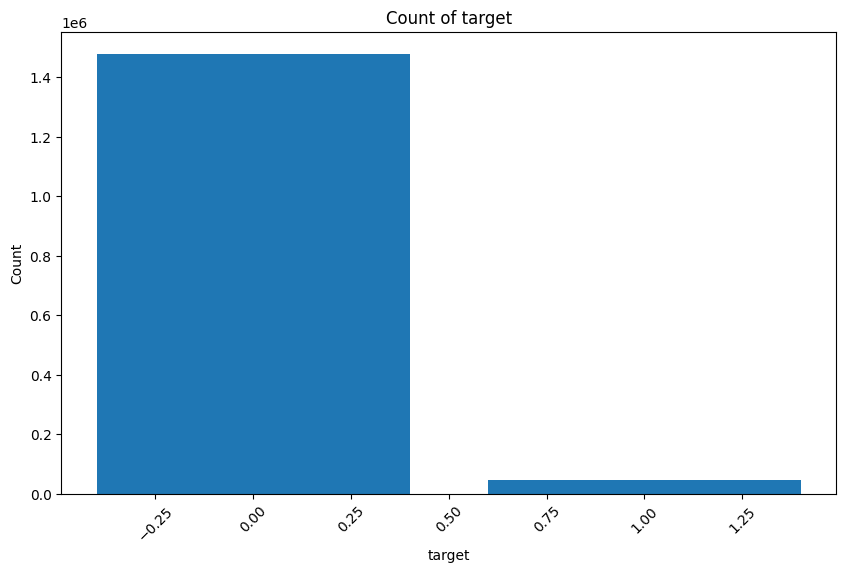

In [9]:
plot_count(base_train, ['target'])
plot_count(data_train_total, ['target'])


X_train shape: (915995, 48)
y_train shape: (915995,)


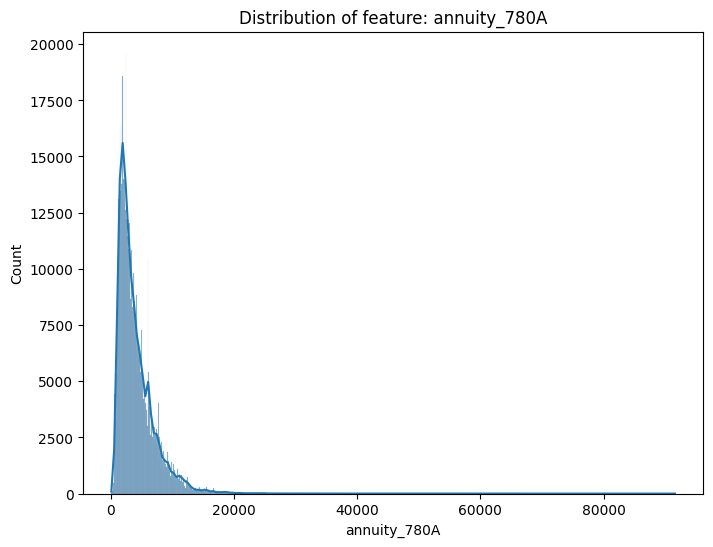

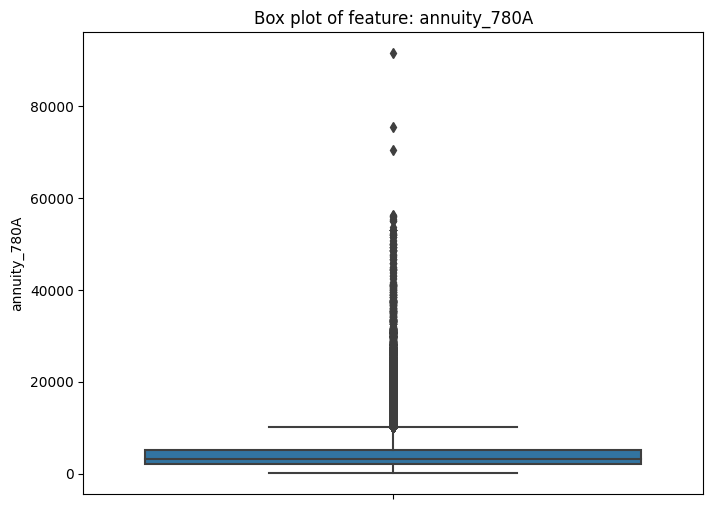

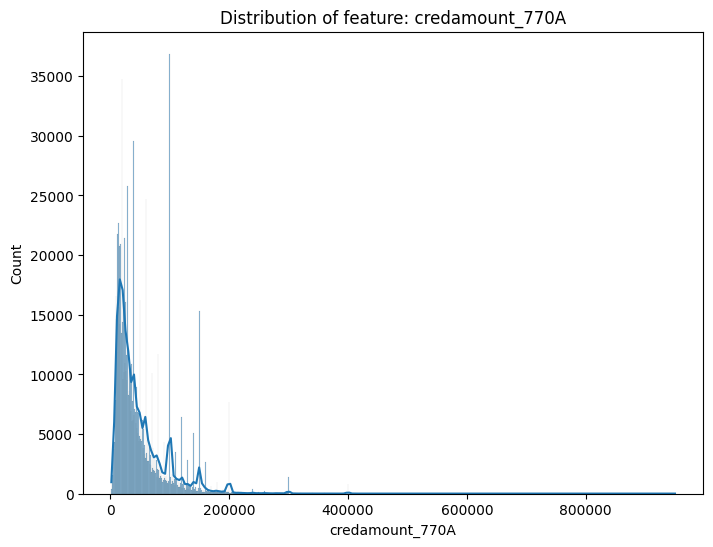

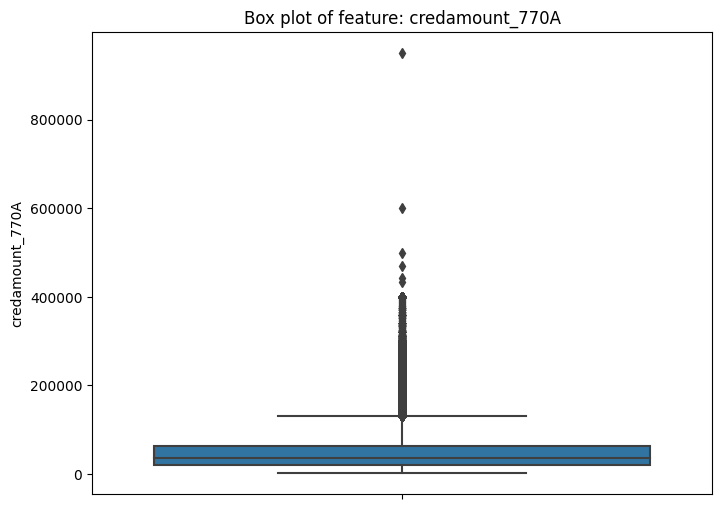

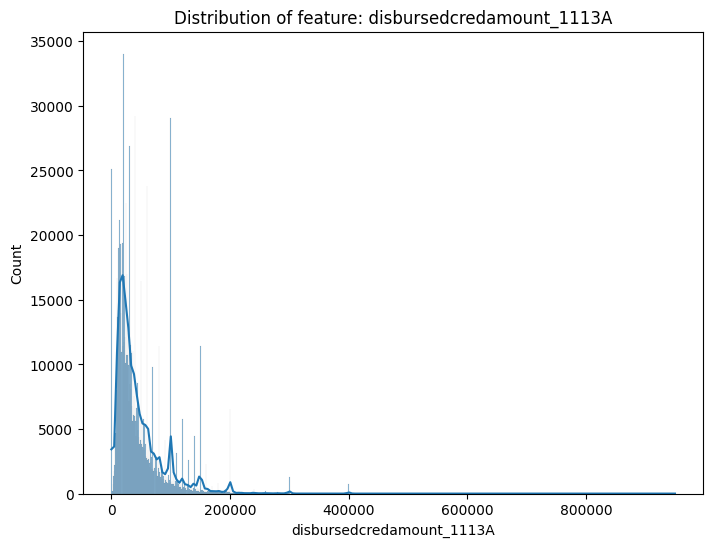

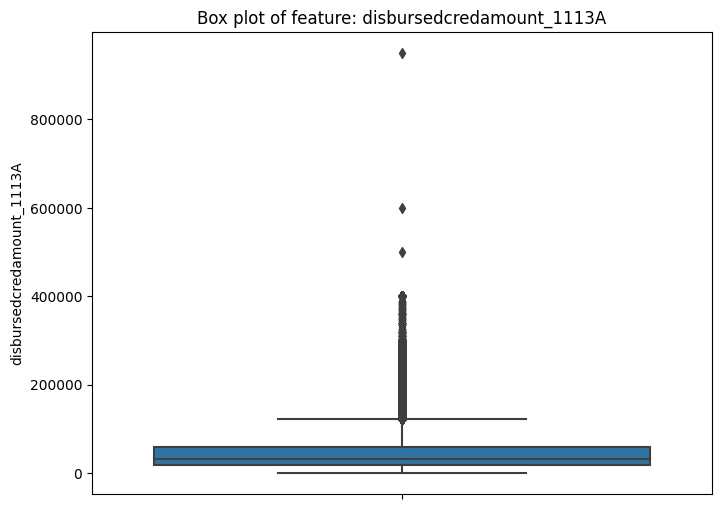

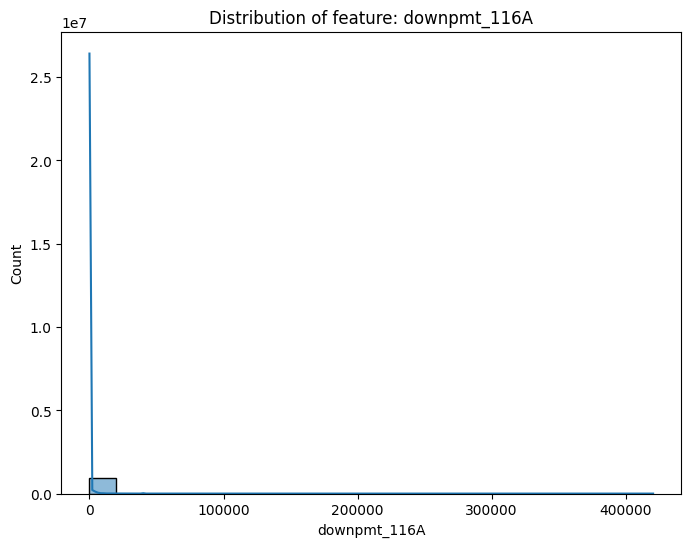

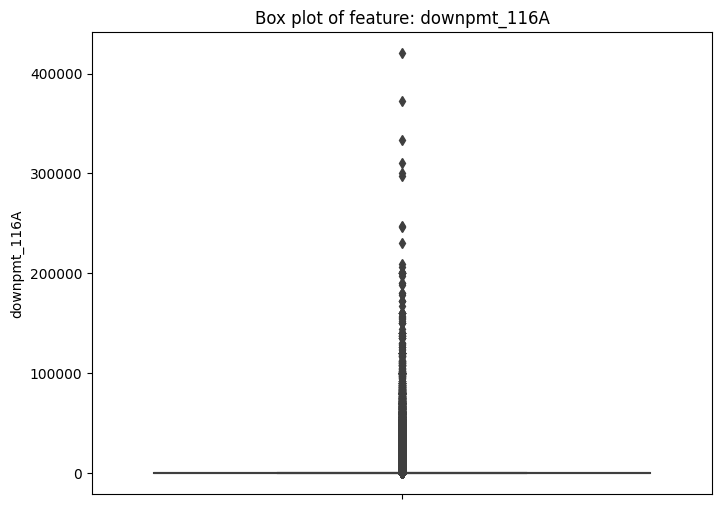

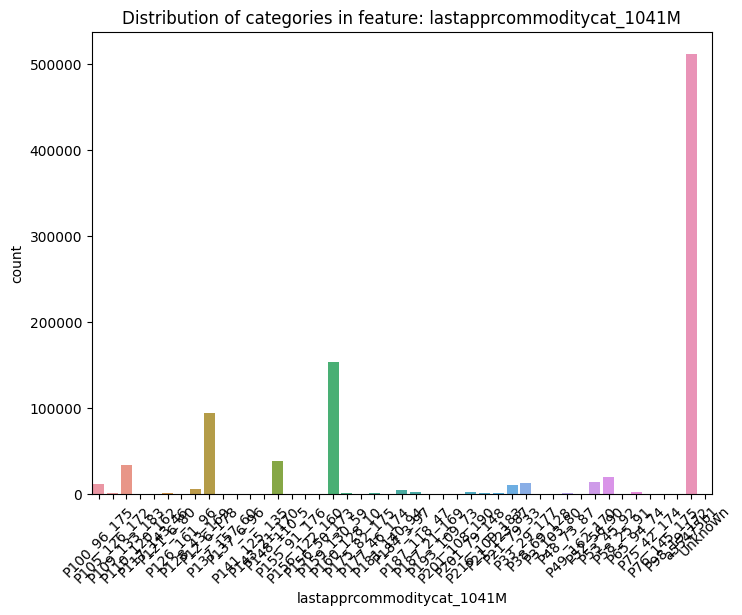

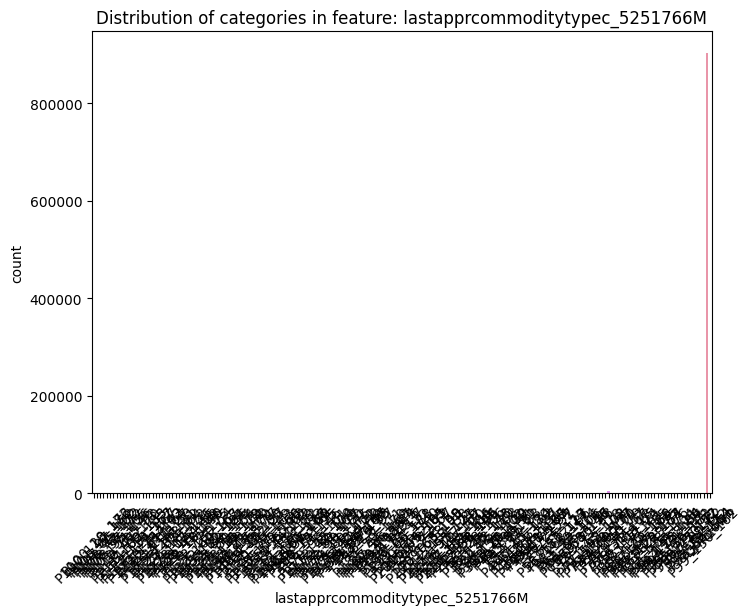

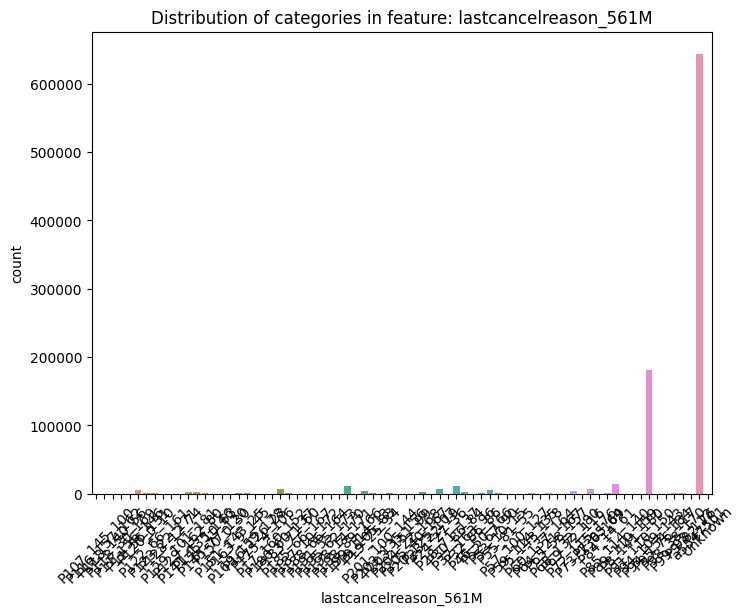

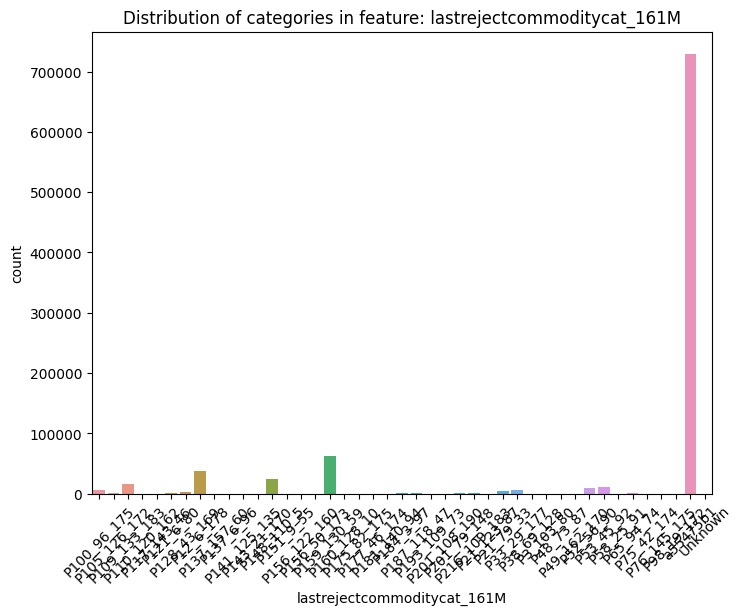

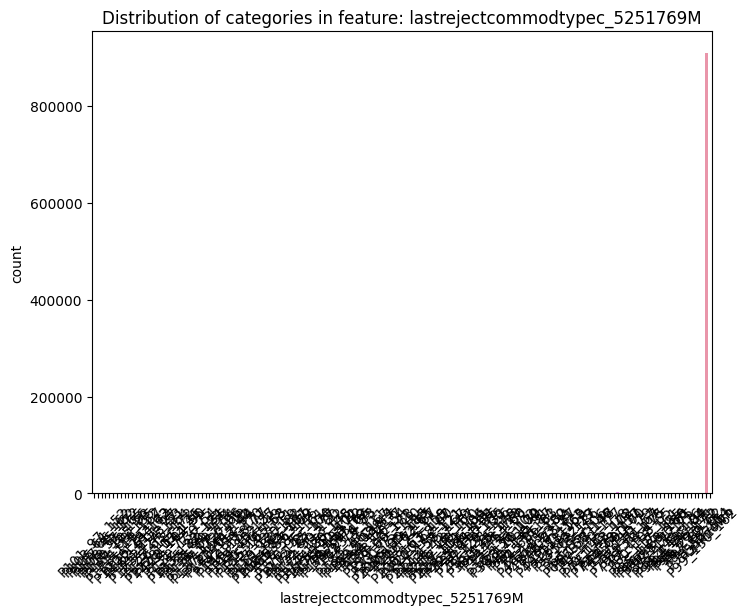

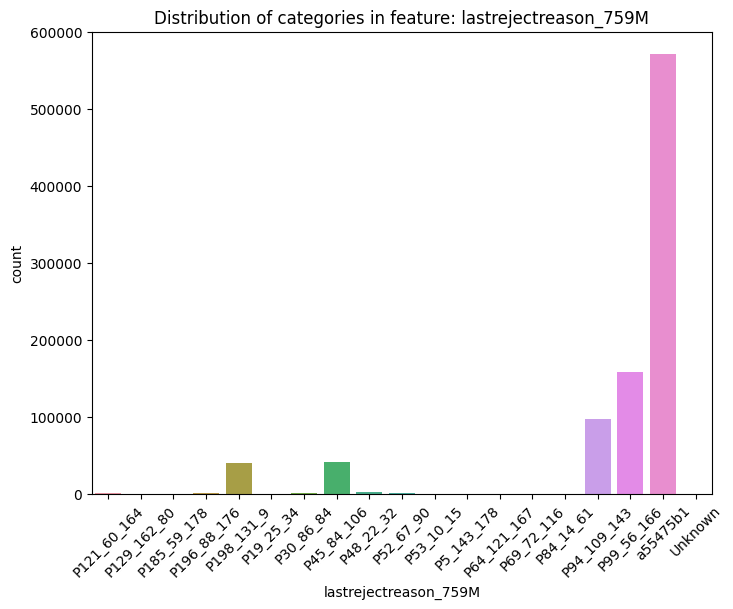

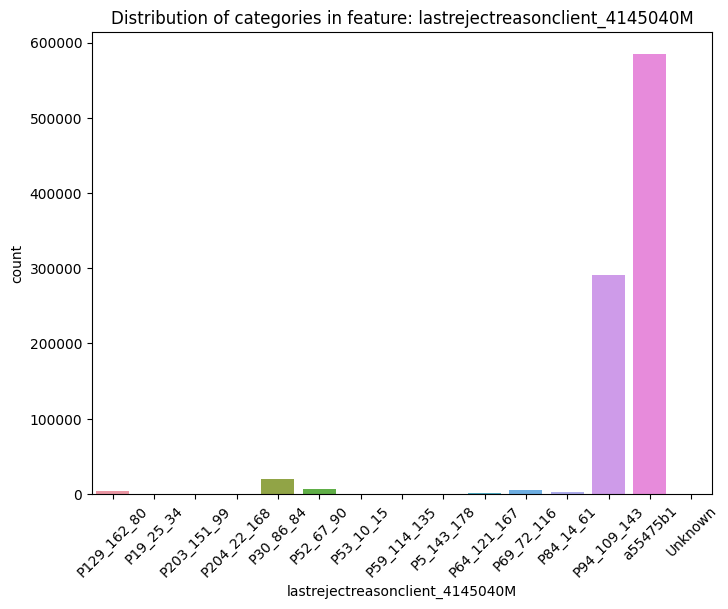

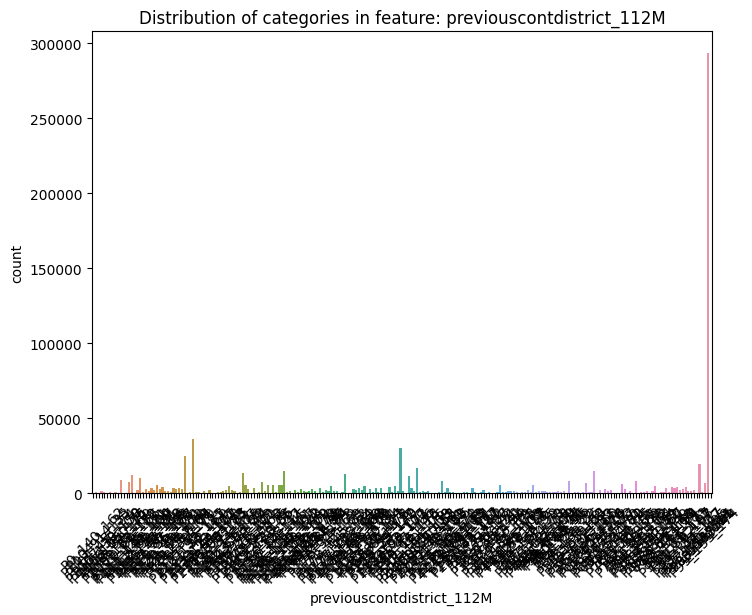

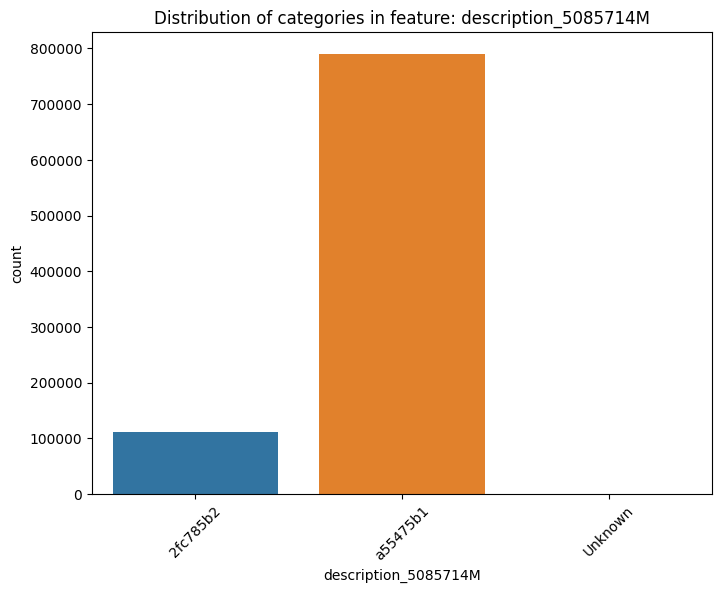

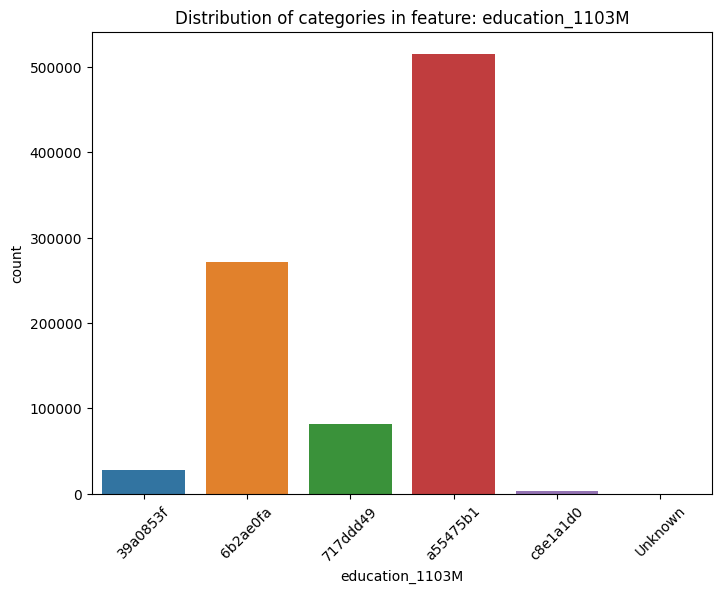

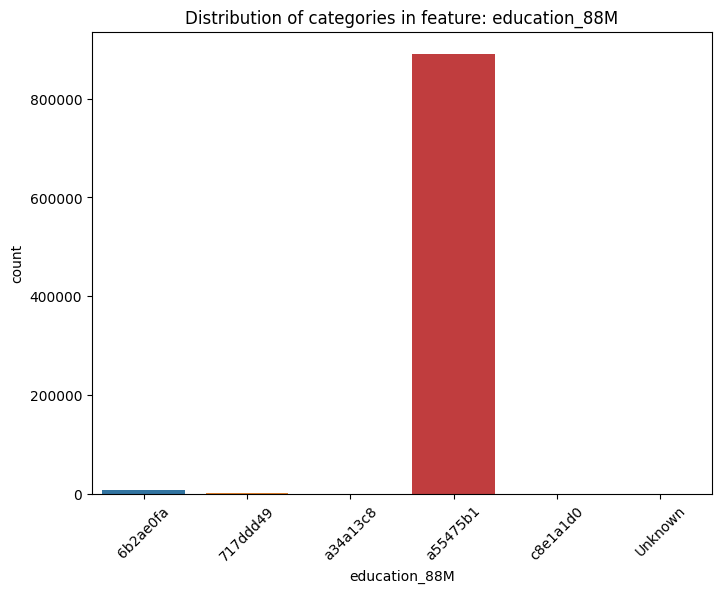

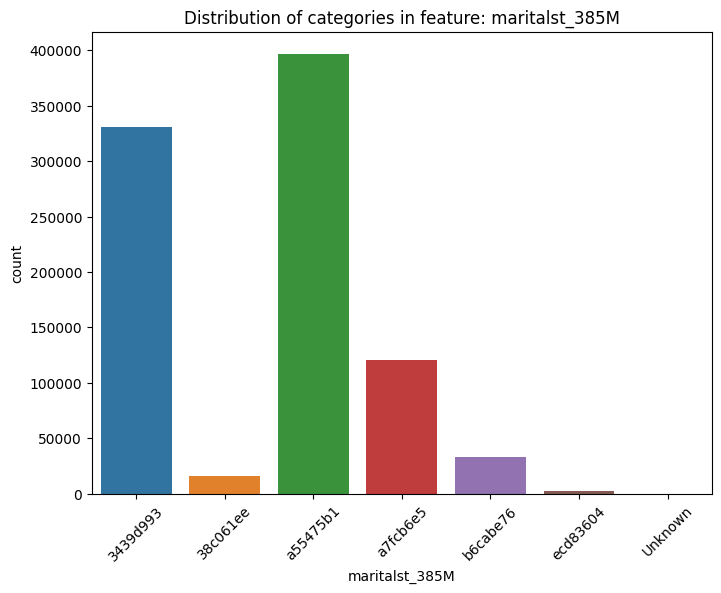

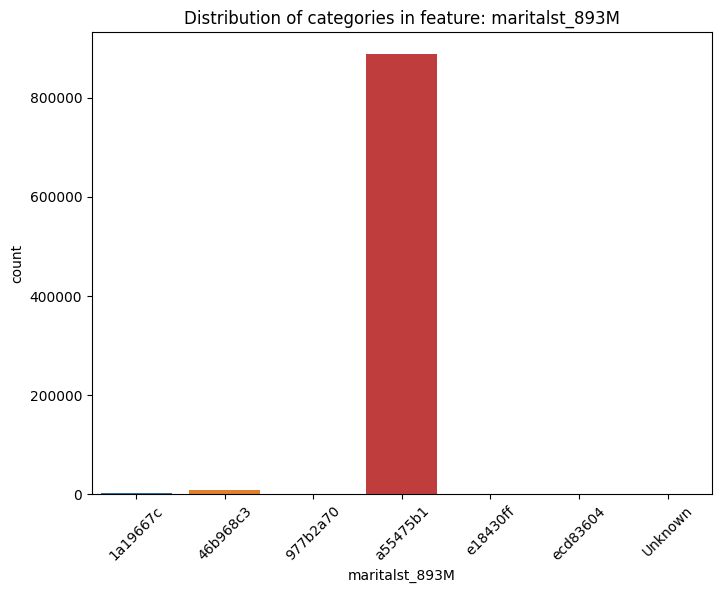

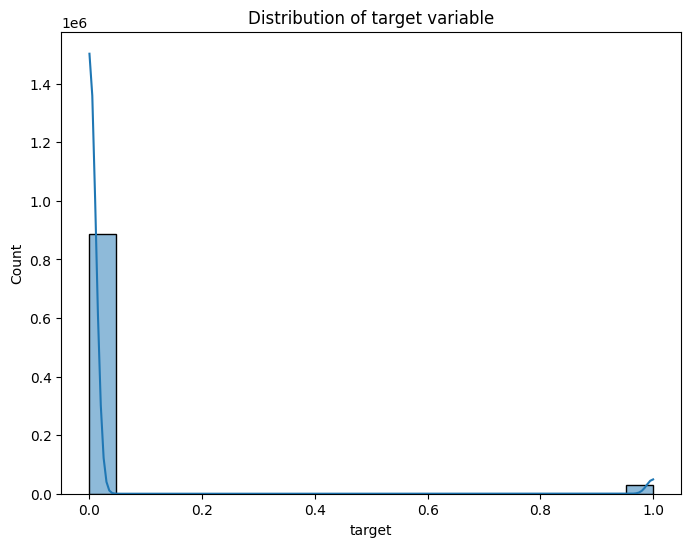

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Inspect shapes of X_train and y_train
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Numerical feature visualizations (adapt based on features)
for col in X_train.select_dtypes(include=['int64', 'float64']):
    # Check for missing values
    if X_train[col].isna().any():
        print(f"Warning: Feature {col} has missing values. Consider imputation.")

        continue

    # Histogram for distribution and outliers
    plt.figure(figsize=(8, 6))
    sns.histplot(data=X_train, x=col, kde=True)
    plt.title(f"Distribution of feature: {col}")
    plt.show()

    # Box plot for outliers
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=col, data=X_train)
    plt.title(f"Box plot of feature: {col}")
    plt.show()

# Categorical feature visualizations (adapt based on your features)
for col in X_train.select_dtypes(include=['category']):
    # Count or bar plot for category distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(x=col, data=X_train)
    plt.title(f"Distribution of categories in feature: {col}")
    plt.xticks(rotation=45)
    plt.show()

# Target variable visualization
plt.figure(figsize=(8, 6))
sns.histplot(data=y_train, kde=True)
plt.title("Distribution of target variable")
plt.show()

# Further considerations:
# - Investigate relationships between features using scatter matrices or pair plots.
# - Create feature importance plots if you have trained a model already.
# - Adjust plot configurations (e.g., colors, bin sizes) for better visualization.

Handling missing with mean (for now)

X_train shape: (915995, 48)
y_train shape: (915995,)


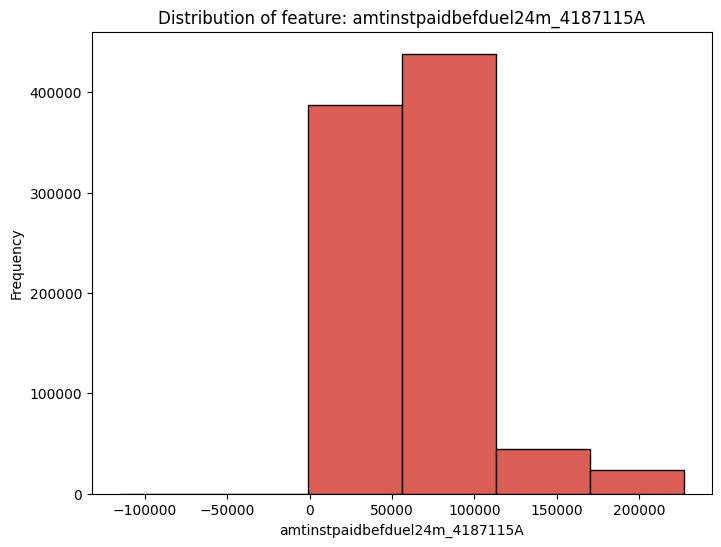

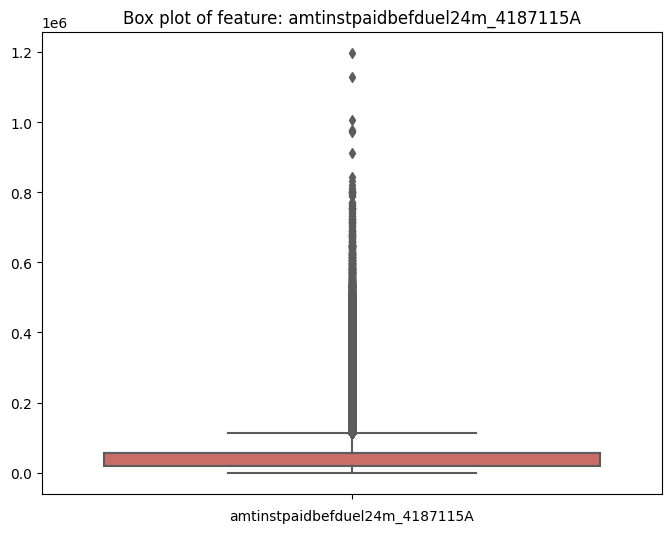

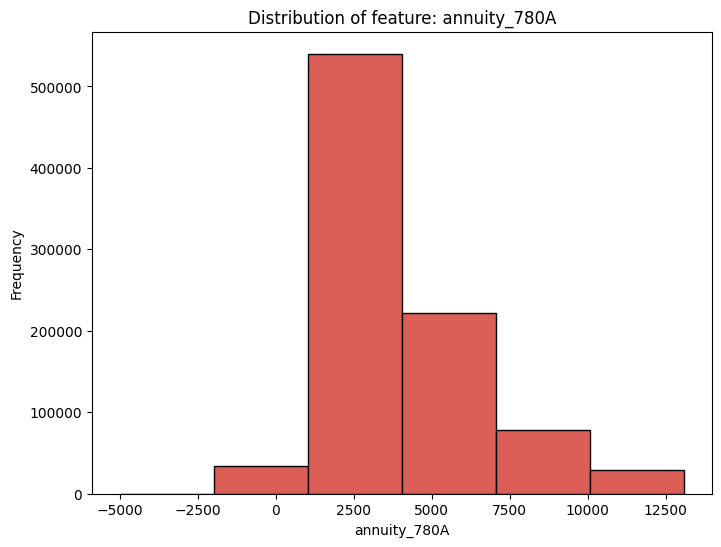

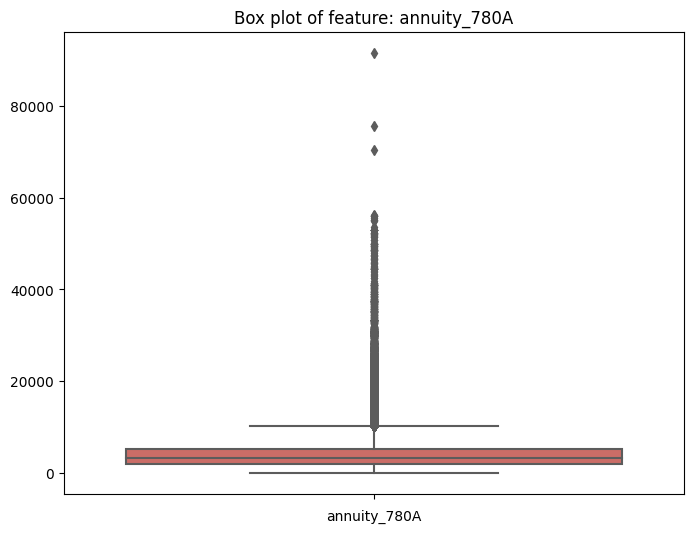

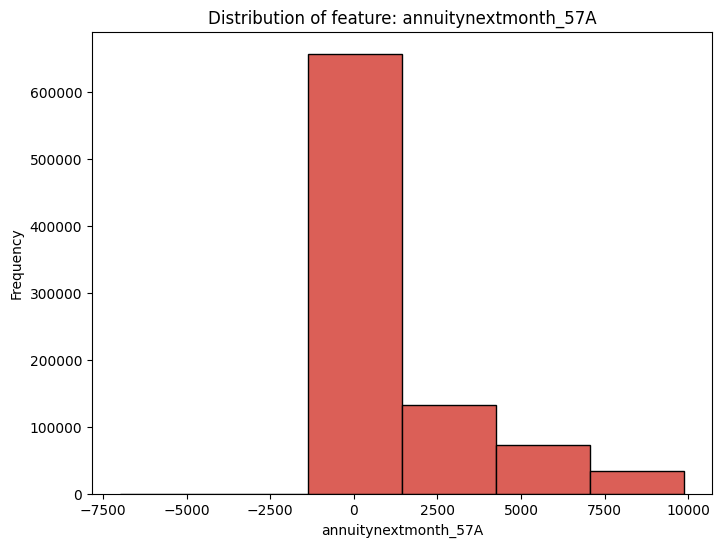

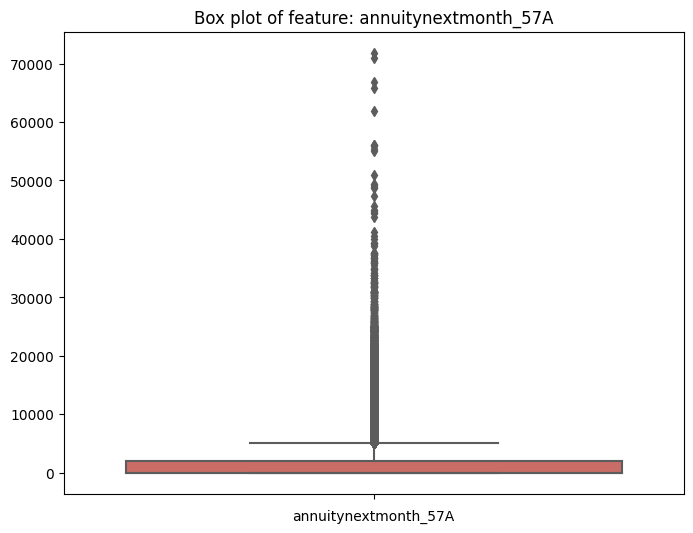

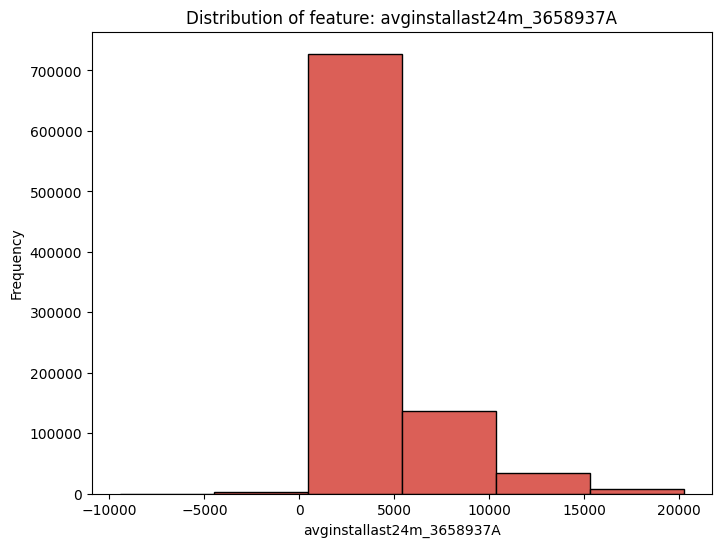

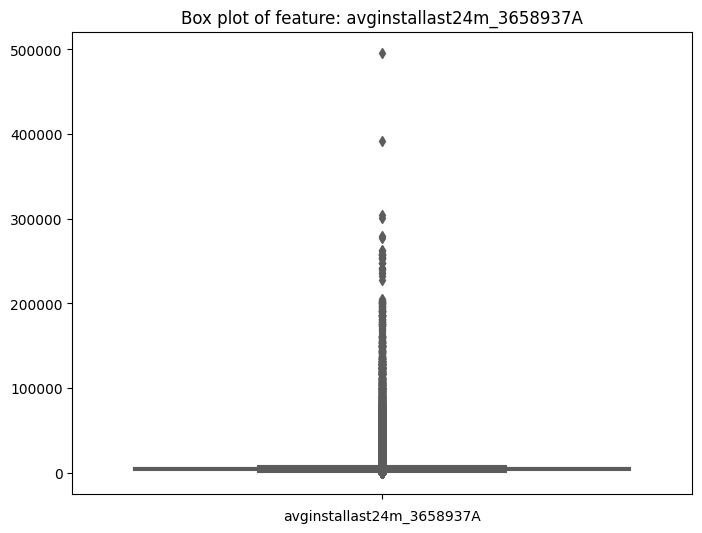

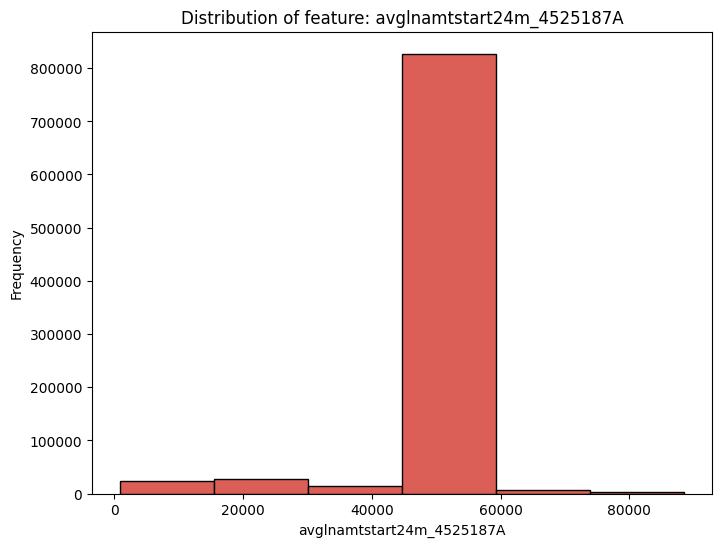

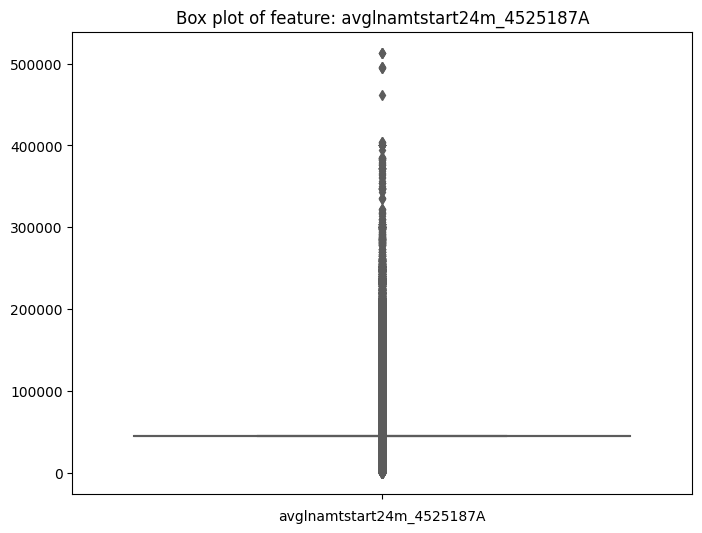

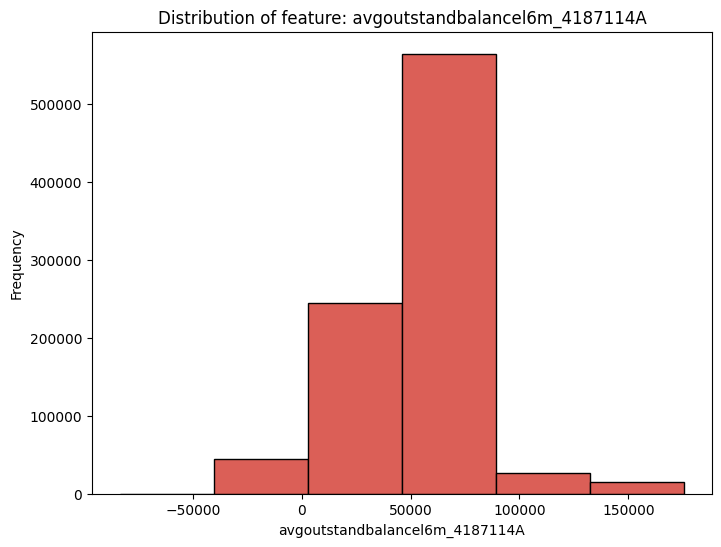

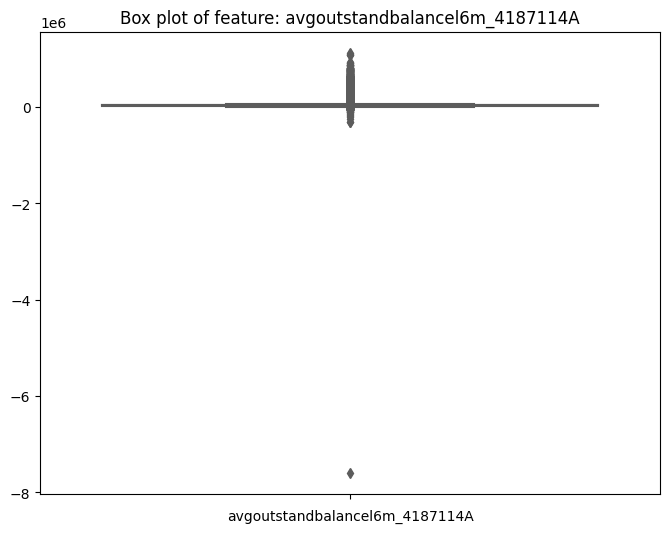

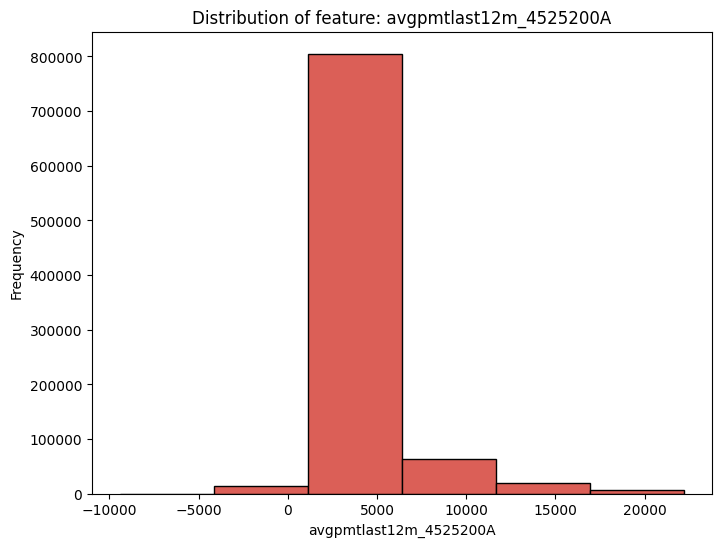

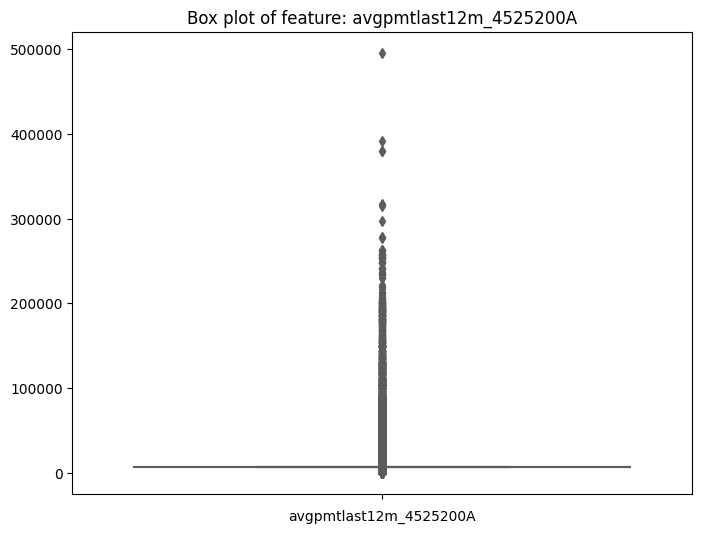

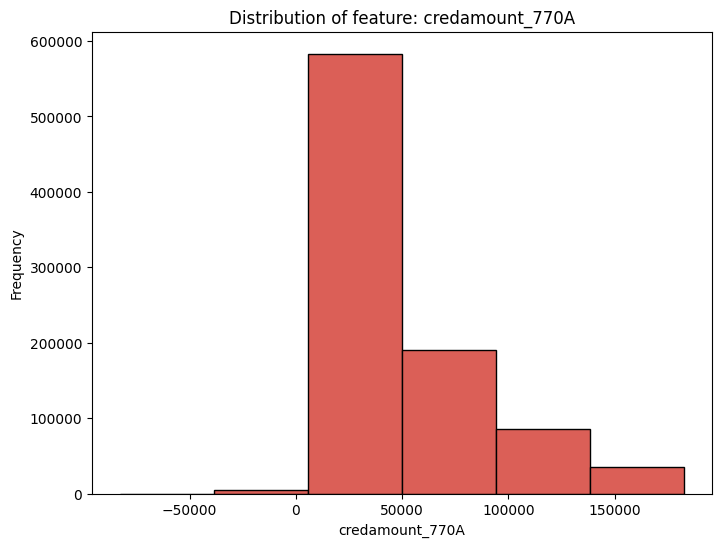

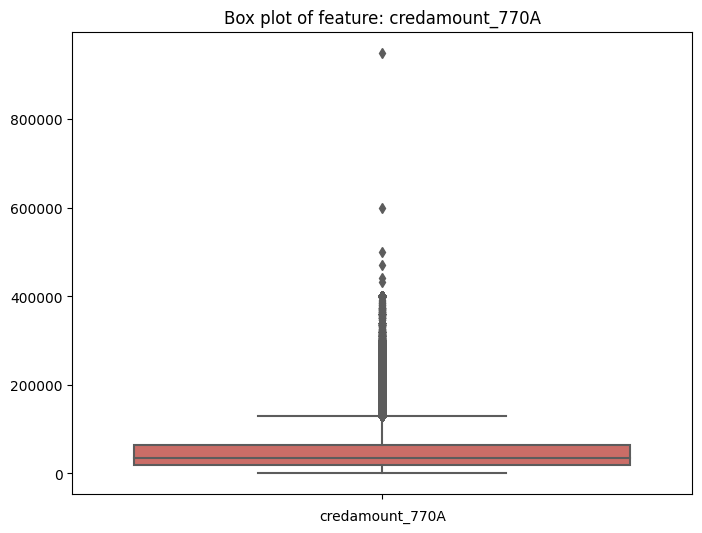

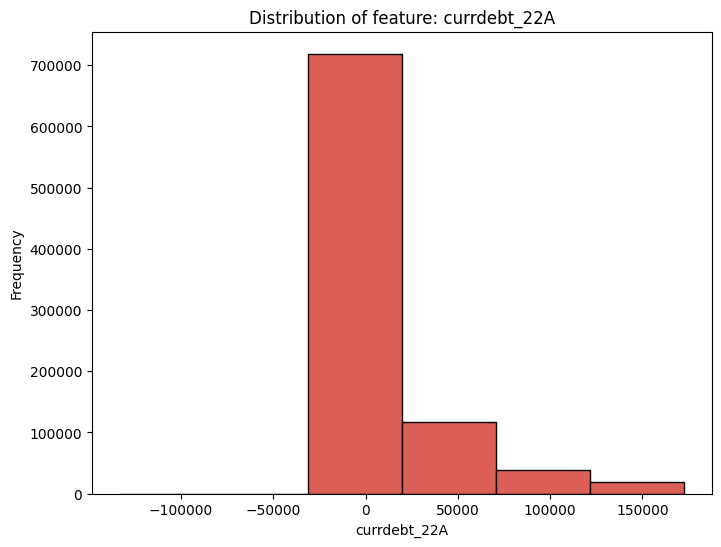

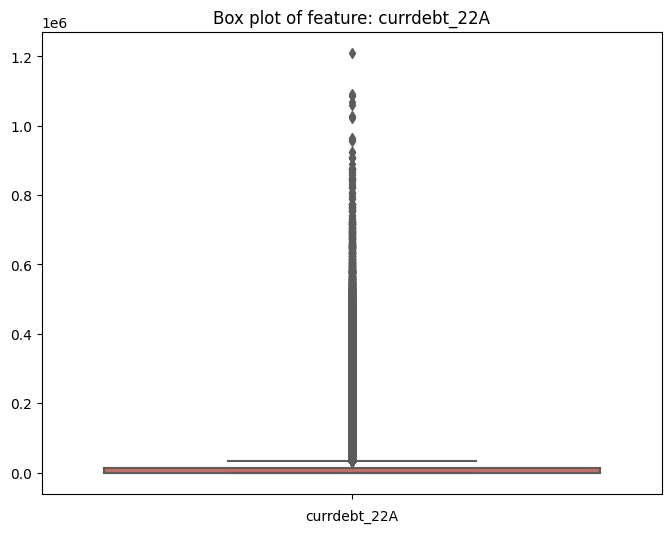

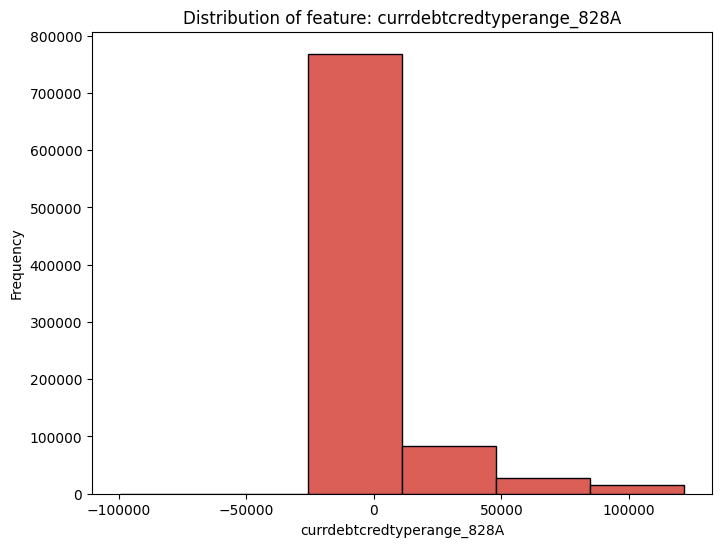

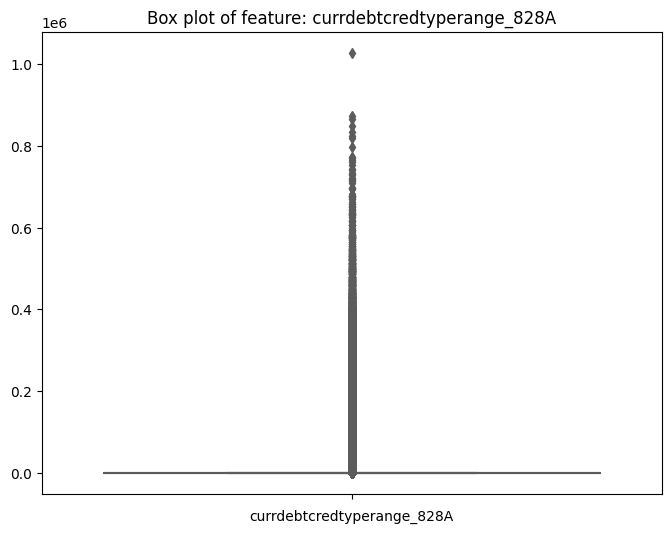

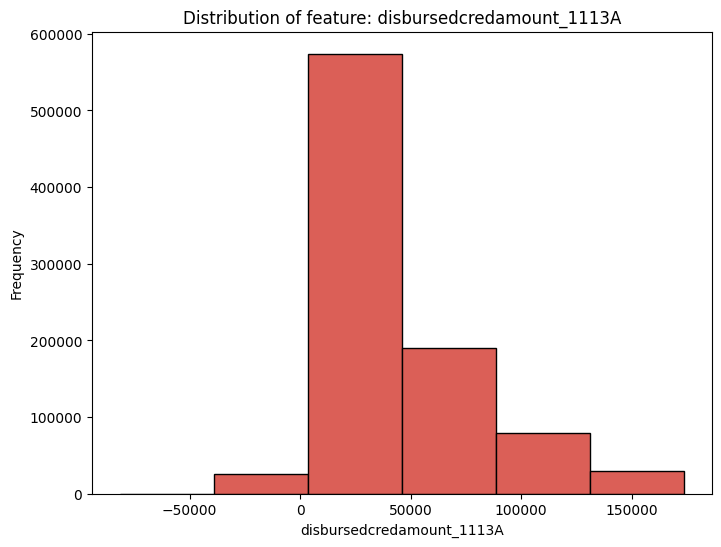

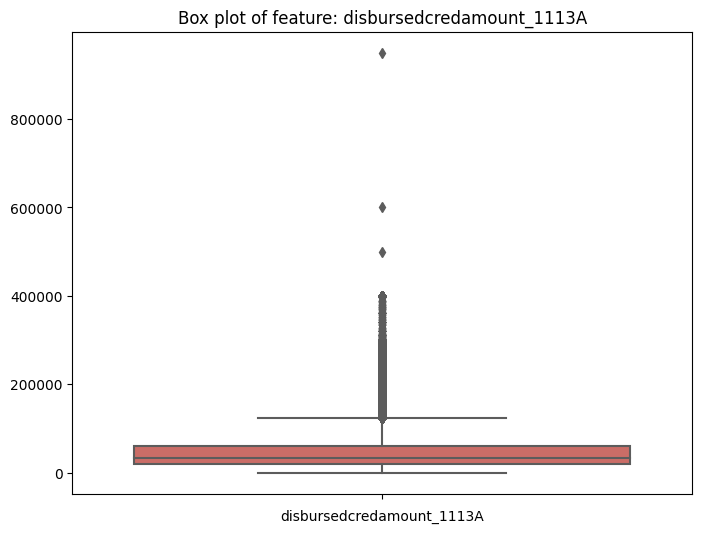

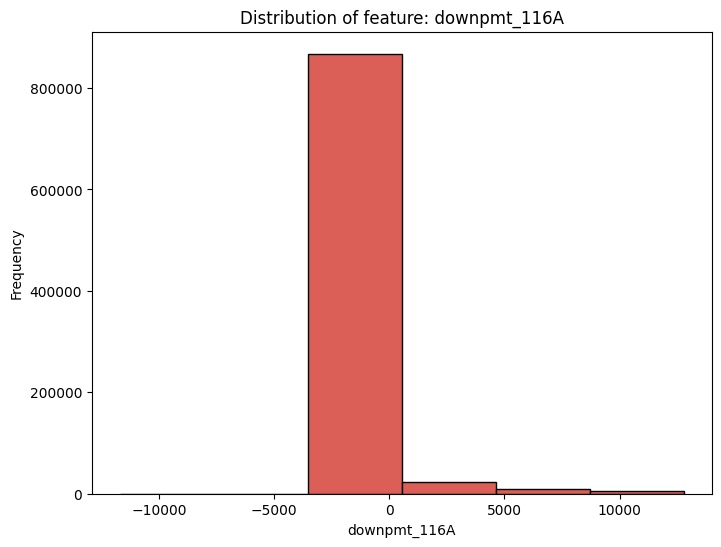

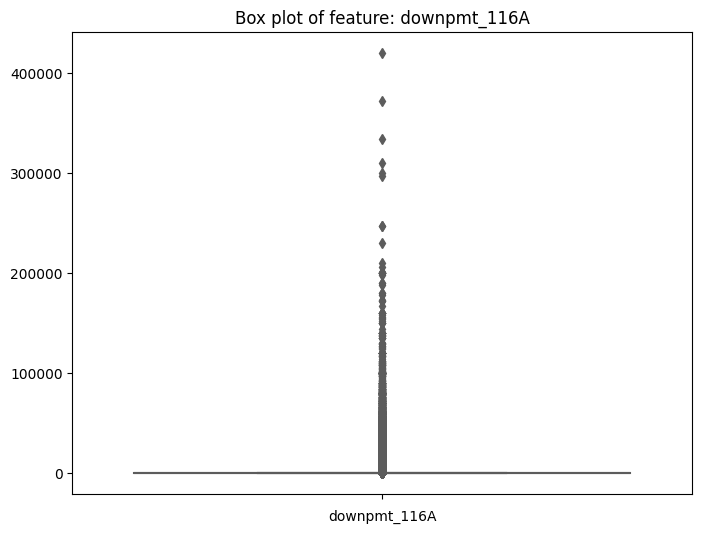

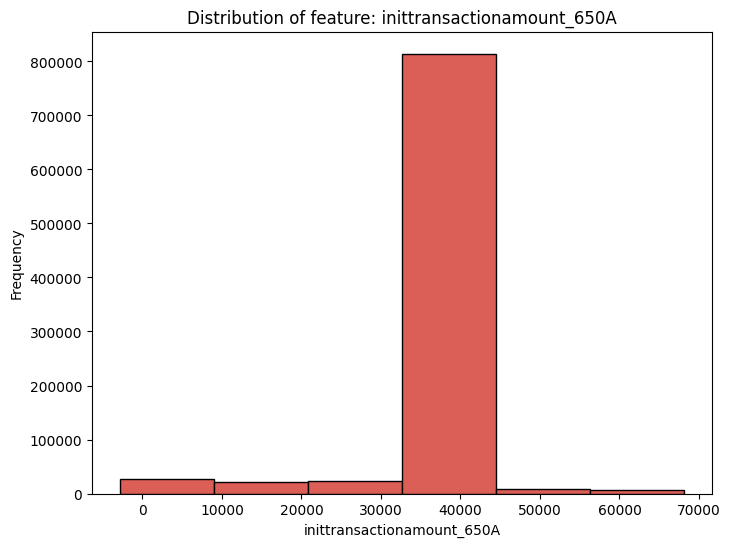

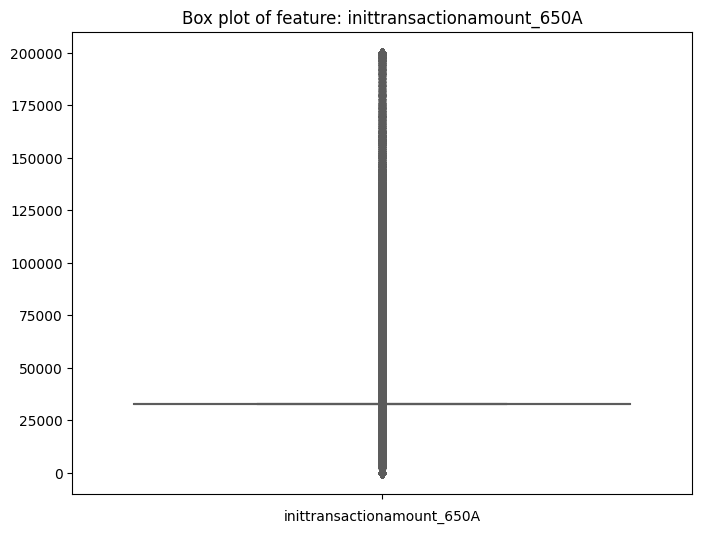

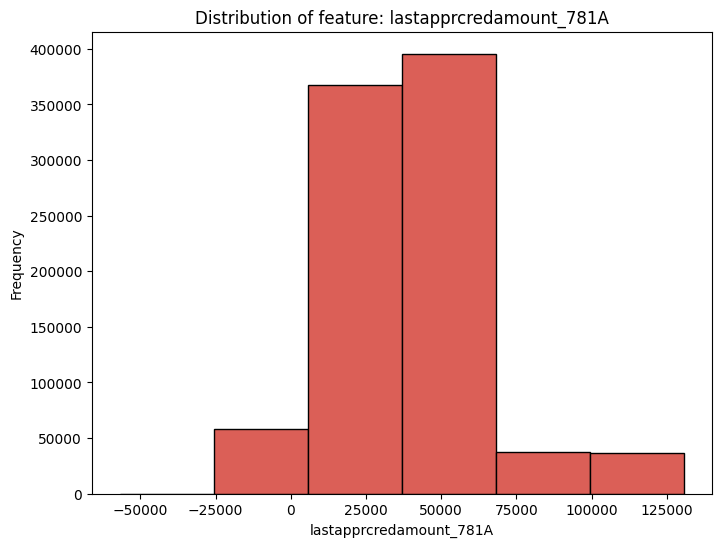

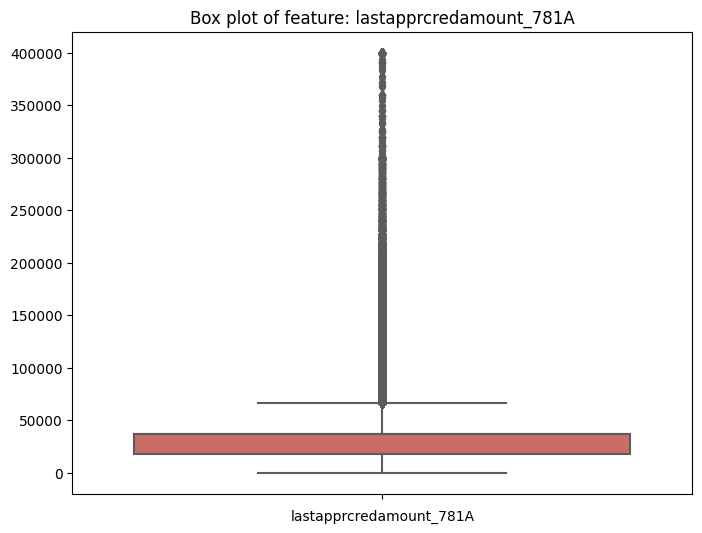

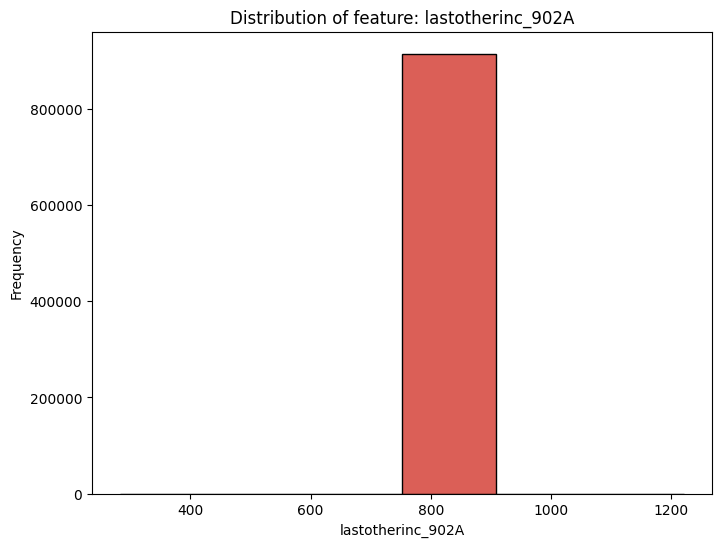

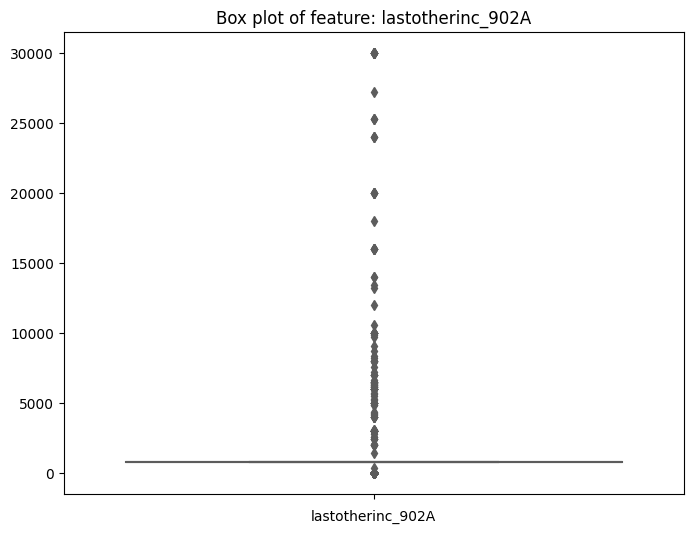

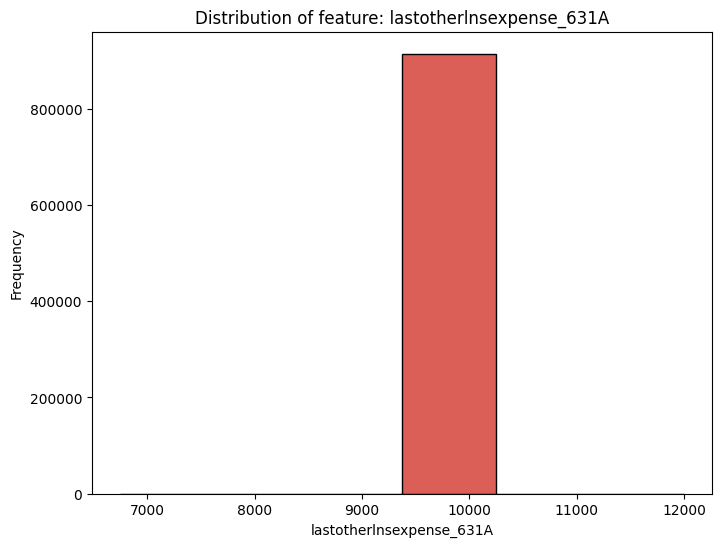

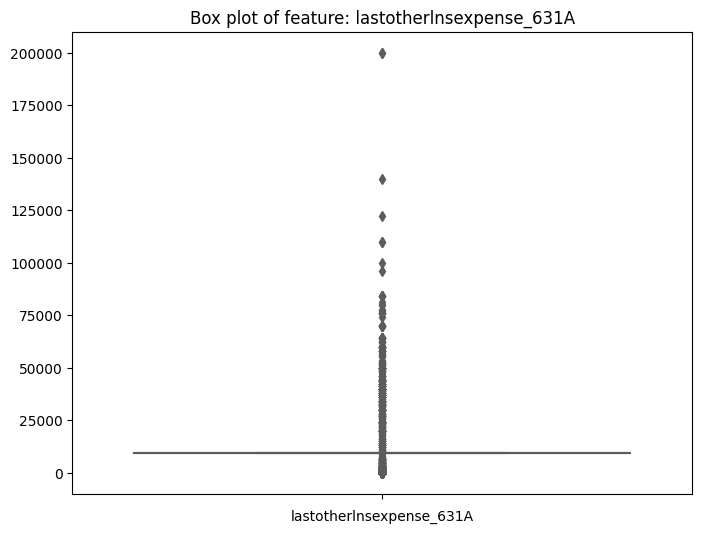

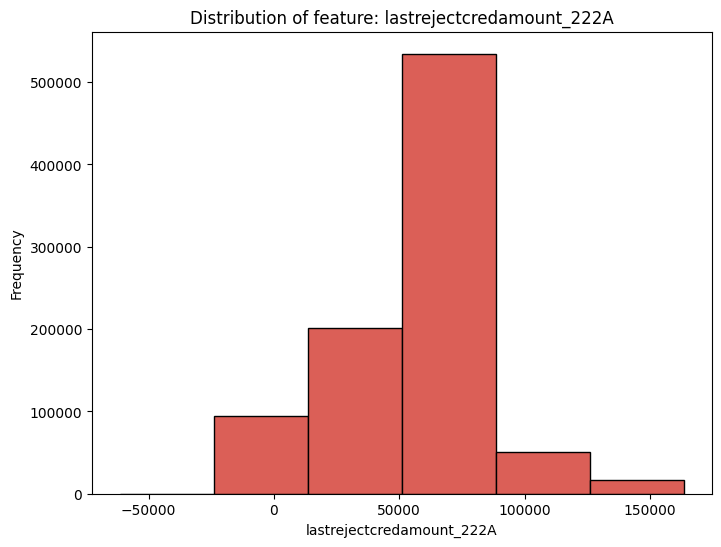

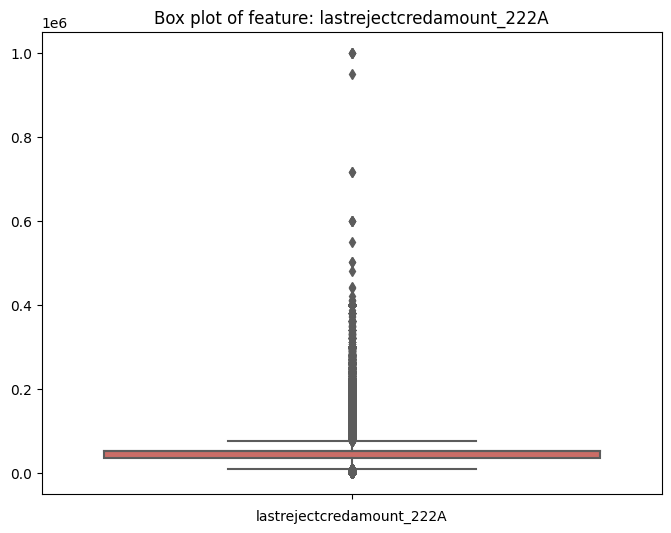

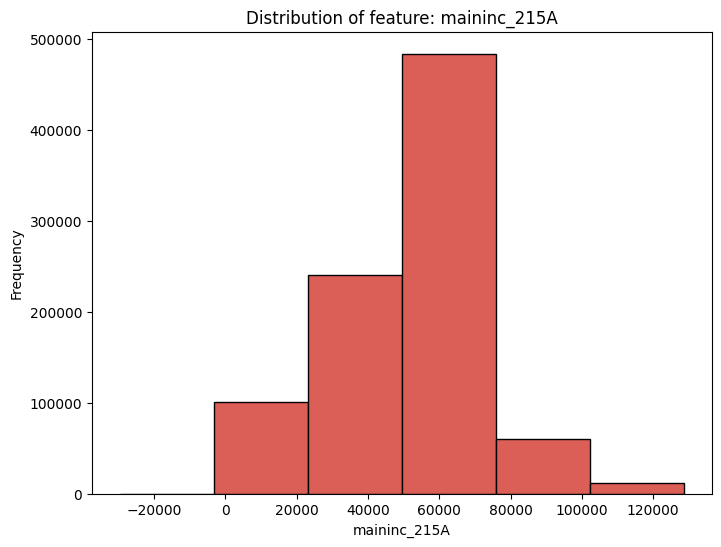

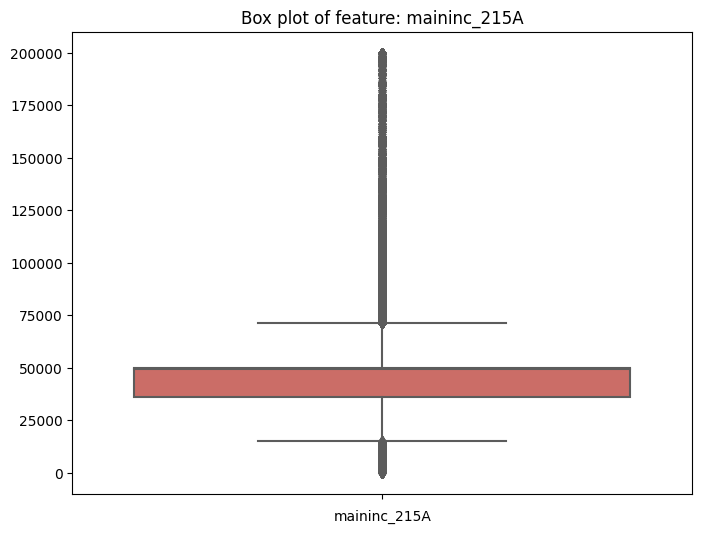

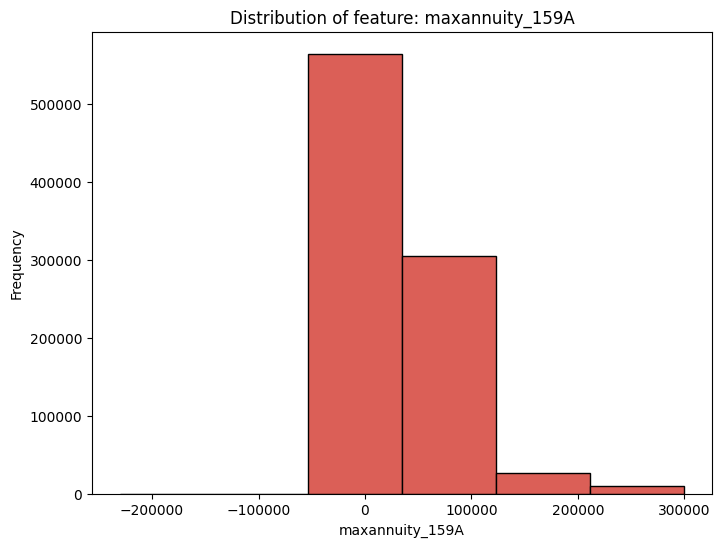

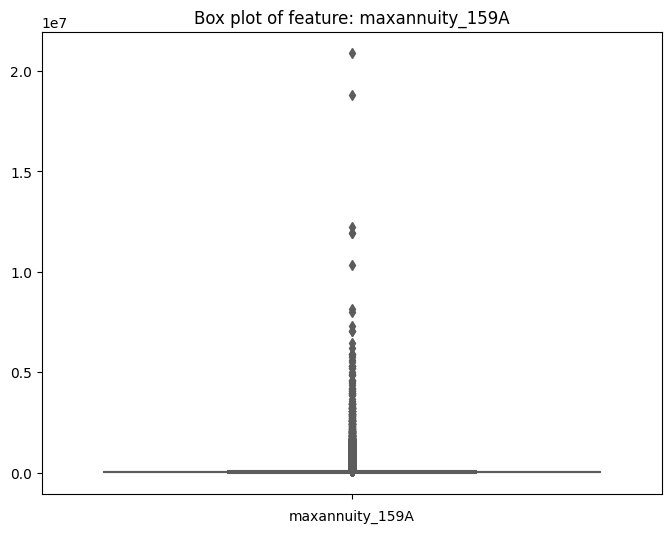

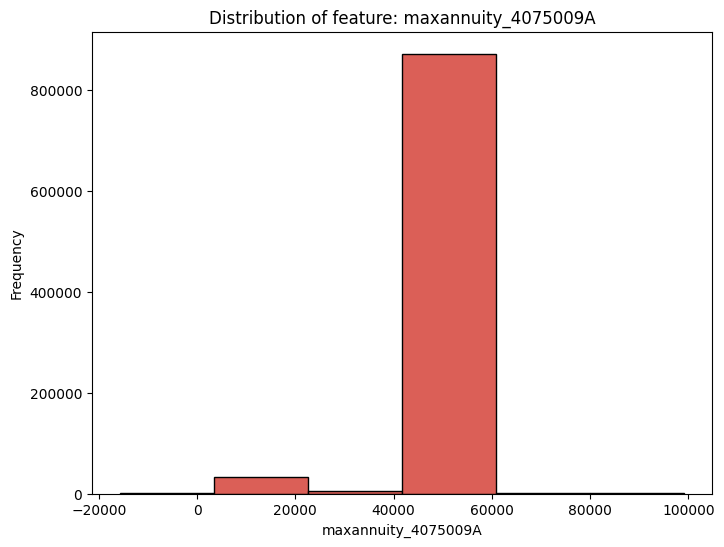

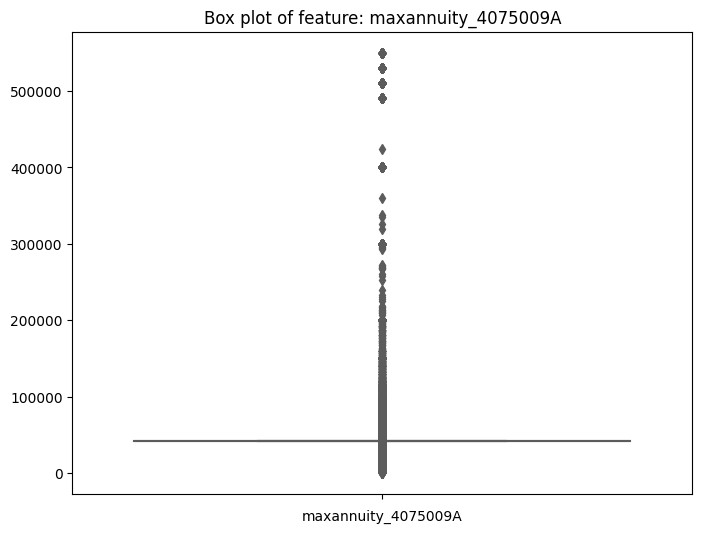

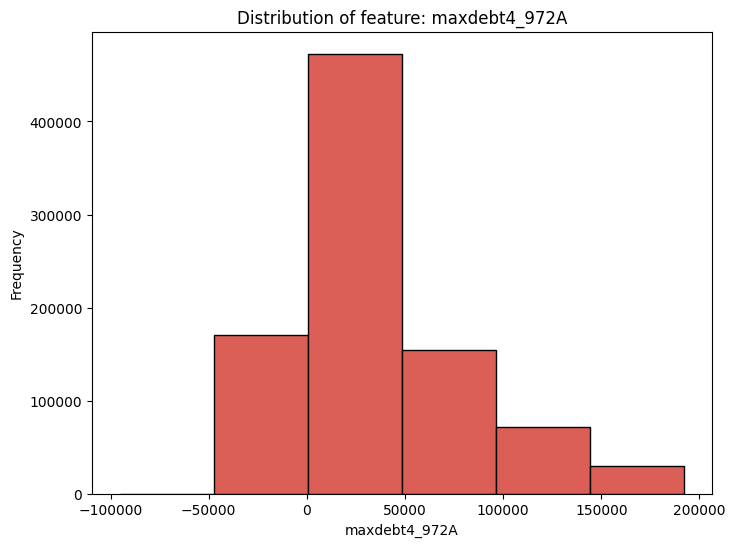

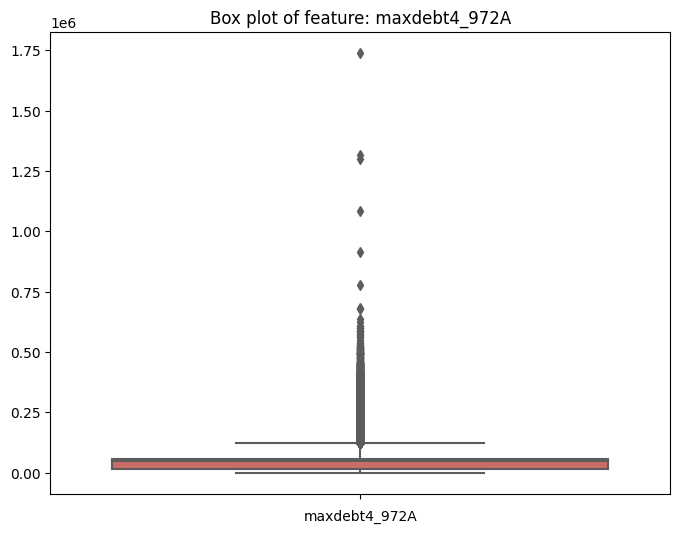

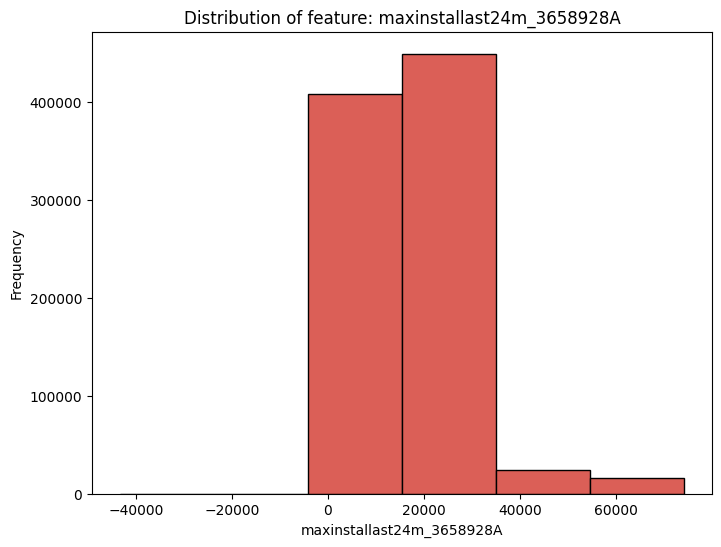

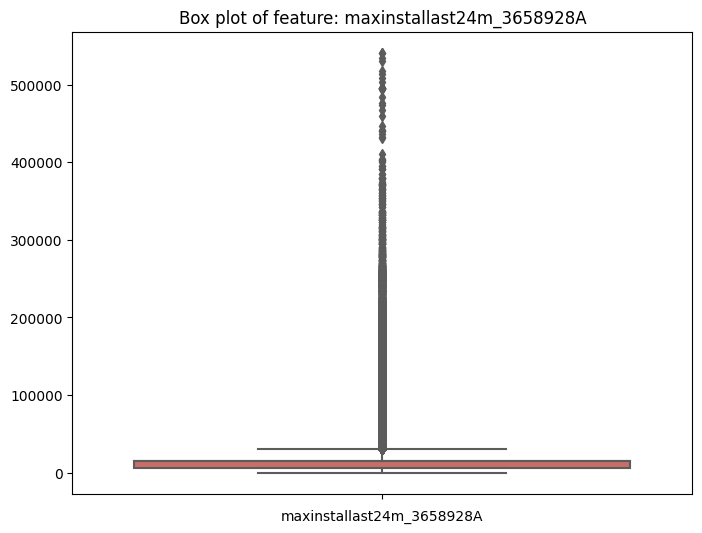

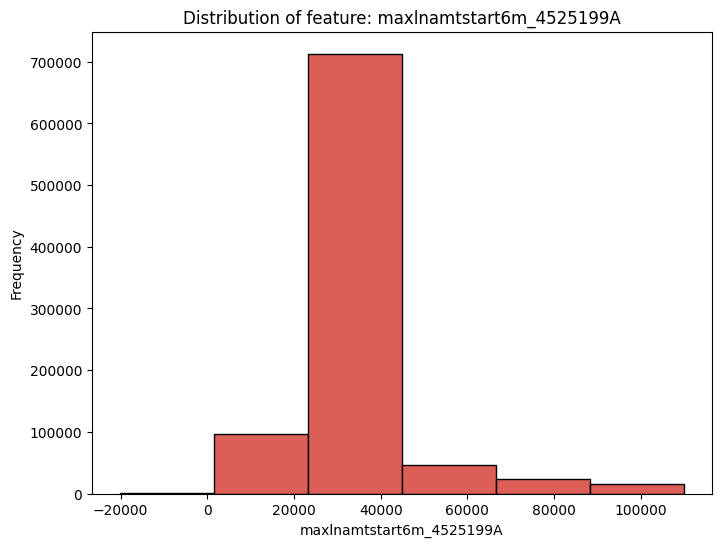

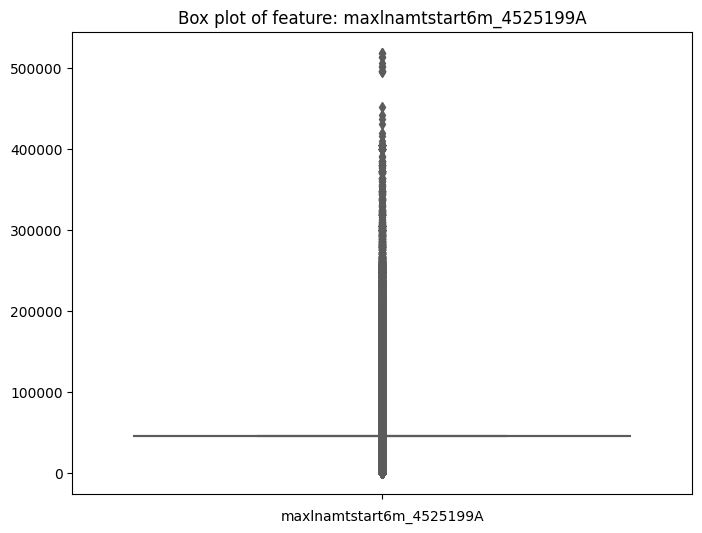

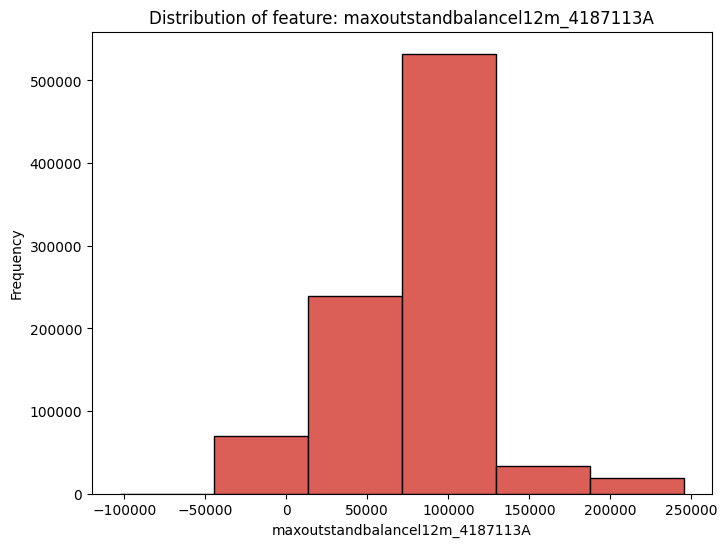

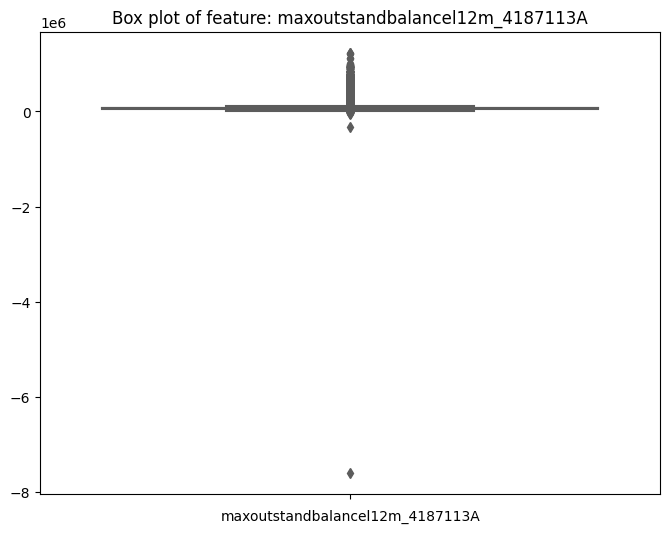

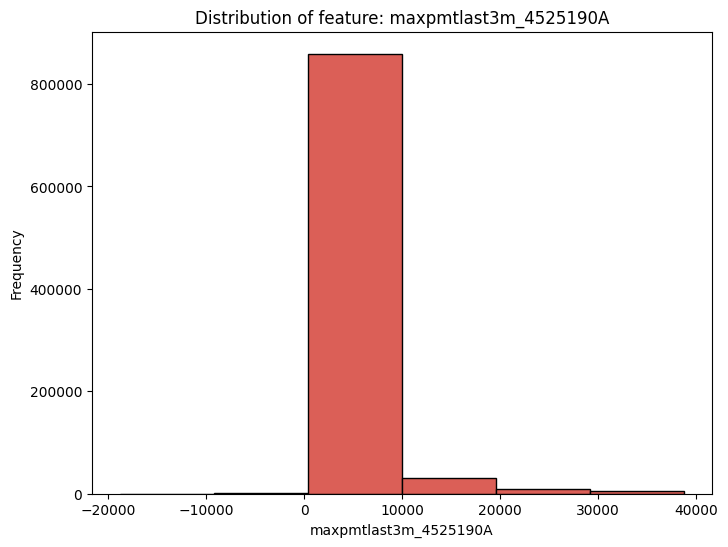

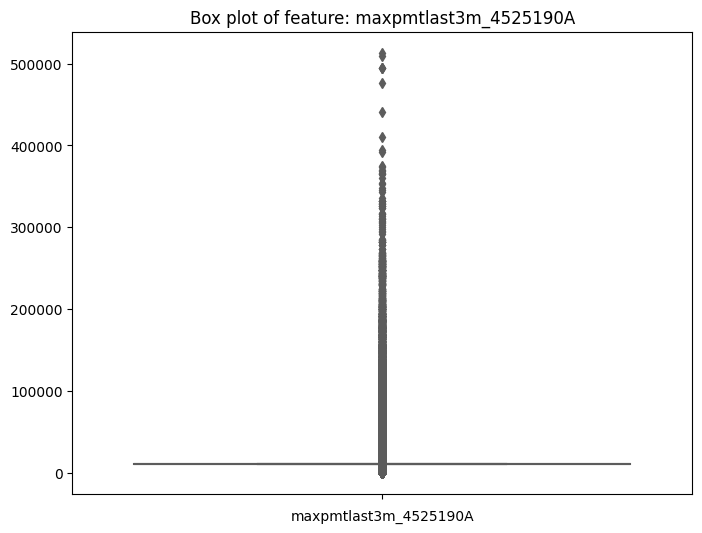

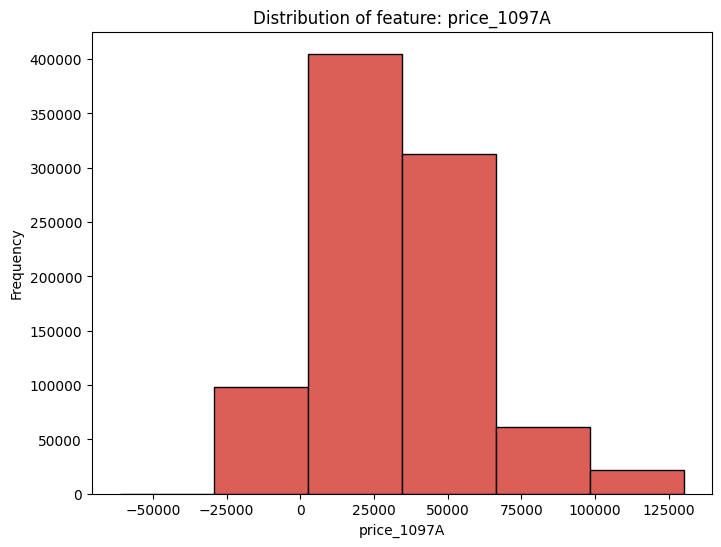

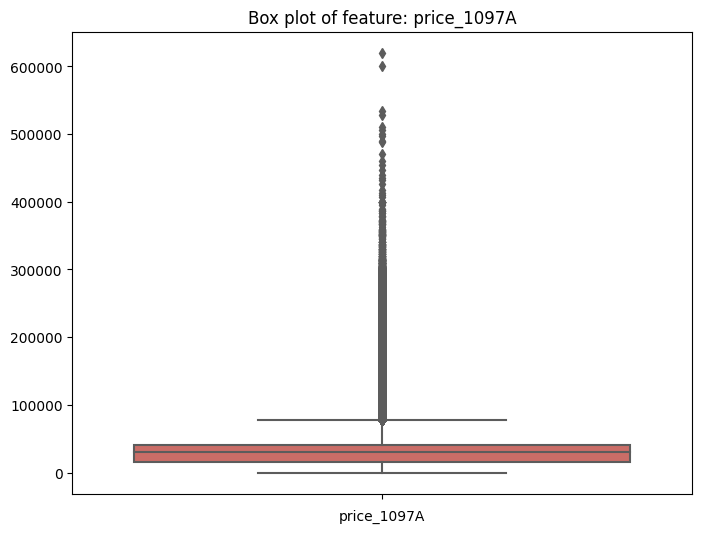

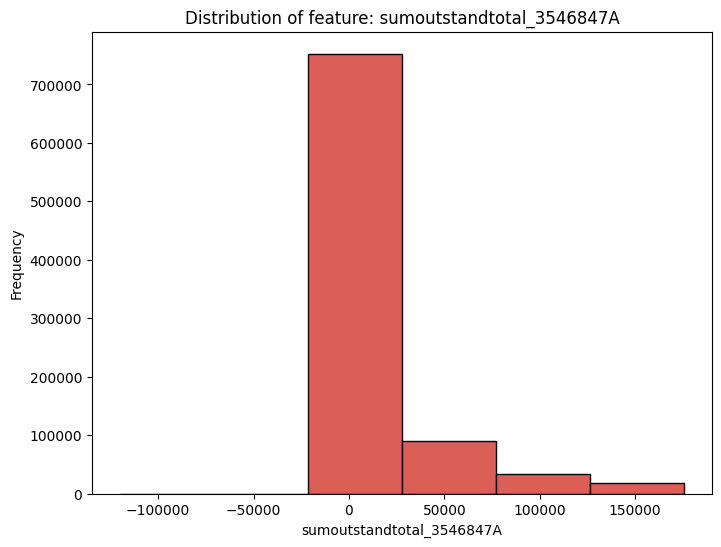

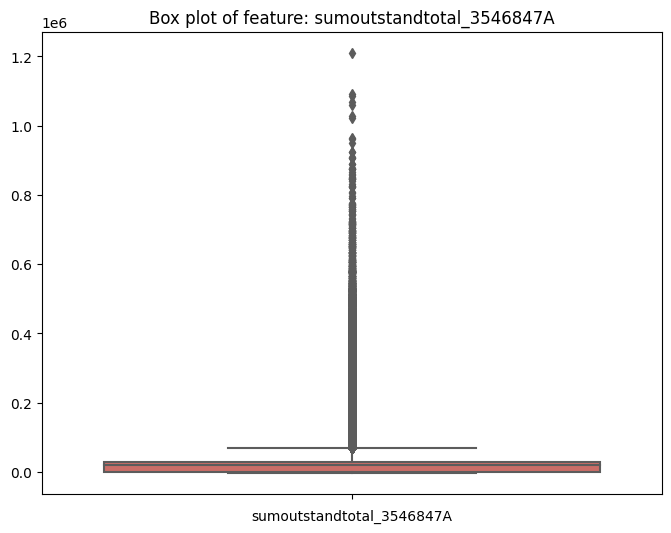

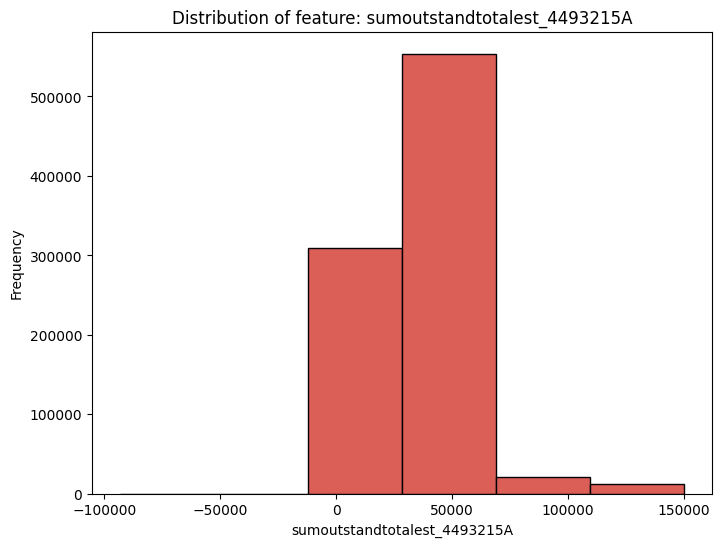

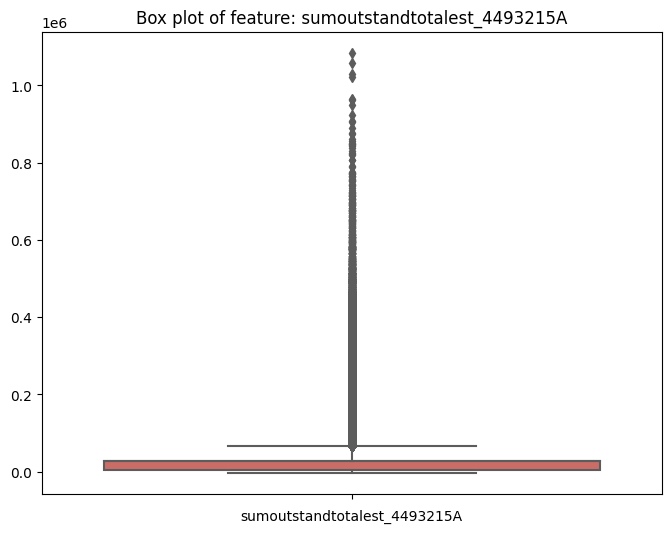

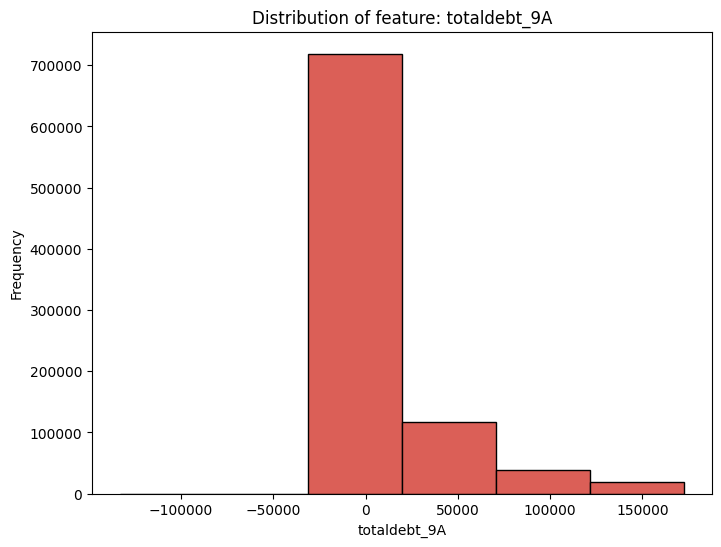

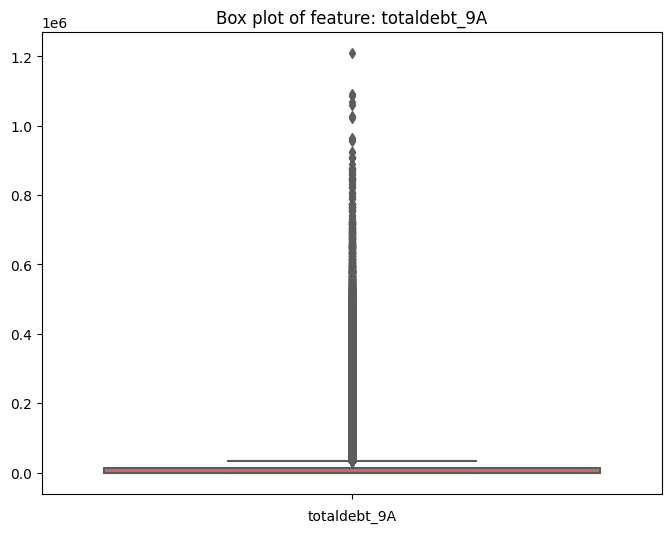

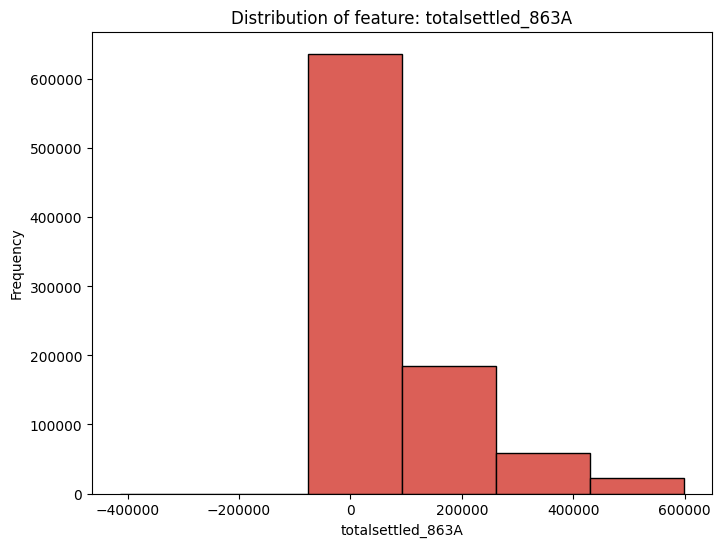

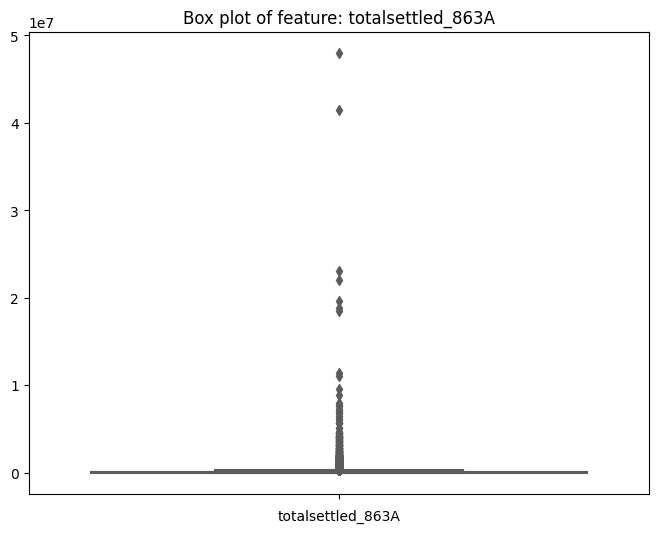

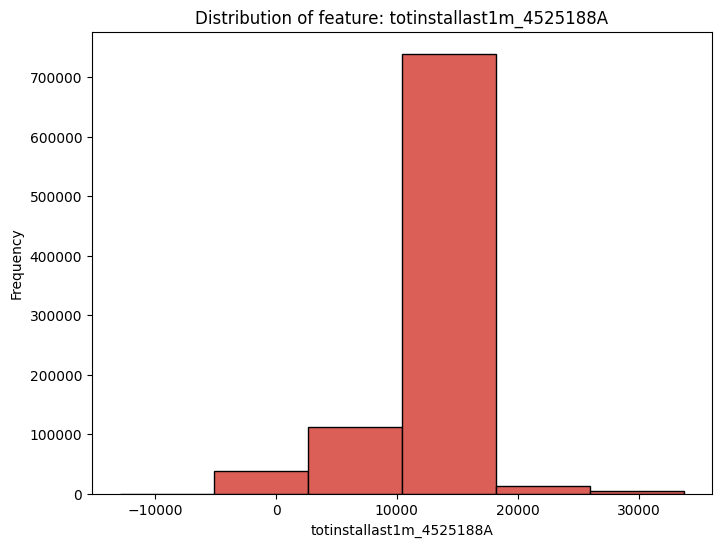

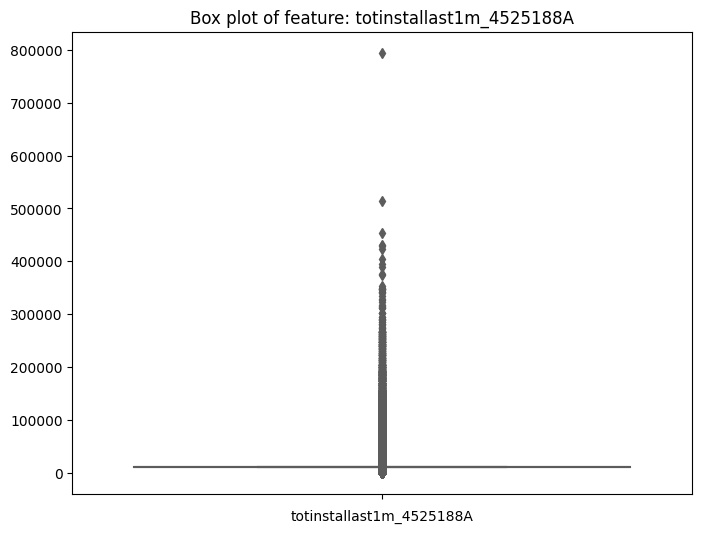

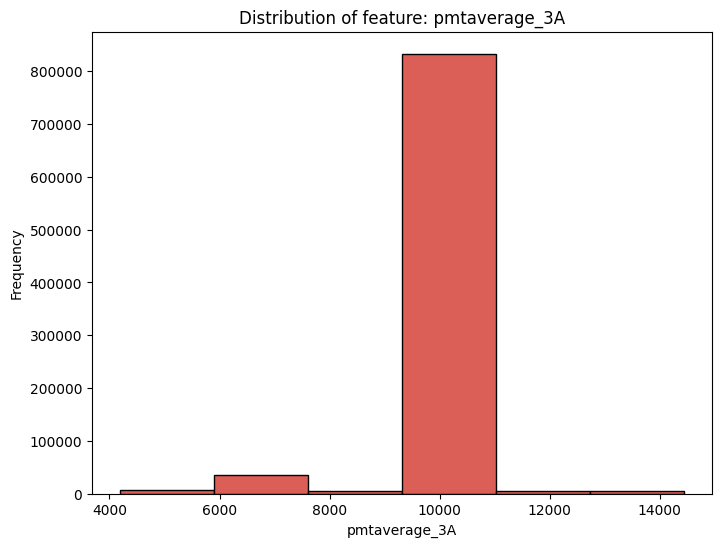

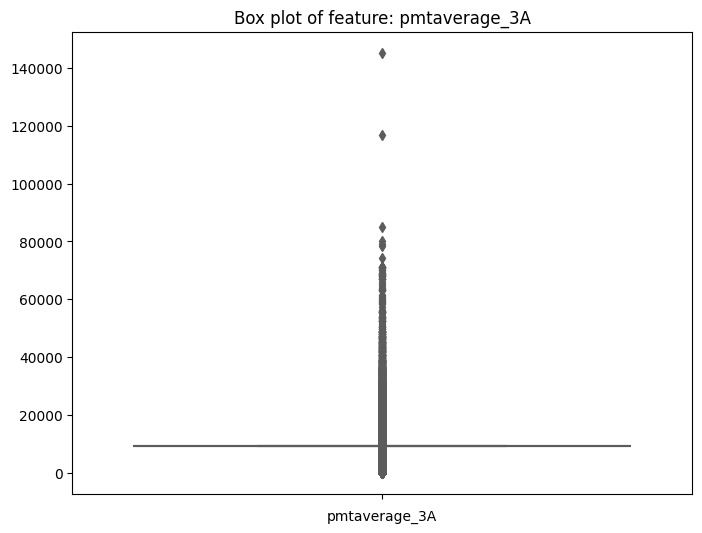

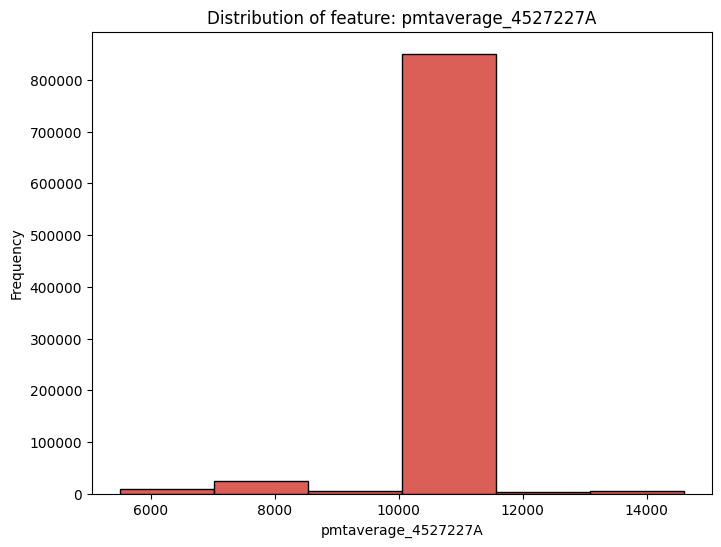

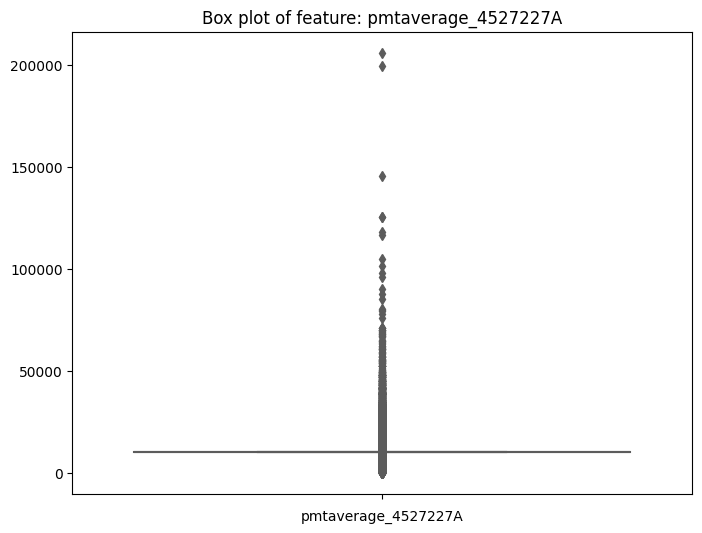

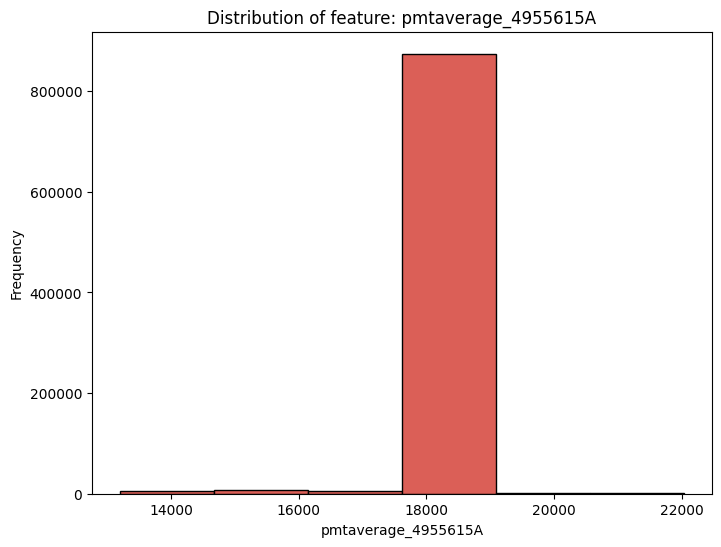

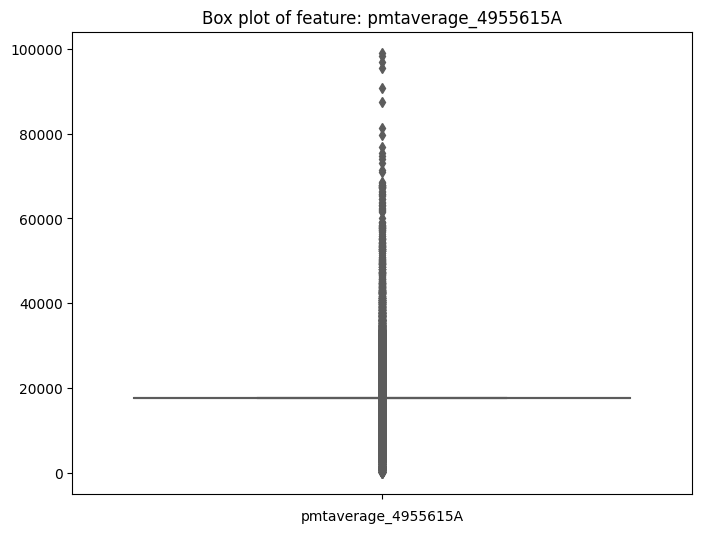

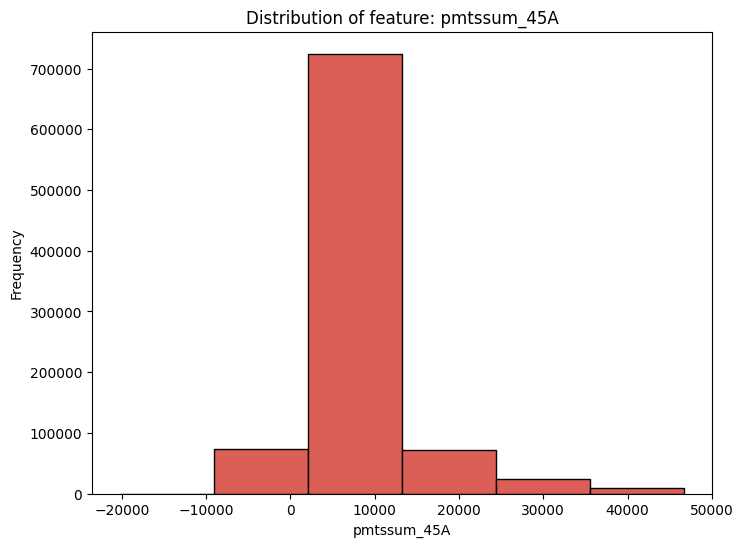

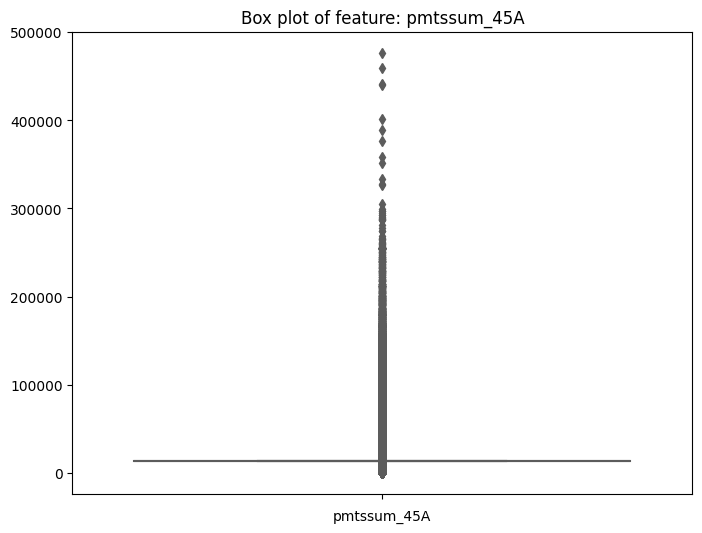

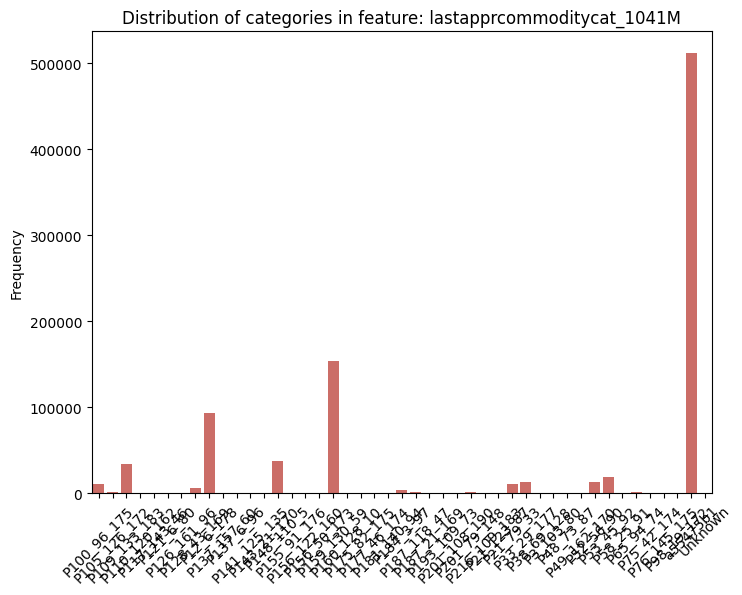

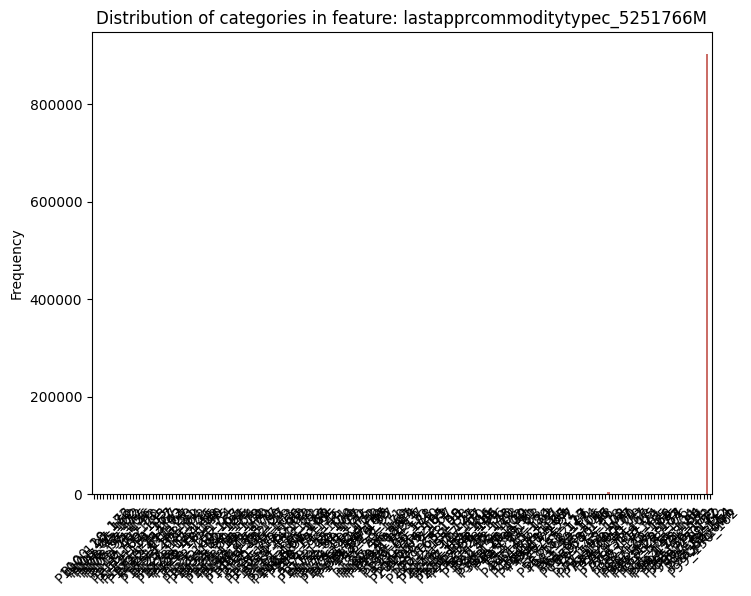

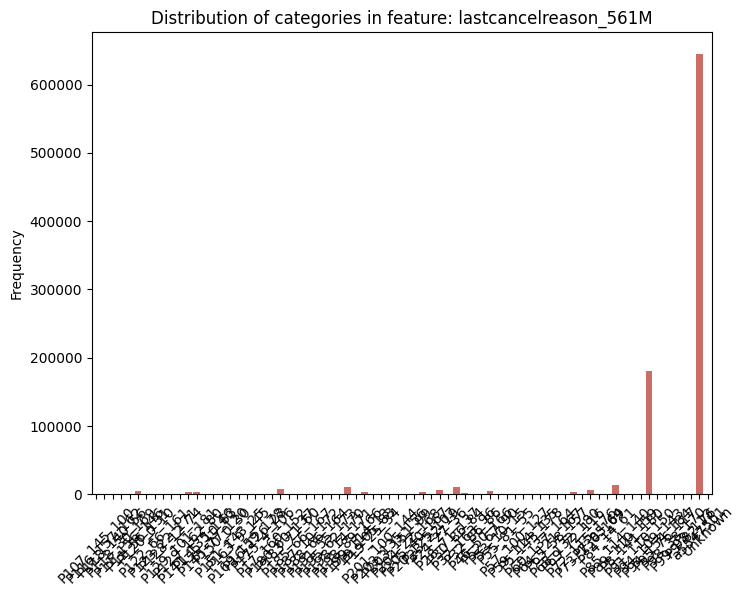

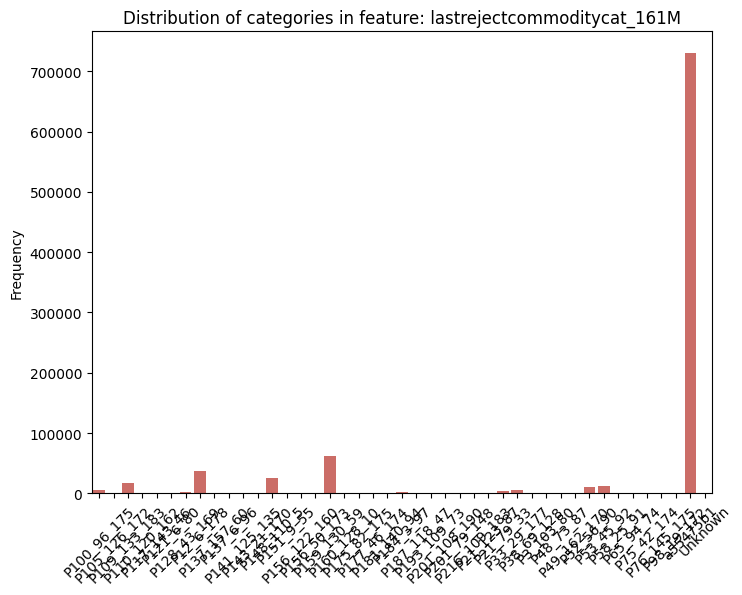

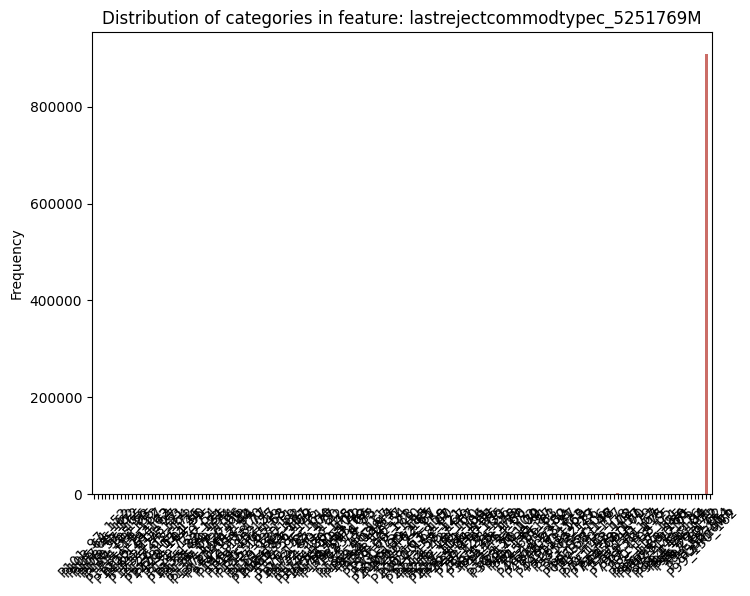

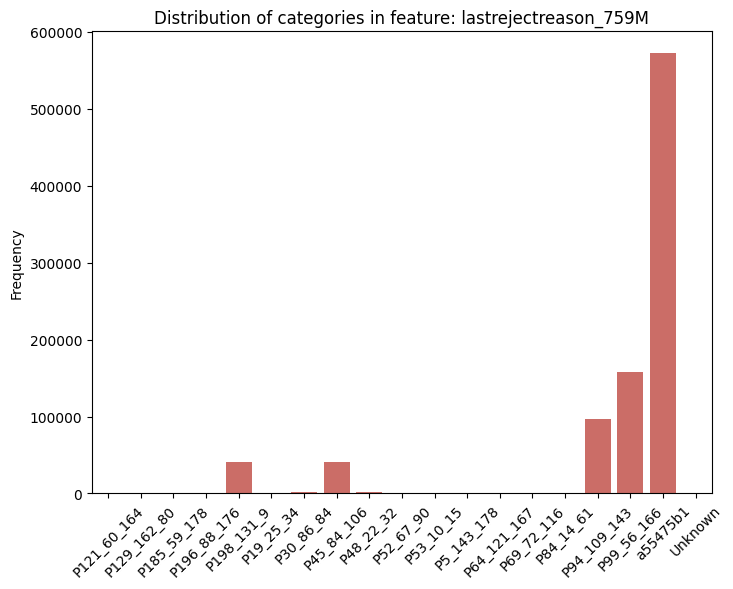

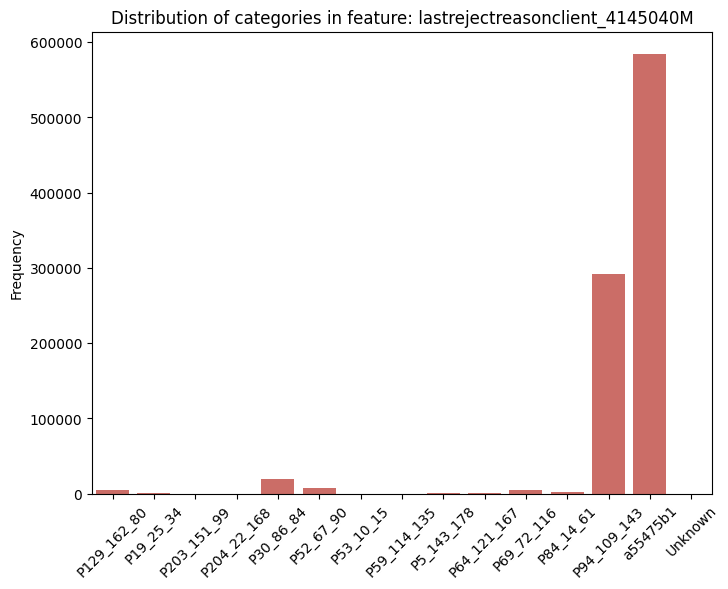

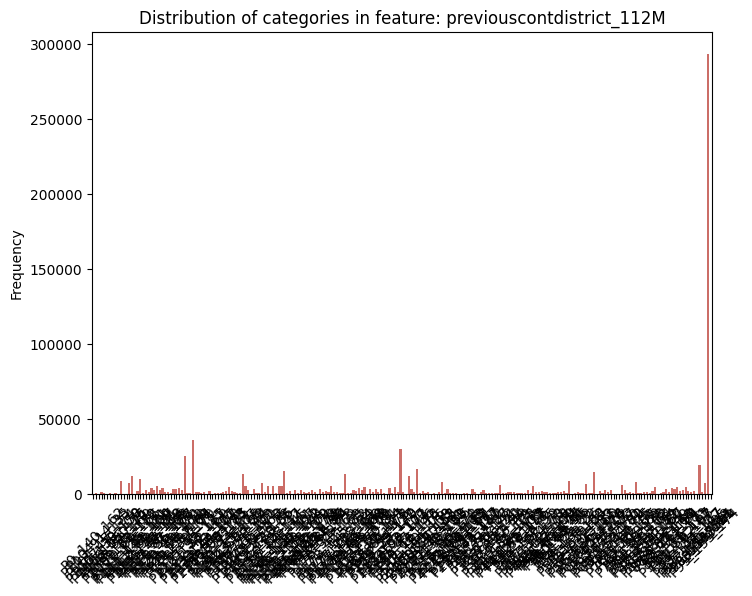

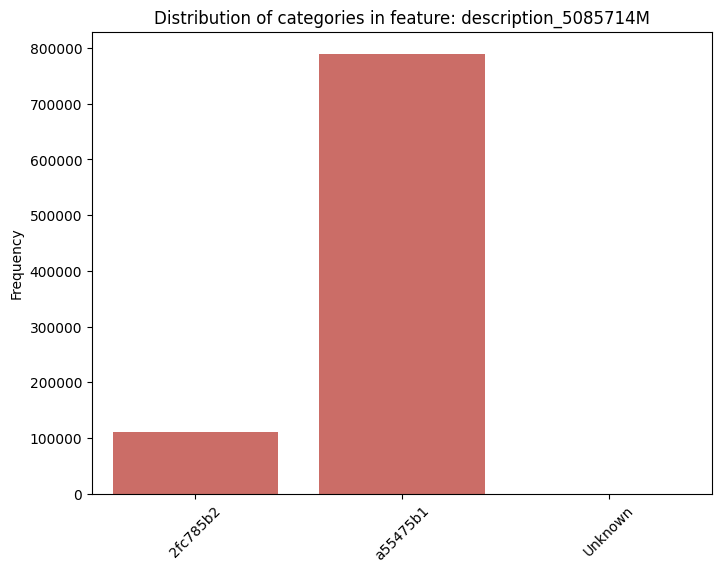

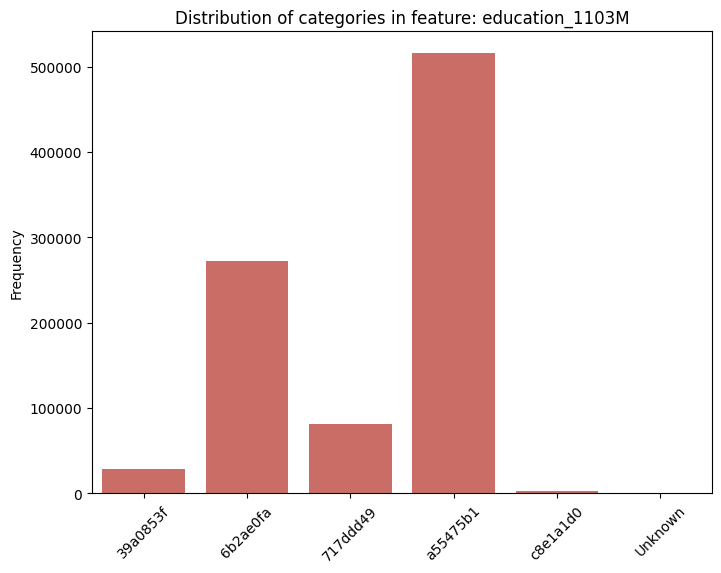

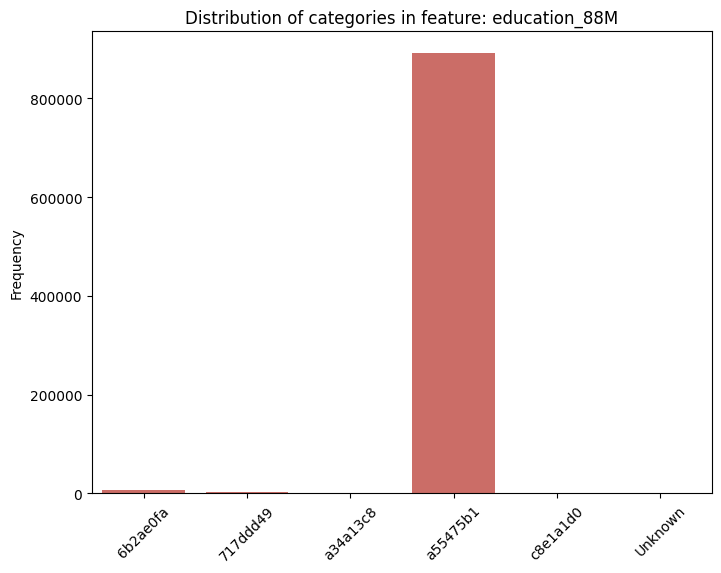

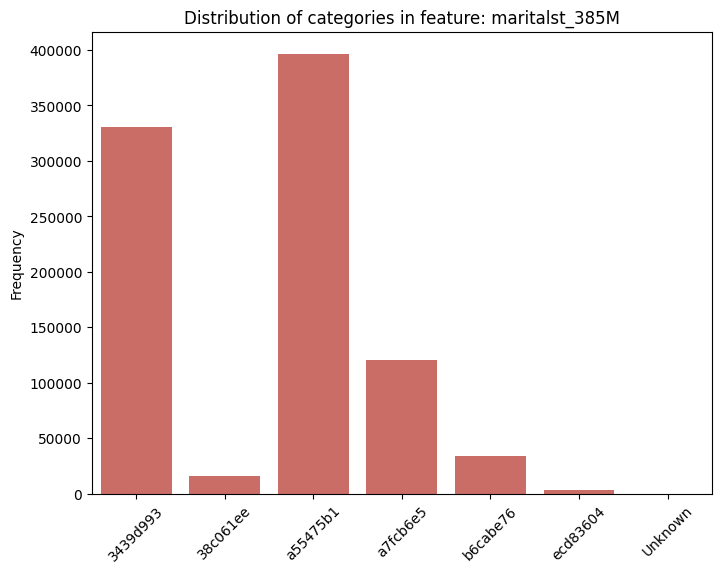

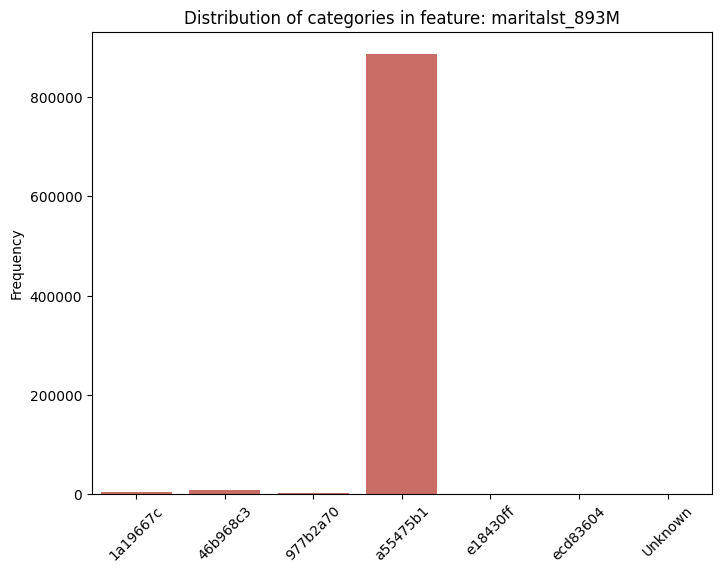

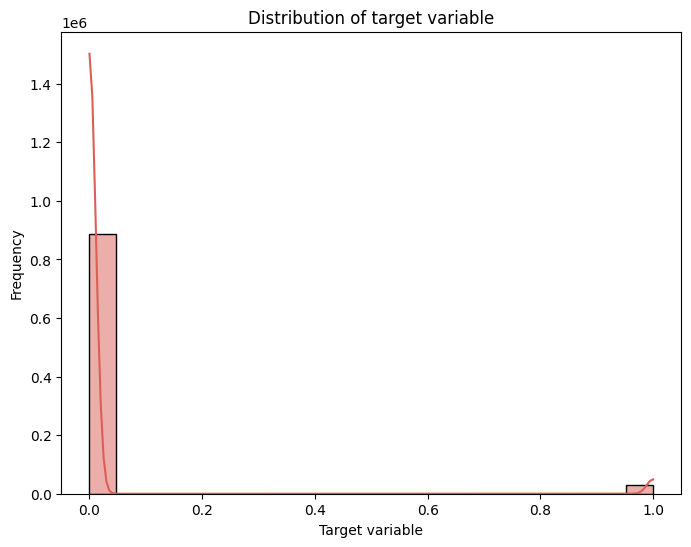

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Color palette for visualizations
colors = sns.color_palette("hls", len(X_train.select_dtypes(include=['int64', 'float64'])))

# Inspect shapes of X_train and y_train
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Numerical feature visualizations (adapt based on your features)
for i, col in enumerate(X_train.select_dtypes(include=['int64', 'float64'])):
    # Count missing values
    missing_count = X_train[col].isna().sum()
    if missing_count > 0:    # there is one missing value in annuitynextmonth_57A
        print(f"Warning: Feature {col} has {missing_count} missing values ({missing_count/len(X_train):.2%}). Consider imputation.")

    # Histogram with custom bins and colors based on normal distribution
    if X_train[col].isna().any():
        ''' Handle missing values (replace with appropriate strategy) '''
        X_train[col] = X_train[col].fillna(X_train[col].mean())

    # Calculate mean and standard deviation
    mean_val = X_train[col].mean()
    std_dev = X_train[col].std()

    # Define bins based on standard deviations
    bins = [
        mean_val - 3 * std_dev,
        mean_val - 2 * std_dev,
        mean_val - std_dev,
        mean_val,
        mean_val + std_dev,
        mean_val + 2 * std_dev,
        mean_val + 3 * std_dev,
    ]

    # Histogram with custom bins and colors
    plt.figure(figsize=(8, 6))
    plt.hist(X_train[col], bins=bins, ec="k", color=colors[i])
    plt.title(f"Distribution of feature: {col}")
    plt.xlabel(f"{col}")
    plt.ylabel("Frequency")
    plt.show()

    # Box plot for outliers
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=col, data=X_train, color=colors[i])
    plt.title(f"Box plot of feature: {col}")
    plt.xlabel(f"{col}")
    plt.ylabel("")  # Remove default y-axis label
    plt.show()

# Categorical feature visualizations
for col in X_train.select_dtypes(include=['category']):
    # Count or bar plot for category distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(x=col, data=X_train, palette=colors[:len(X_train[col].unique())])
    plt.title(f"Distribution of categories in feature: {col}")
    plt.xticks(rotation=45)
    plt.xlabel("")  # Remove default x-axis label
    plt.ylabel("Frequency")
    plt.show()

# Target variable visualization
plt.figure(figsize=(8, 6))
sns.histplot(data=y_train, kde=True, color=colors[0])
plt.title("Distribution of target variable")
plt.xlabel("Target variable")
plt.ylabel("Frequency")
plt.show()

# Further considerations:
# - Investigate relationships between features using scatter matrices or pair plots with rotated labels and informative color schemes.
# - Create feature importance plots if you have trained a model already, using a color scheme and rotated labels for clarity.
# - Adjust plot configurations (e.g., colors, bin sizes, labelpad) for better visualization based on your needs.



### BOX PLOTS
(Run this before the previous code block, to prevent mean imputation)
This plot is without imputing the null values

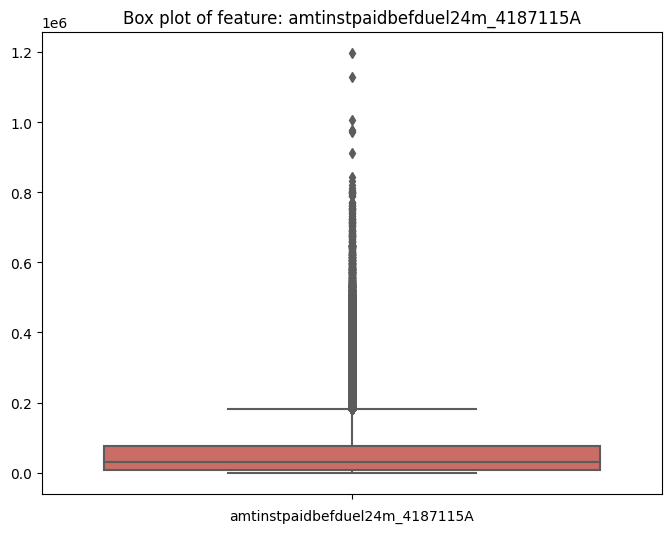

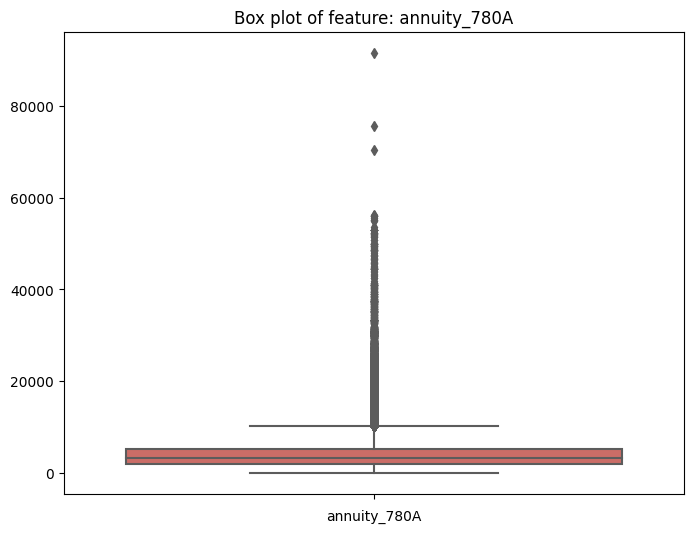

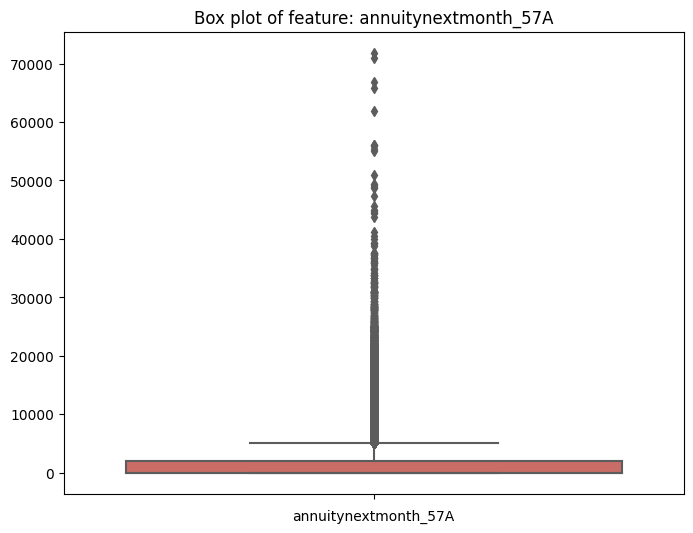

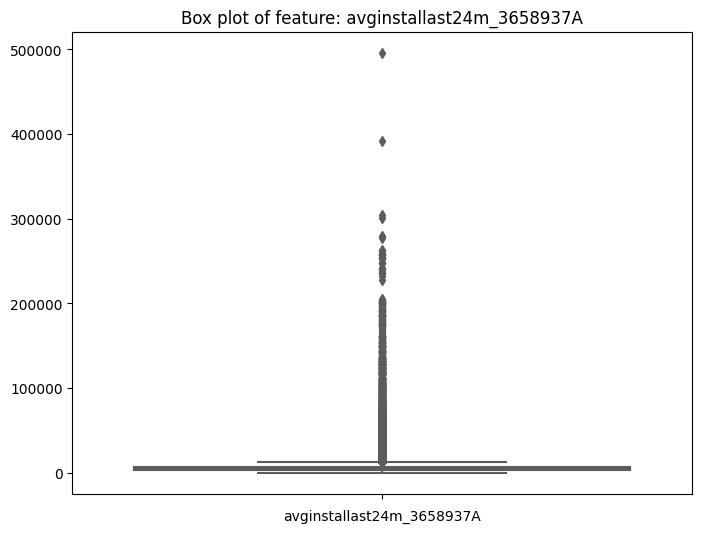

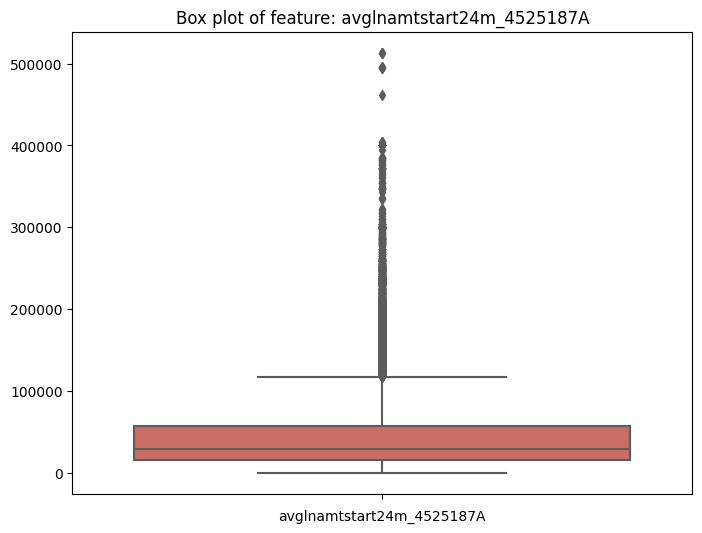

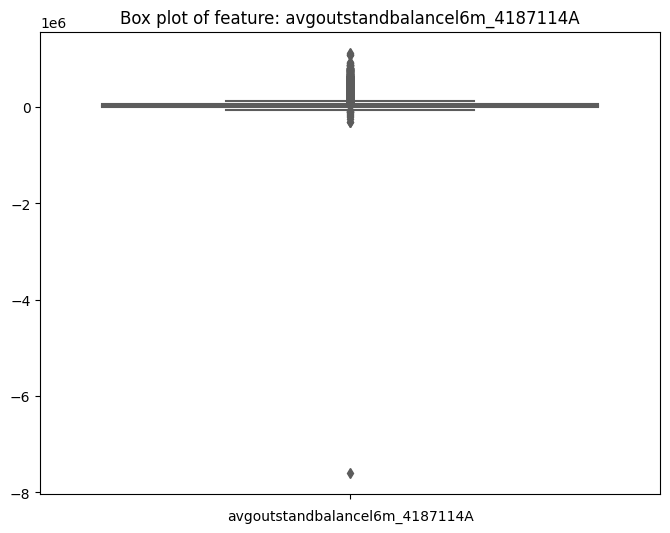

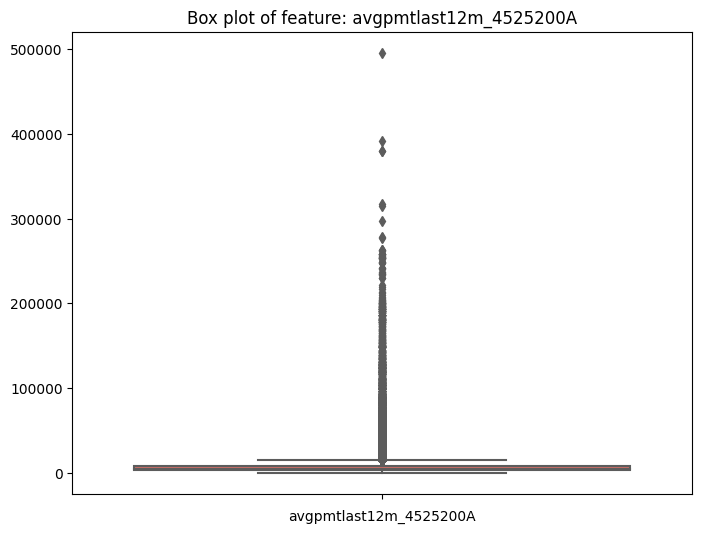

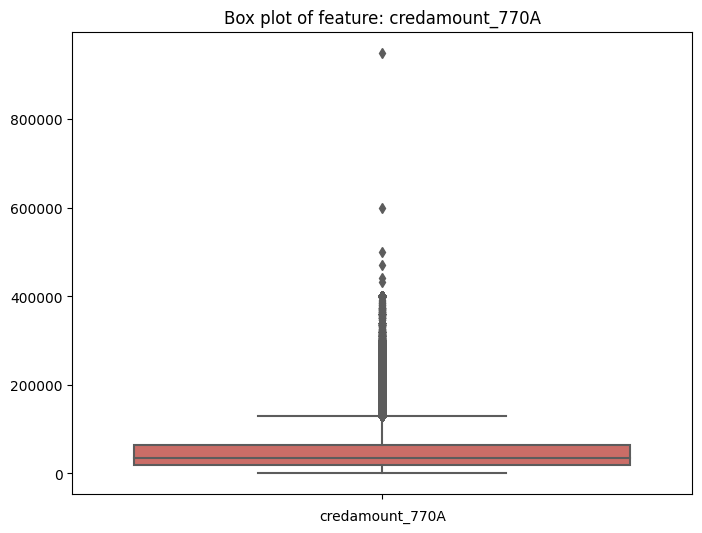

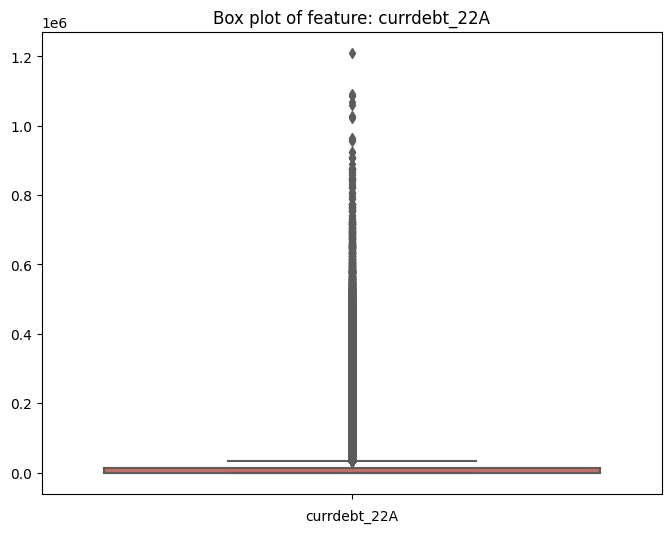

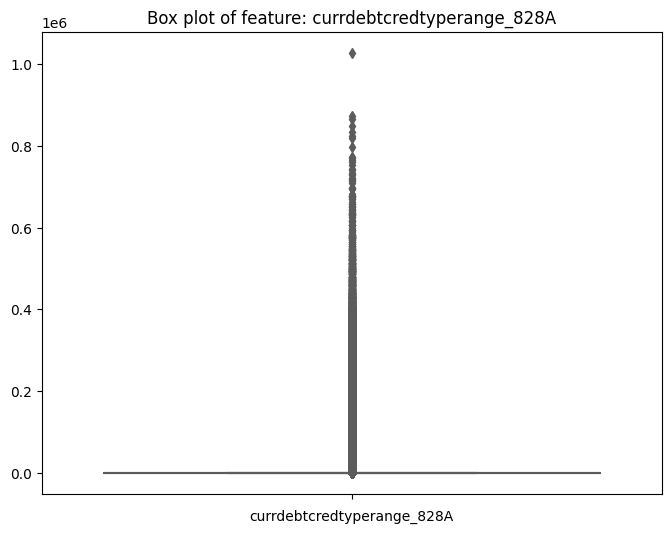

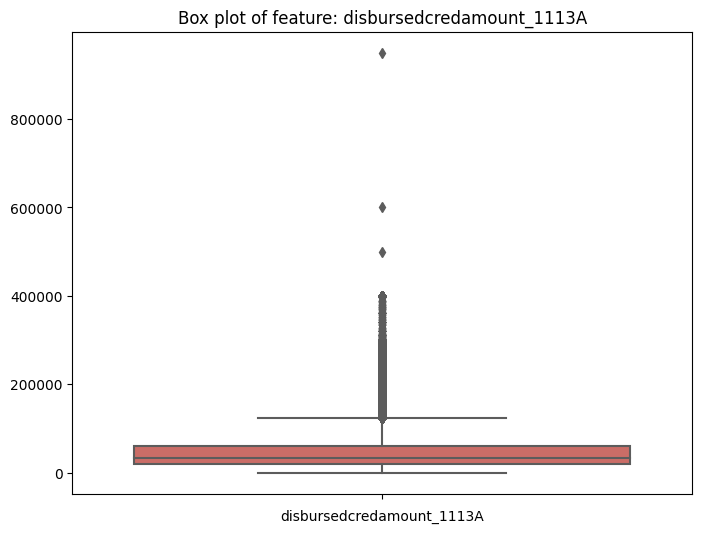

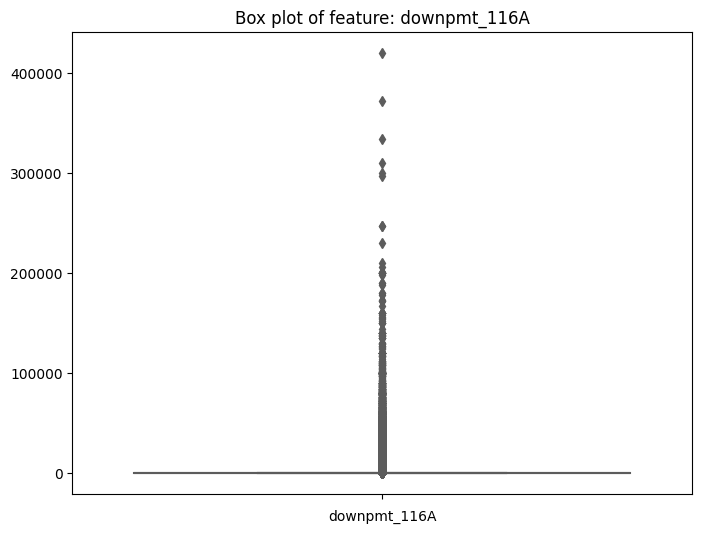

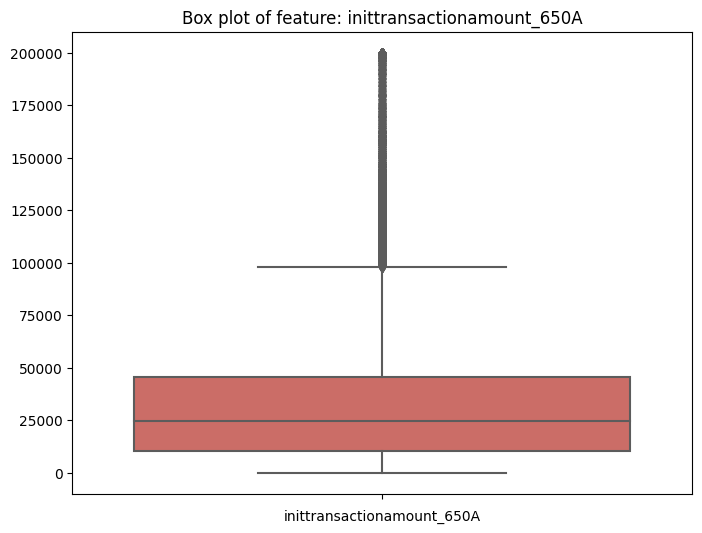

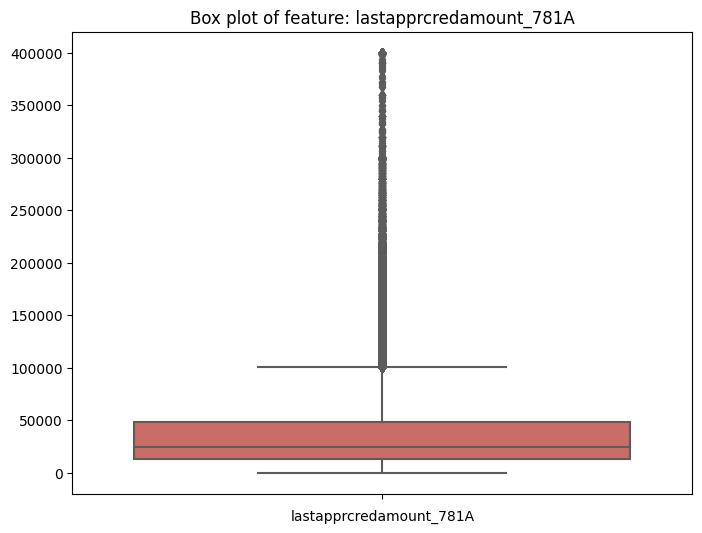

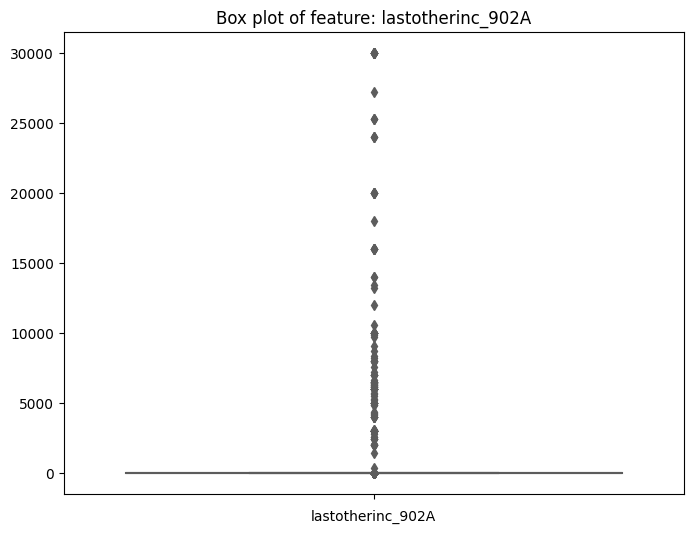

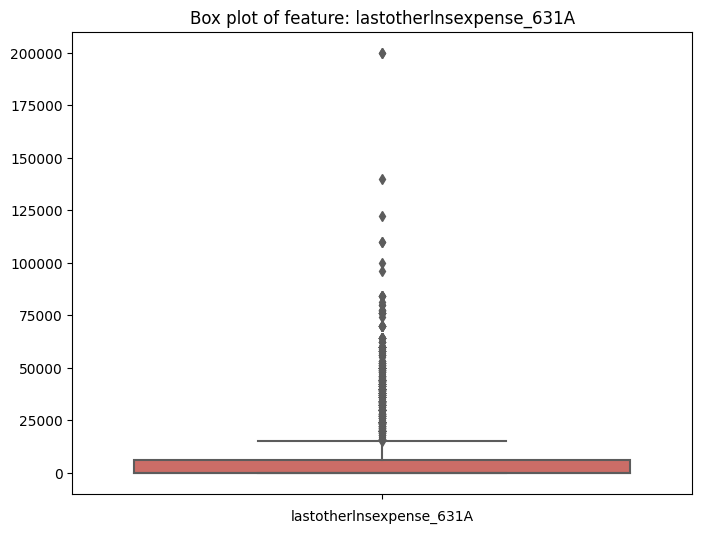

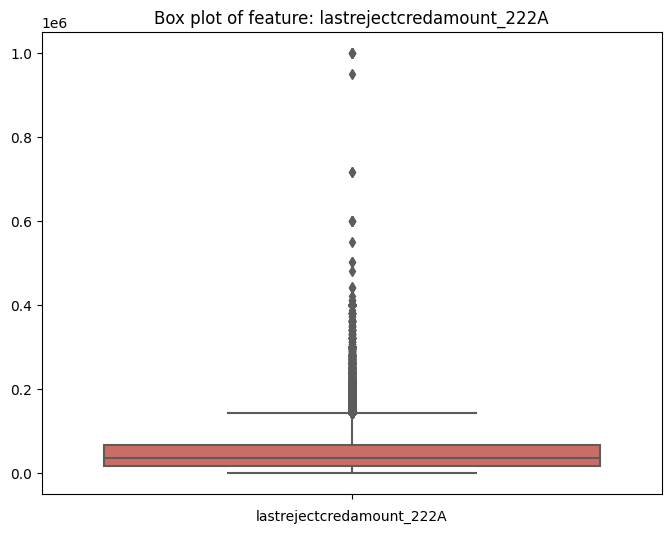

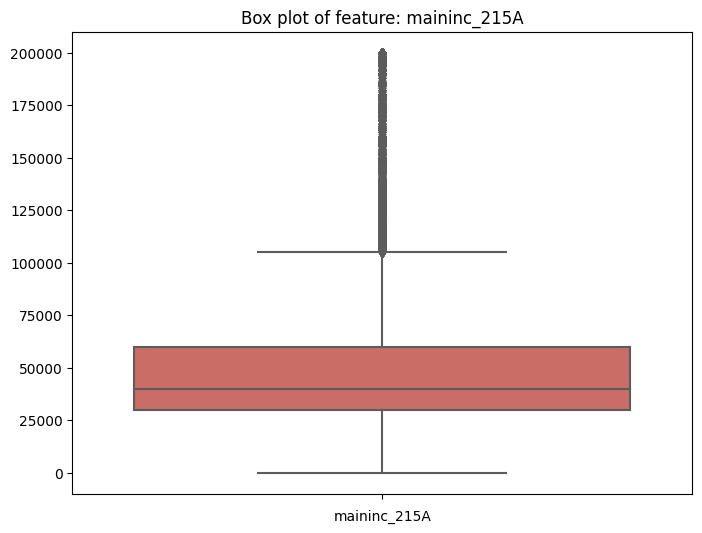

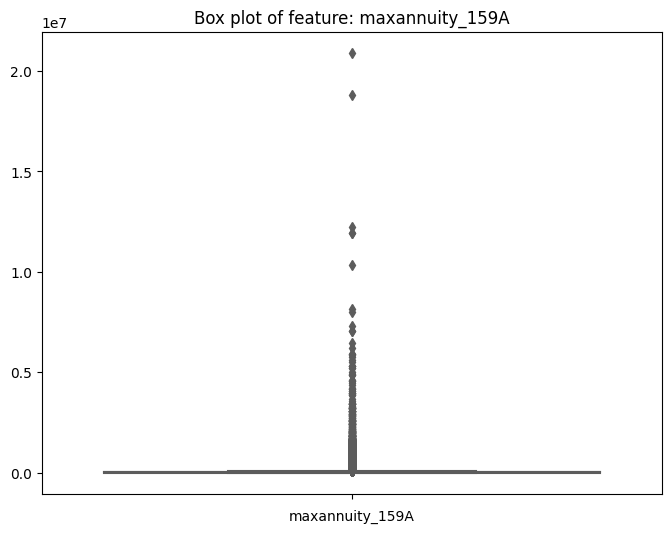

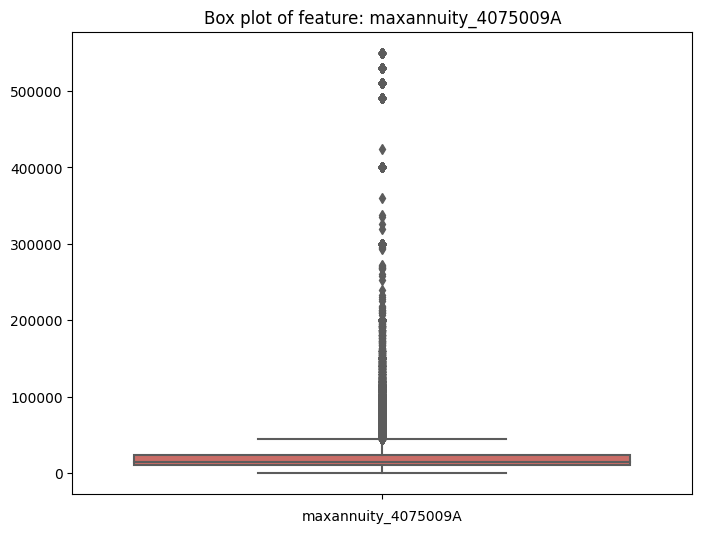

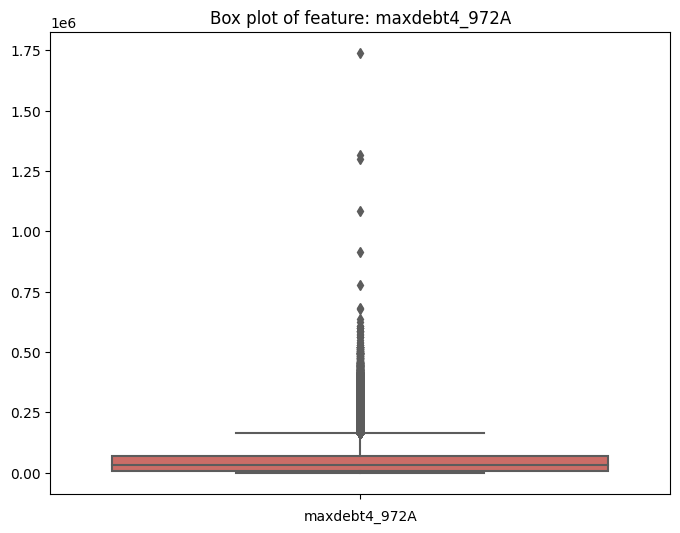

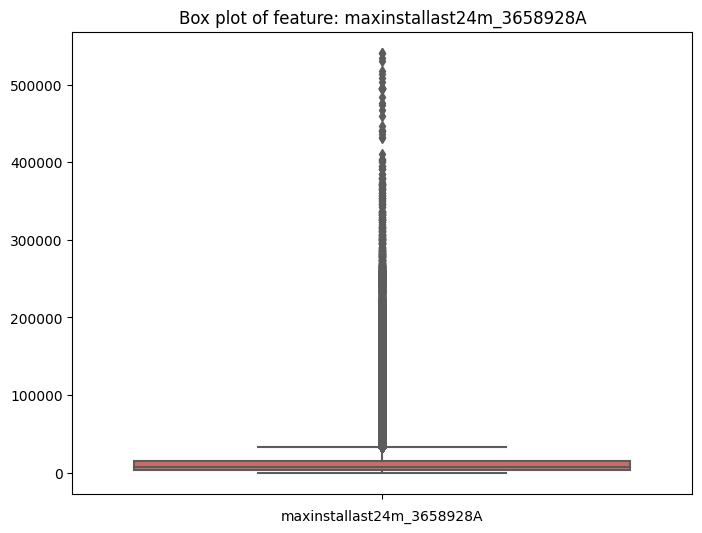

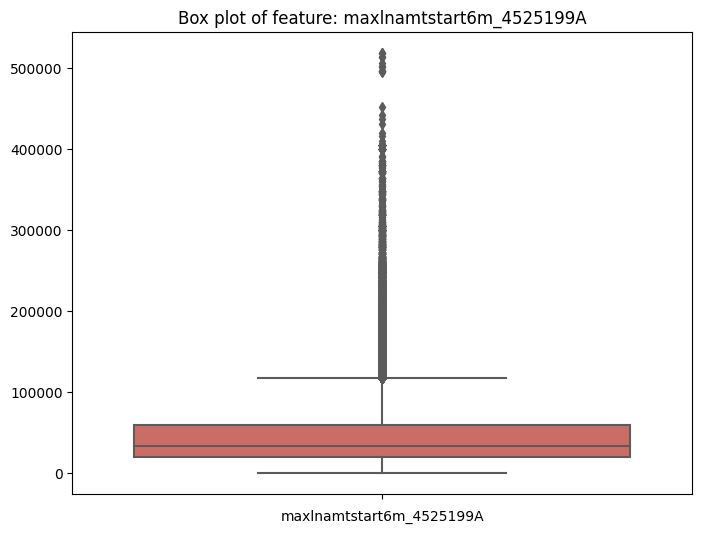

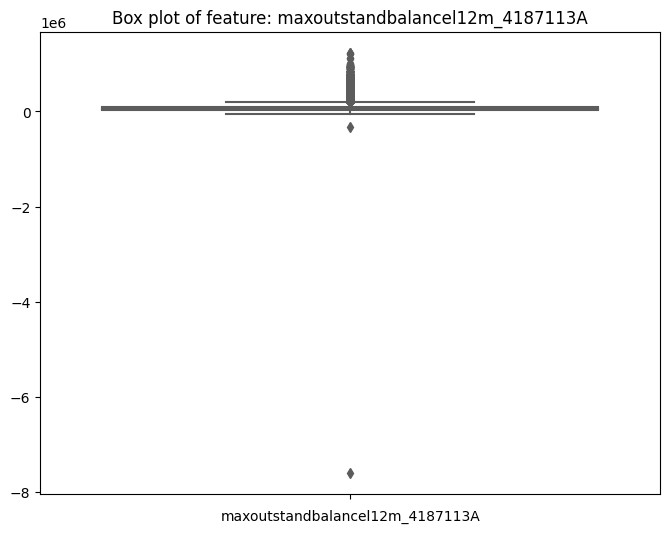

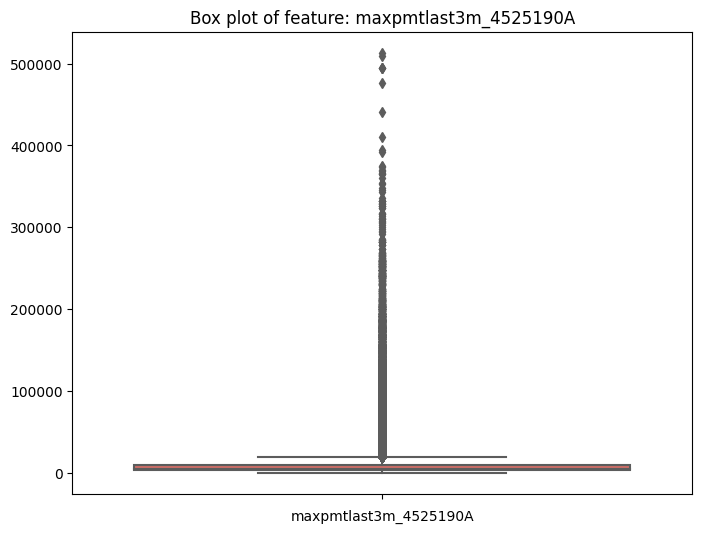

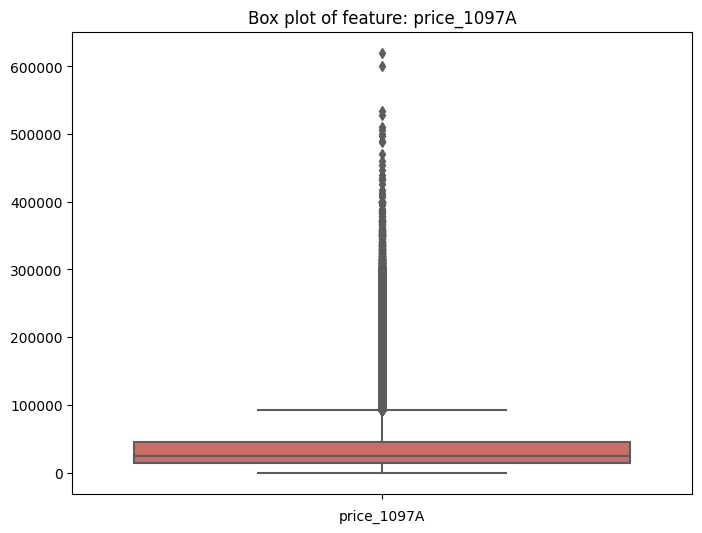

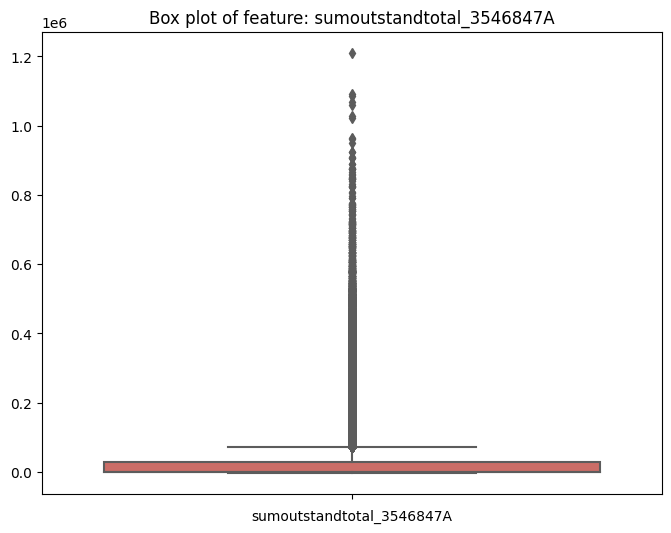

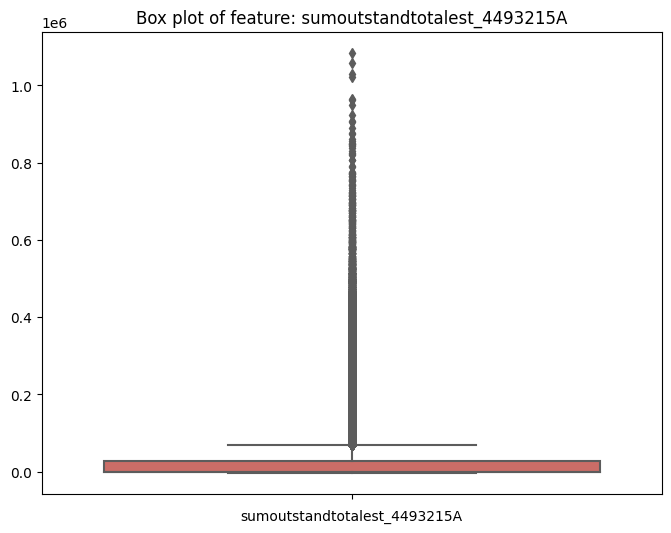

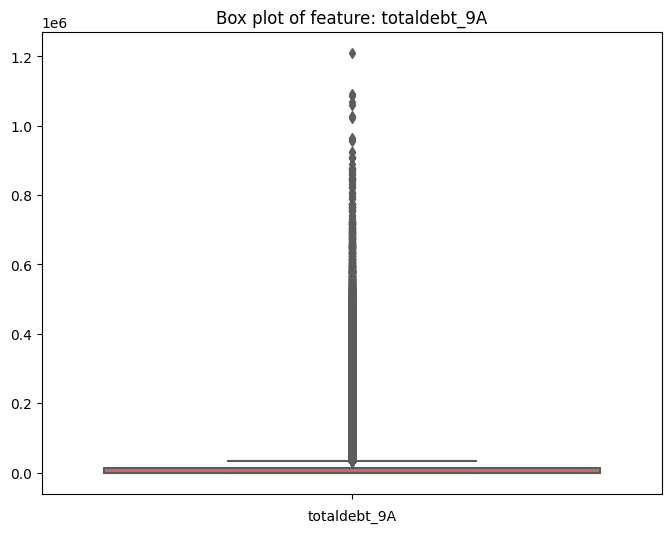

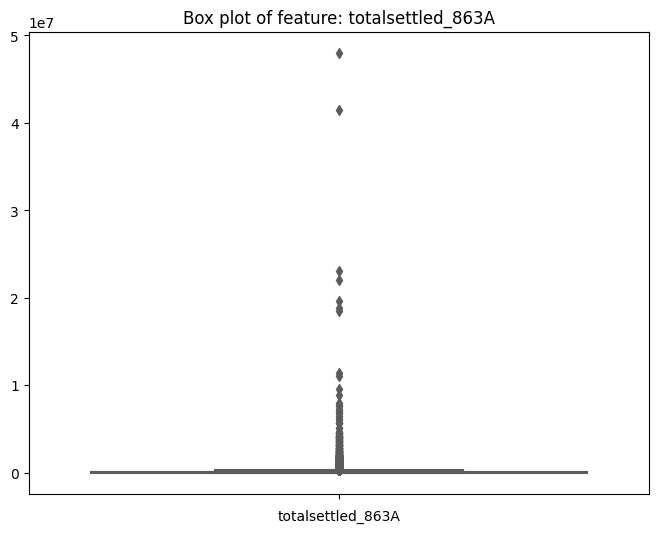

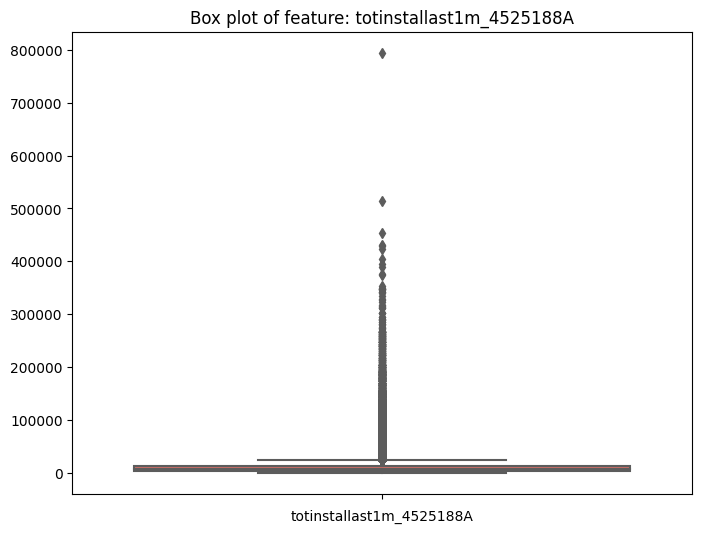

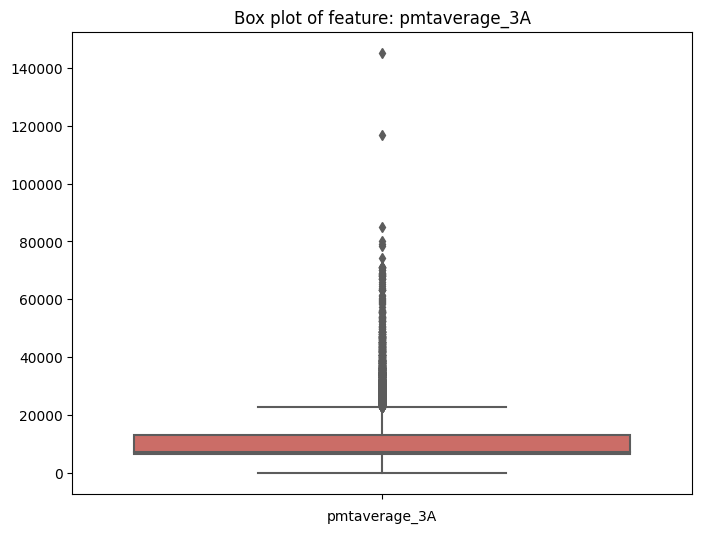

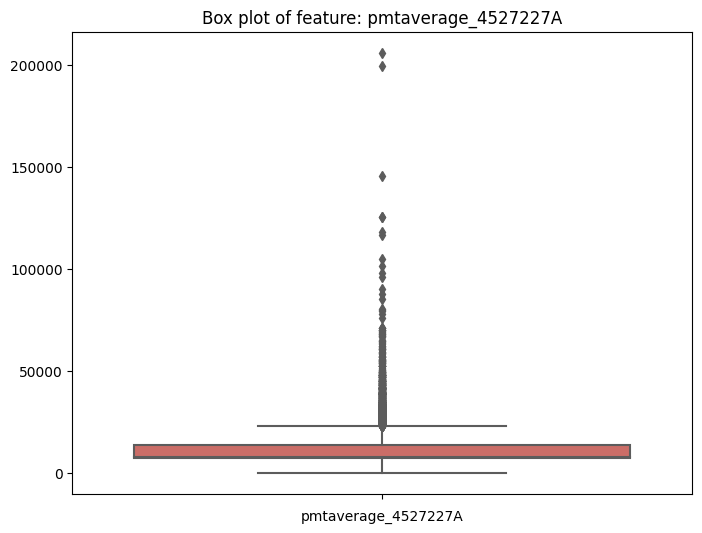

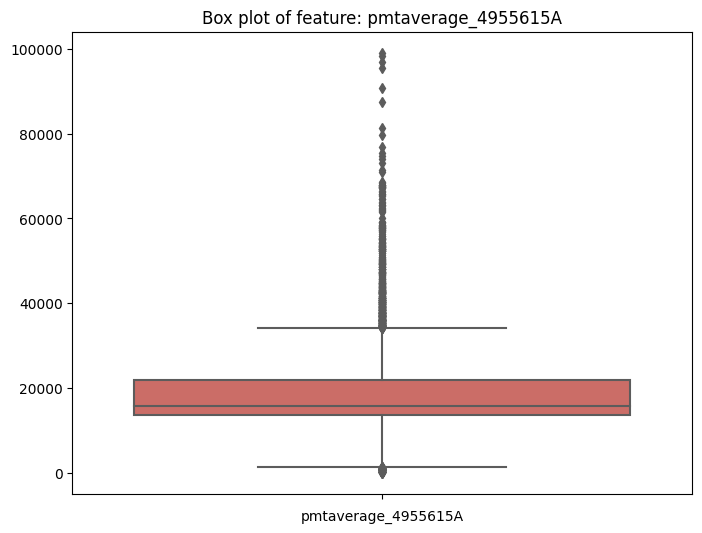

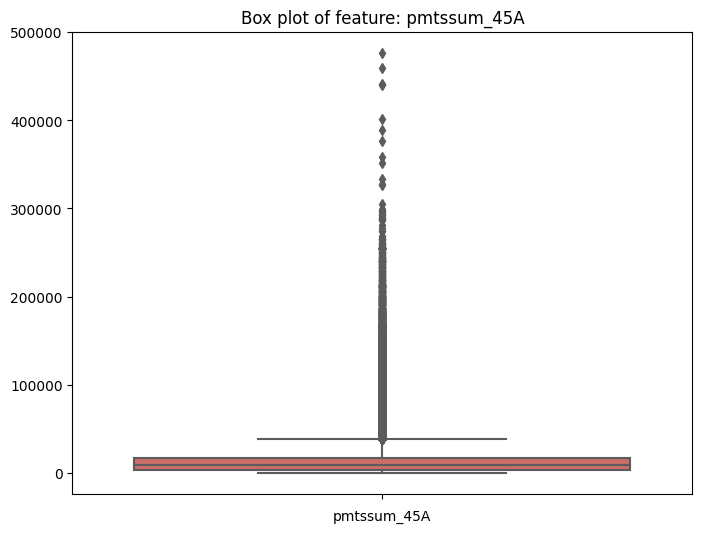

In [26]:
features_with_missing_values = {}
# Numerical feature visualizations (adapt based on your features)
for i, col in enumerate(X_train.select_dtypes(include=['int64', 'float64'])):
    # Count missing values
    missing_count = X_train[col].isna().sum()
    if missing_count > 0:
        print(f"Warning: Feature {col} has {missing_count} missing values ({missing_count/len(X_train):.2%}). Consider imputation.")
        features_with_missing_values[col] = missing_count

    # Handle missing values (replace with appropriate strategy)
    # X_train[col] = X_train[col].fillna(X_train[col].mean())  # Example imputation

    # Box plot for outliers
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=col, data=X_train, color=colors[i])
    plt.title(f"Box plot of feature: {col}")
    plt.xlabel(f"{col}")
    plt.ylabel("")
    plt.show()



### Bar graphs (rotated, with null)

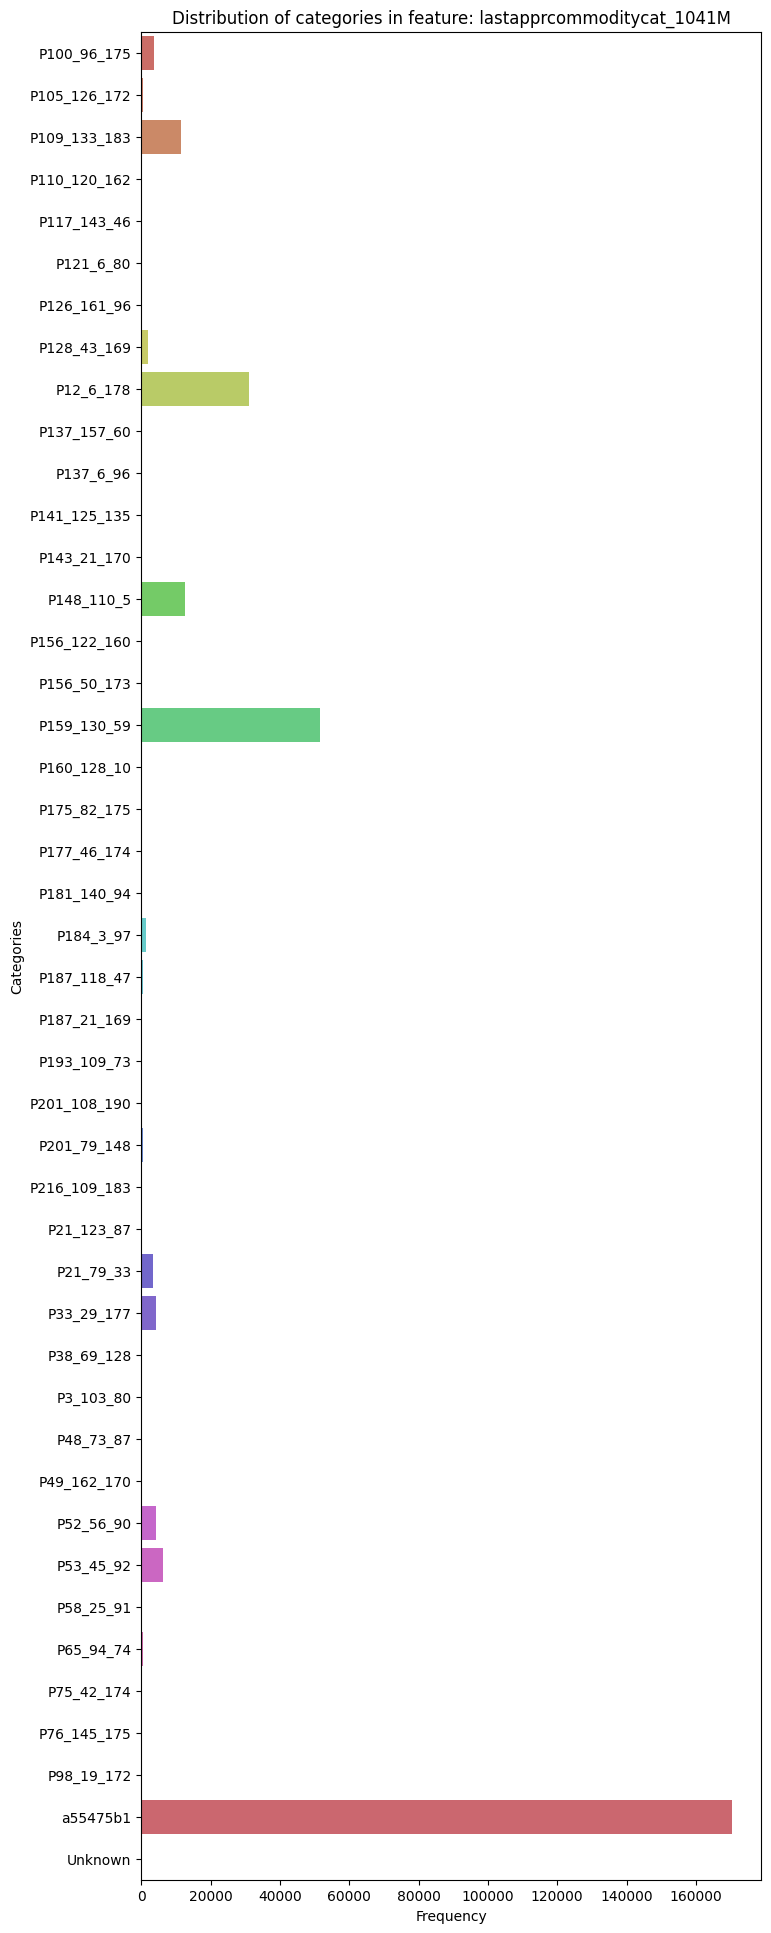

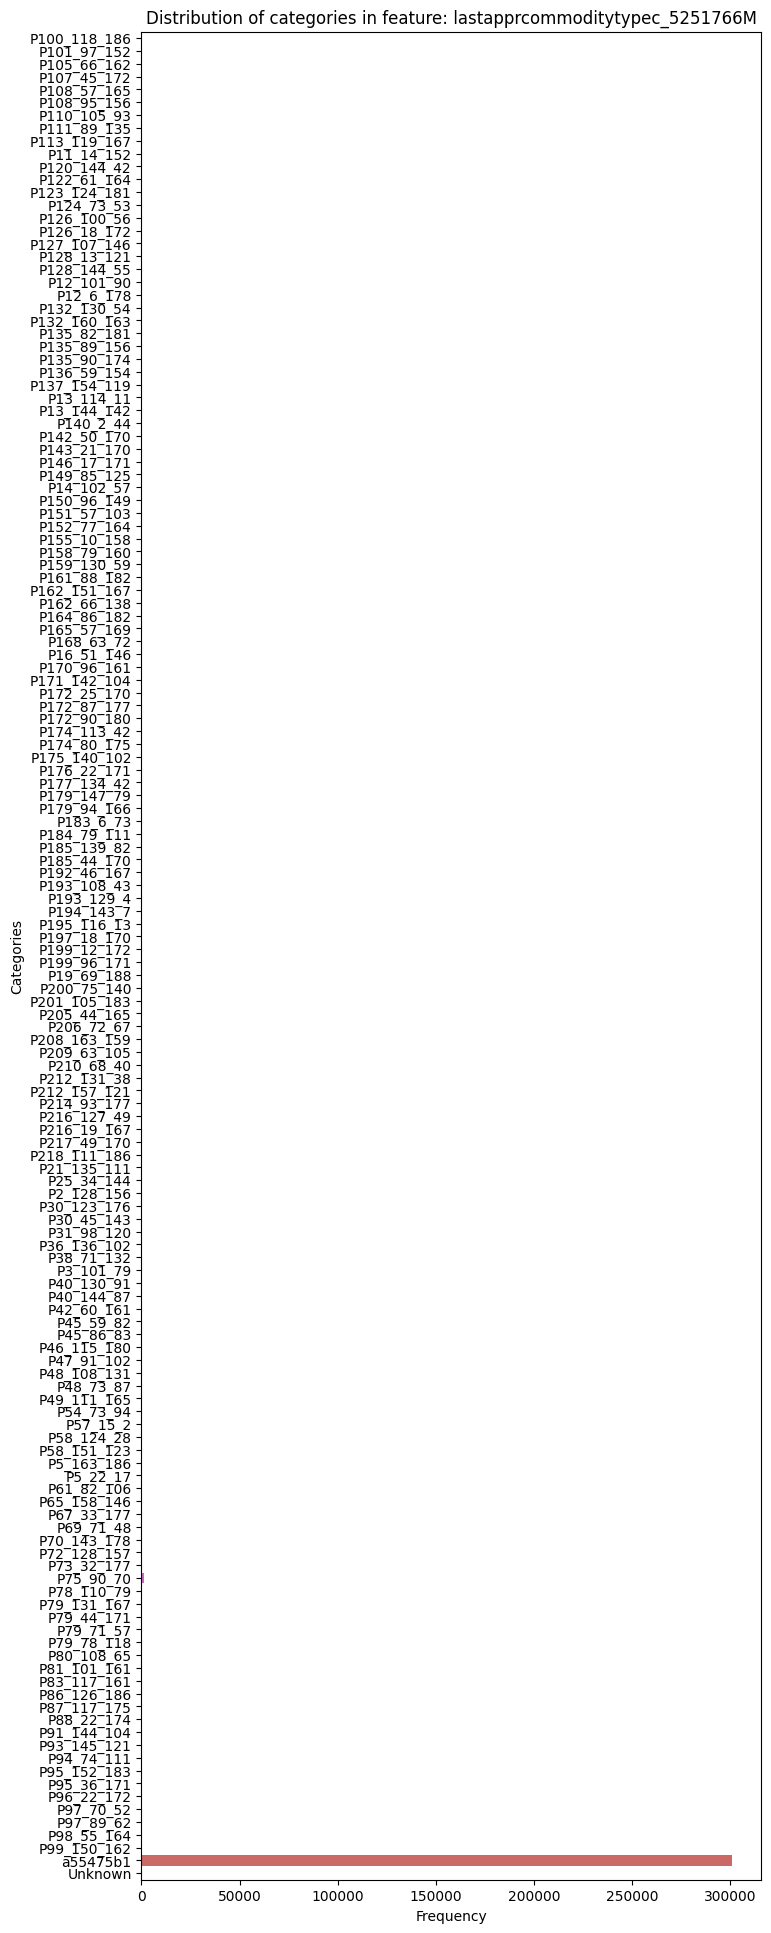

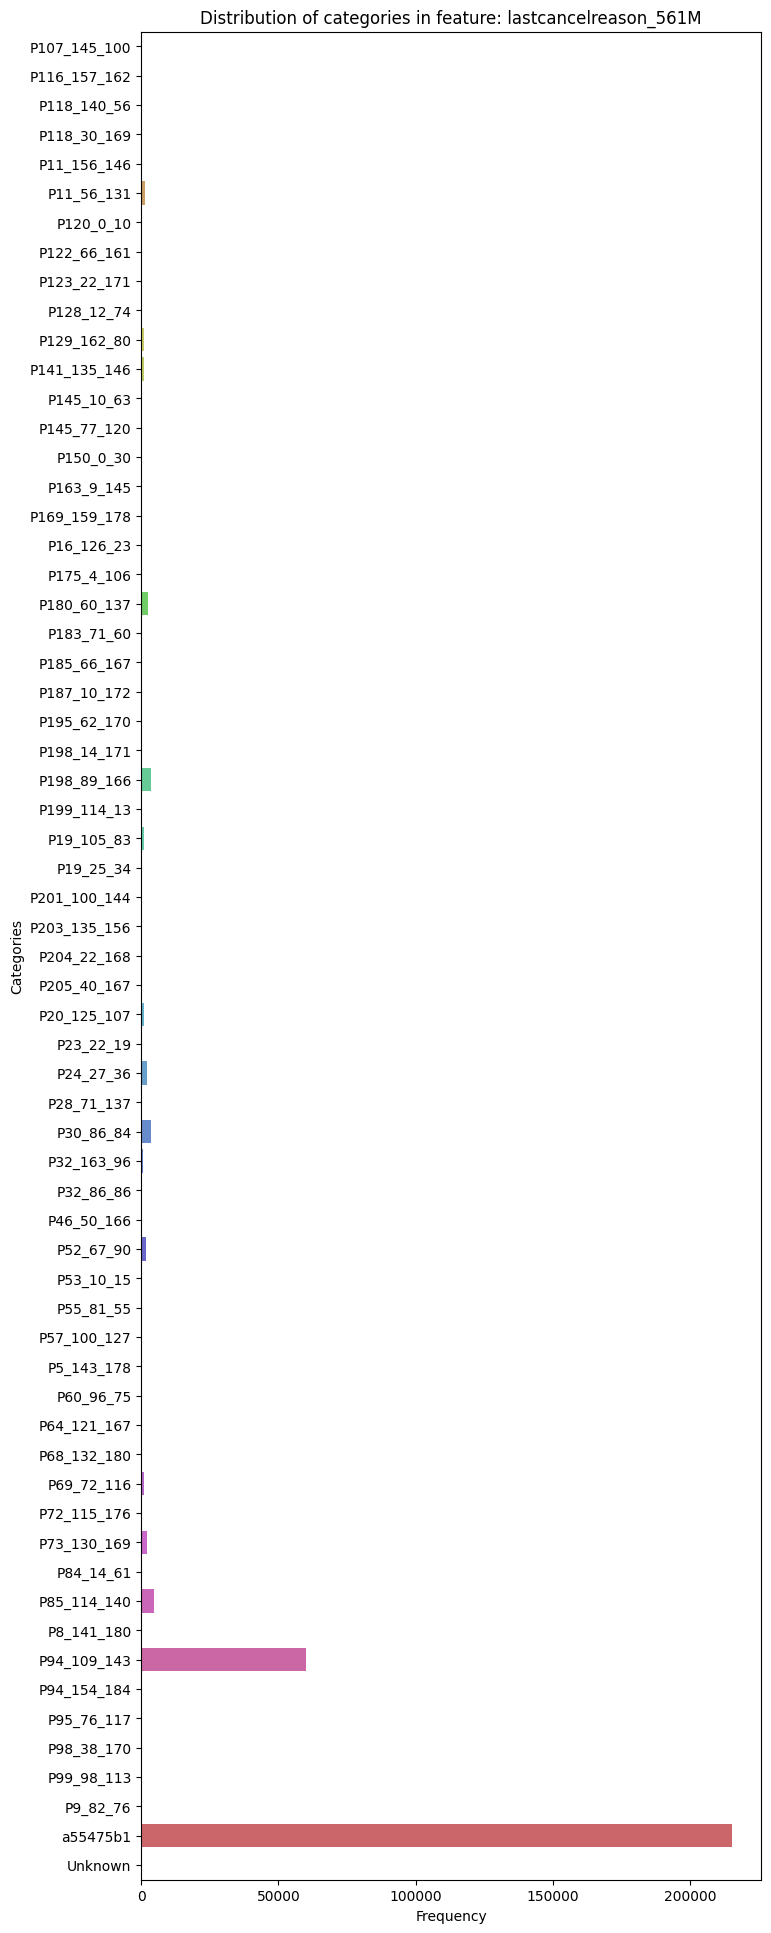

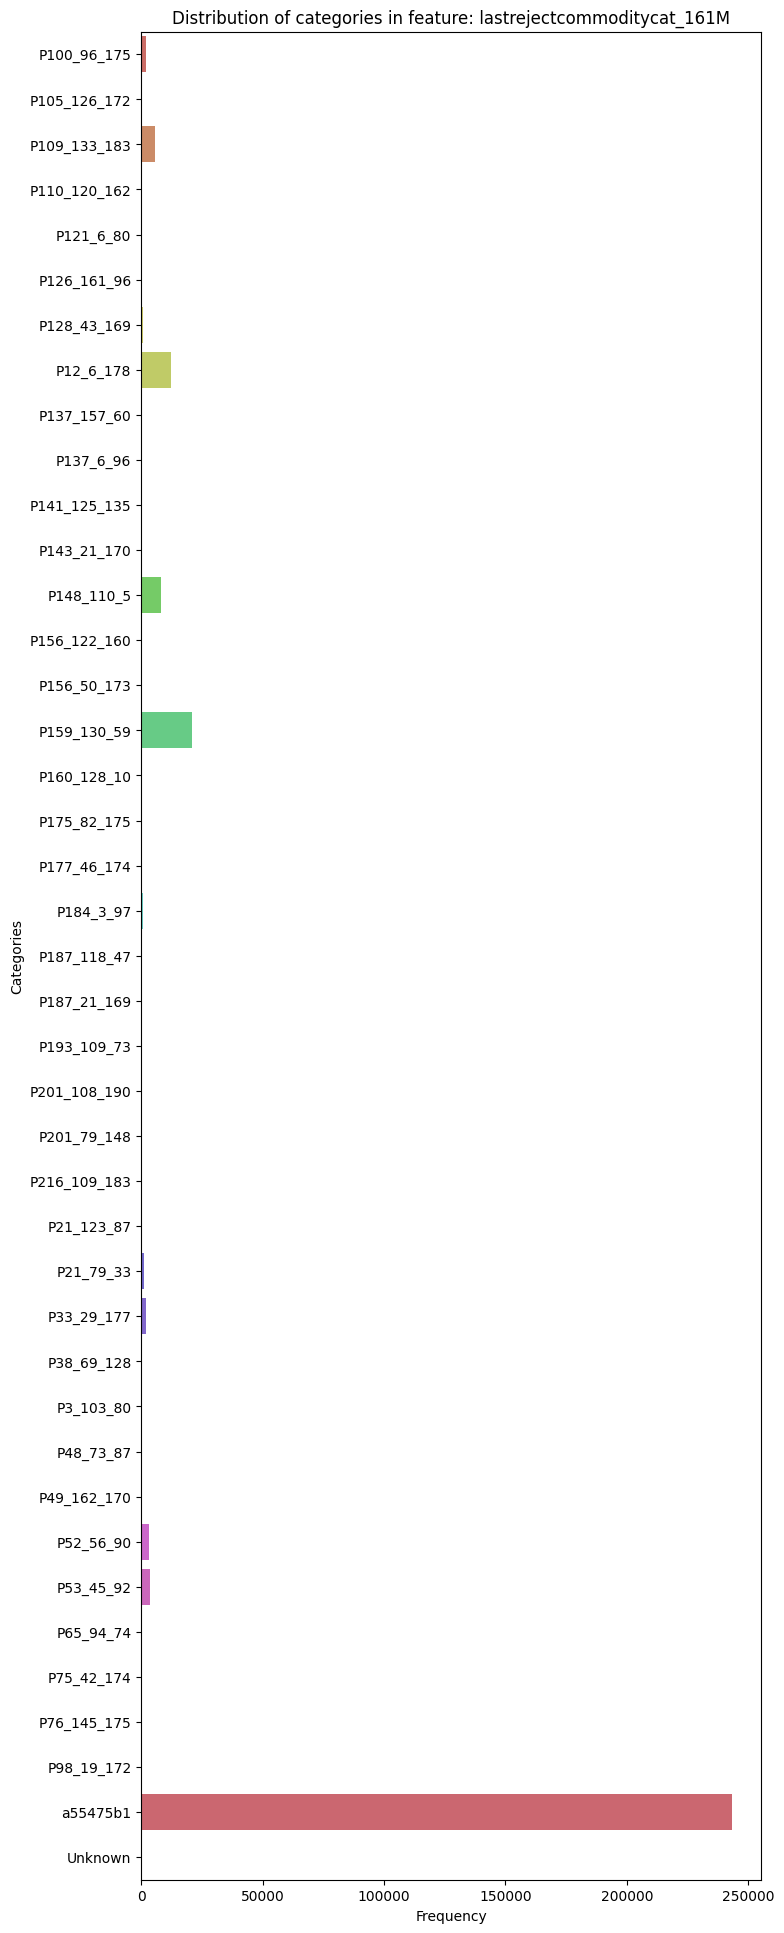

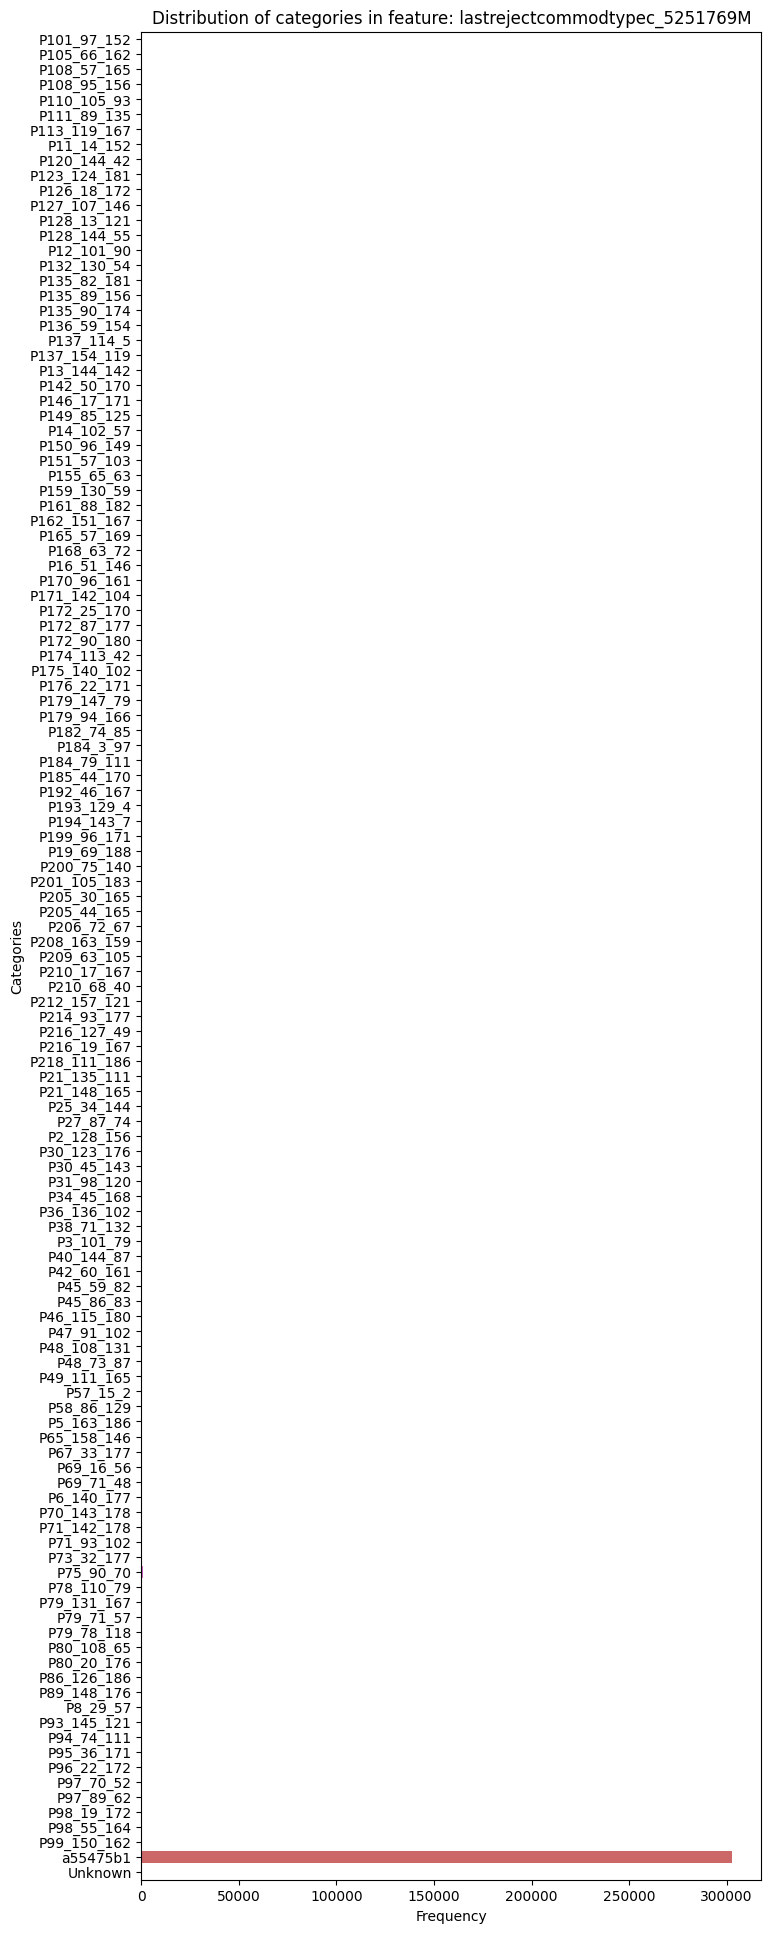

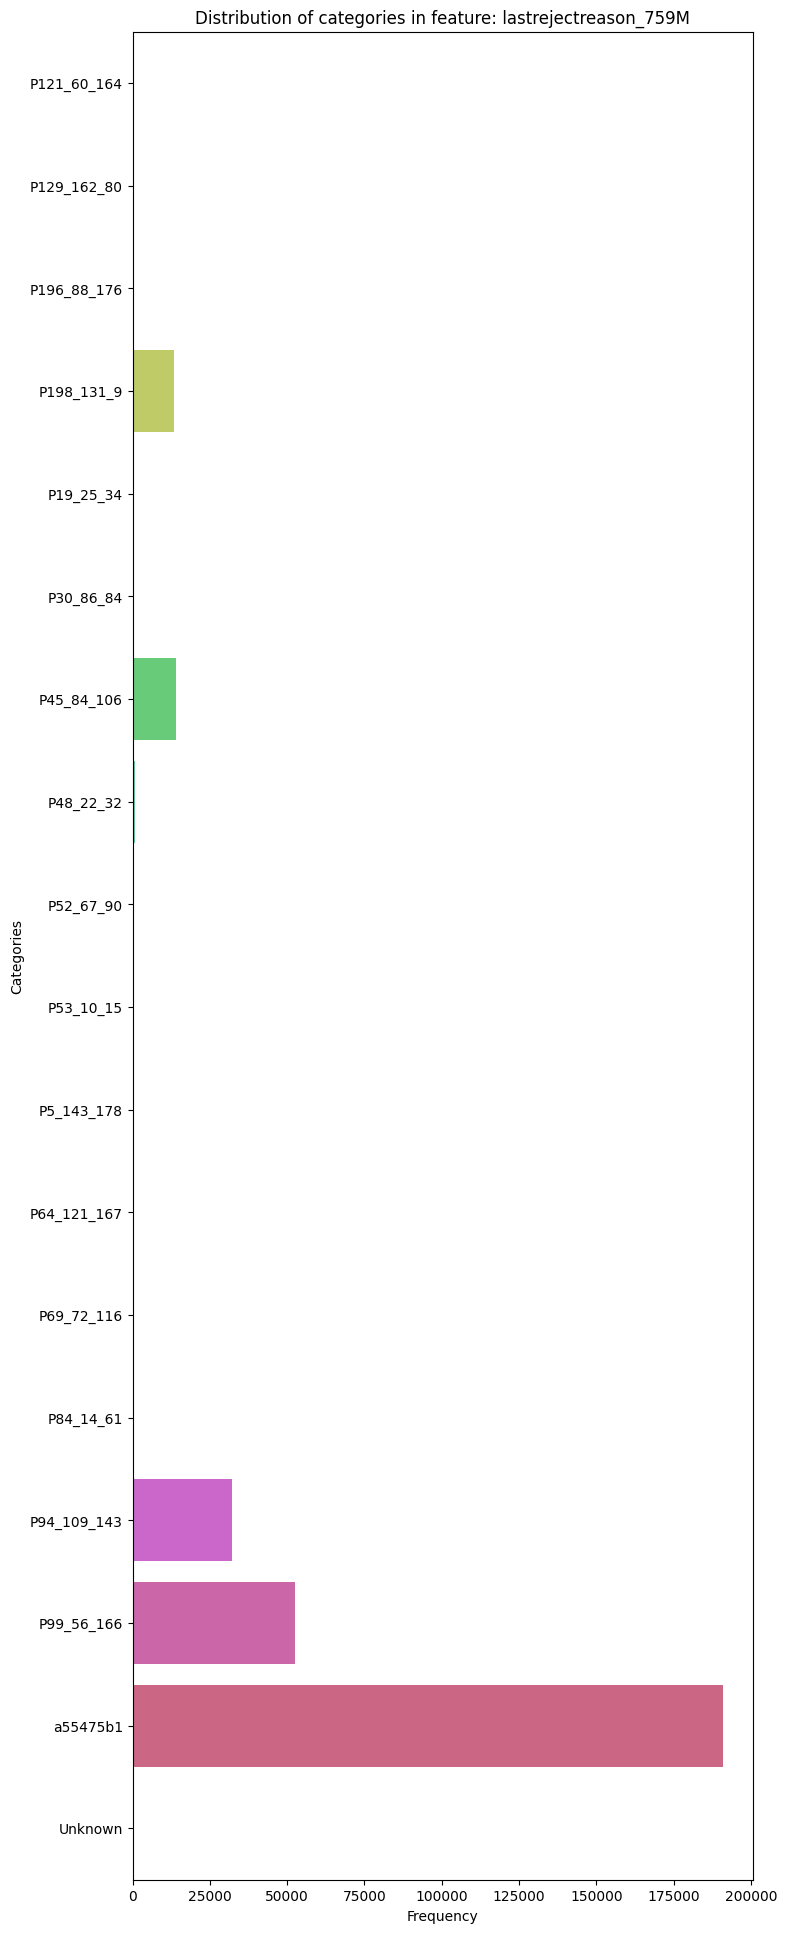

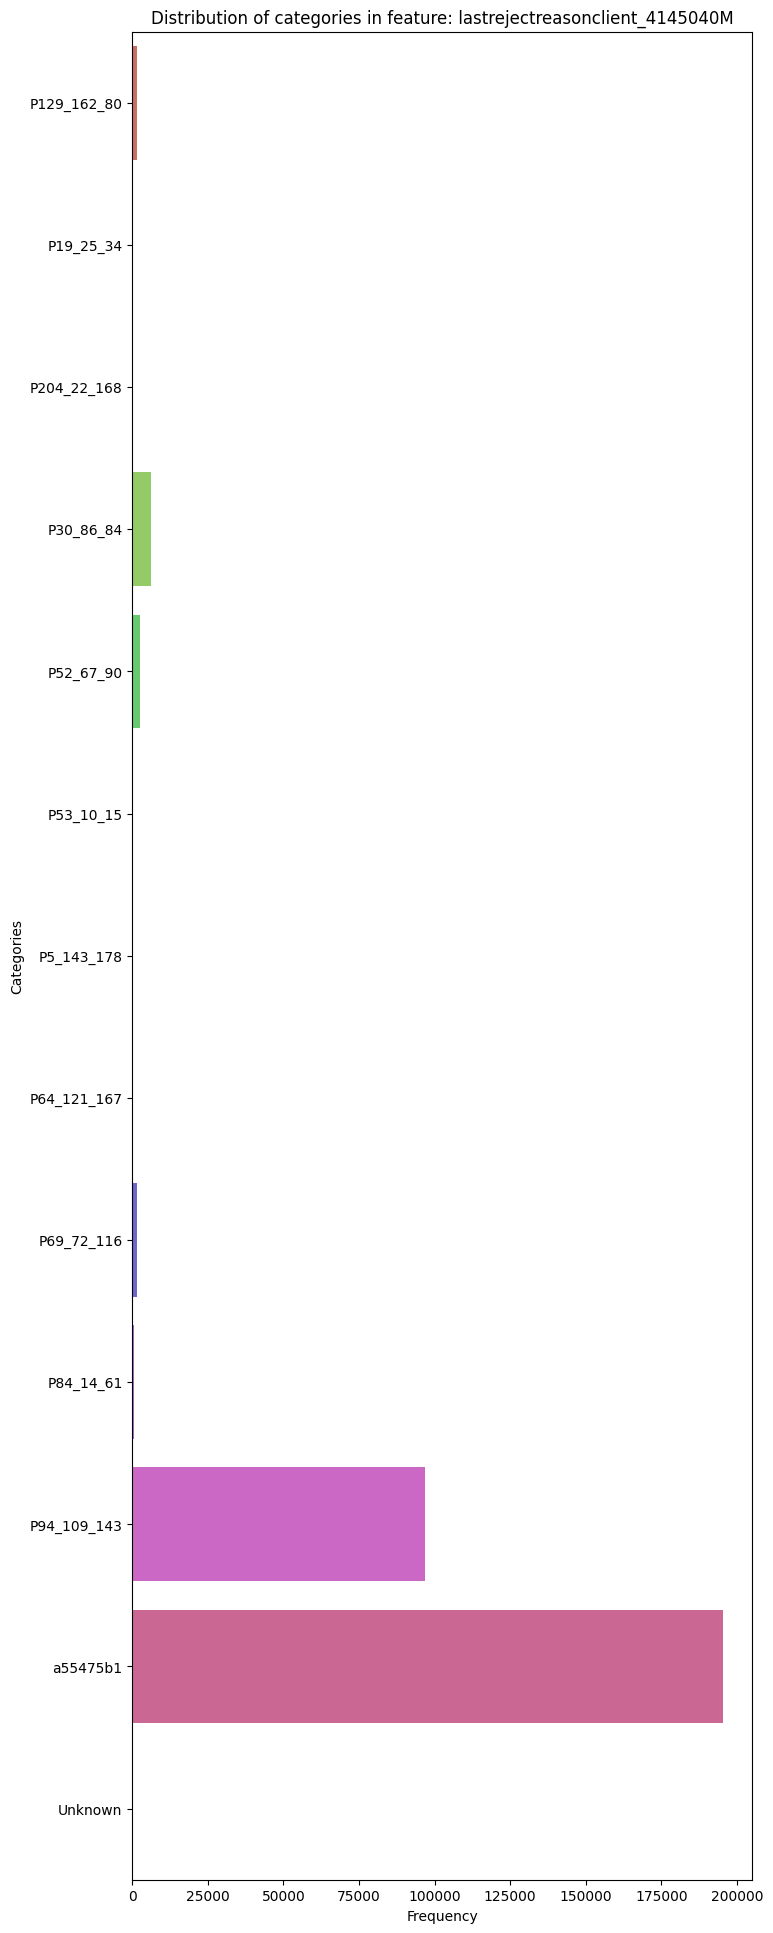

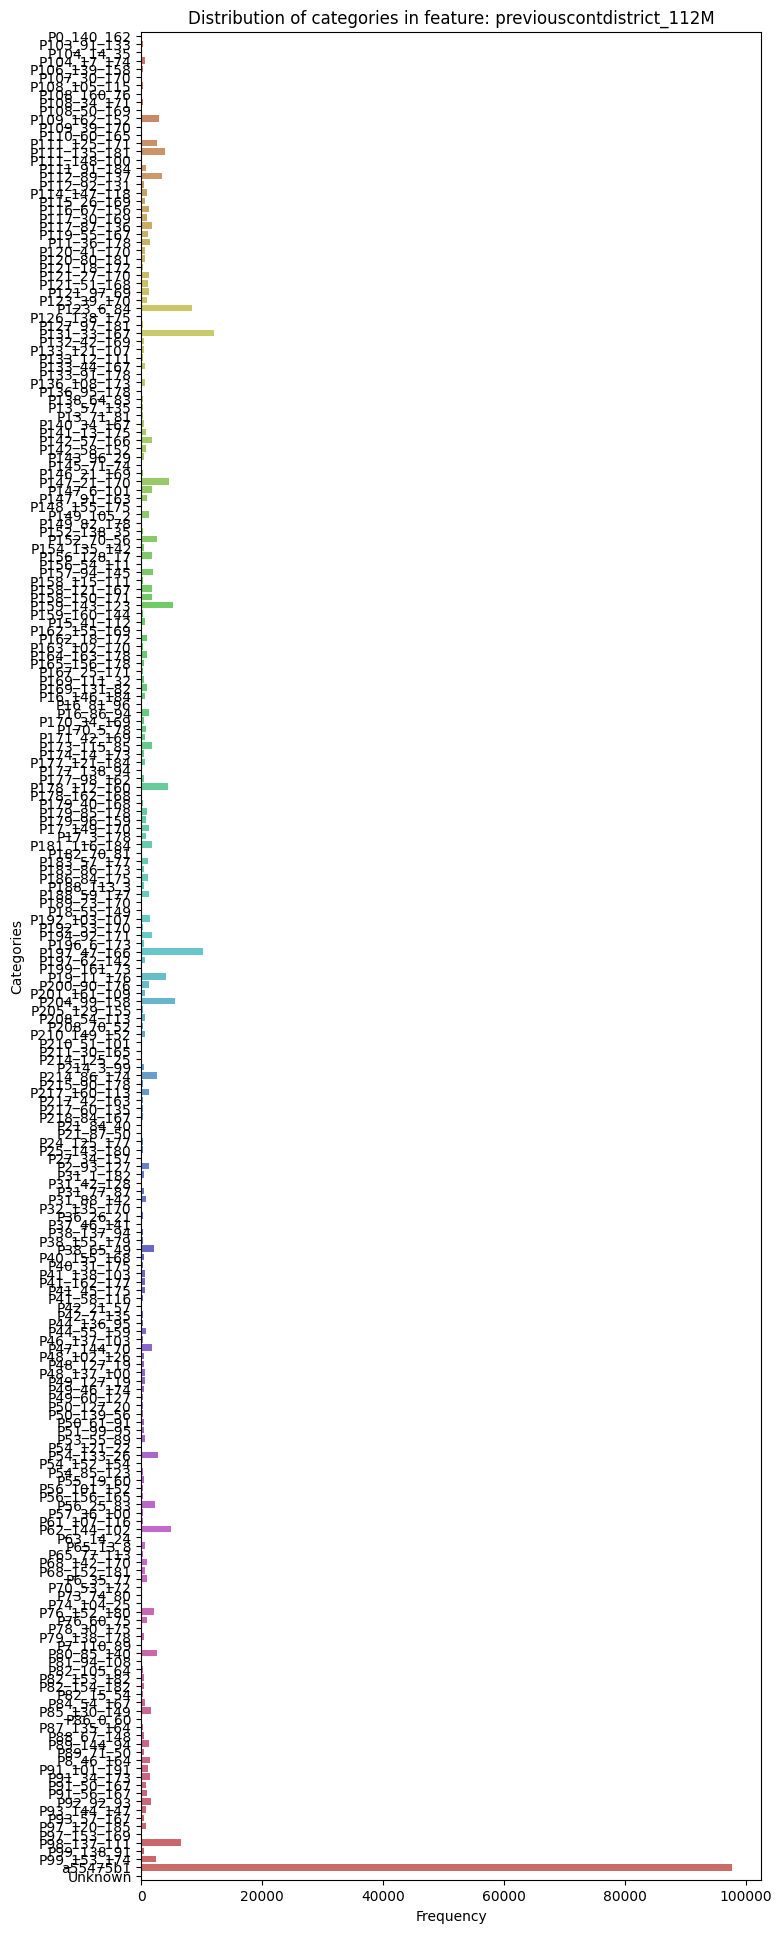

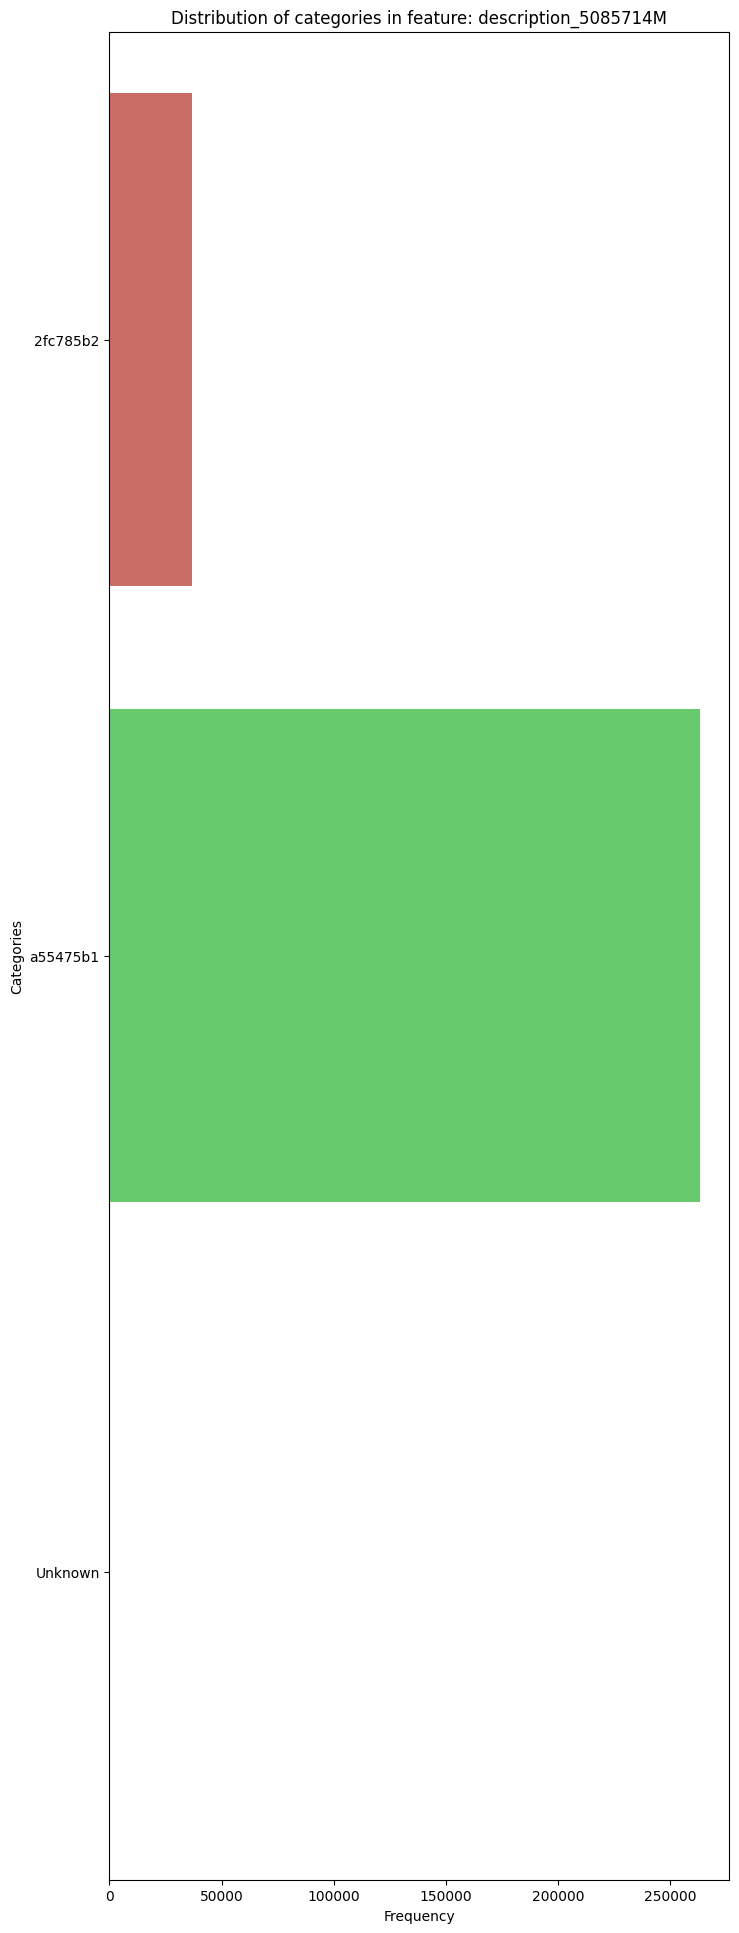

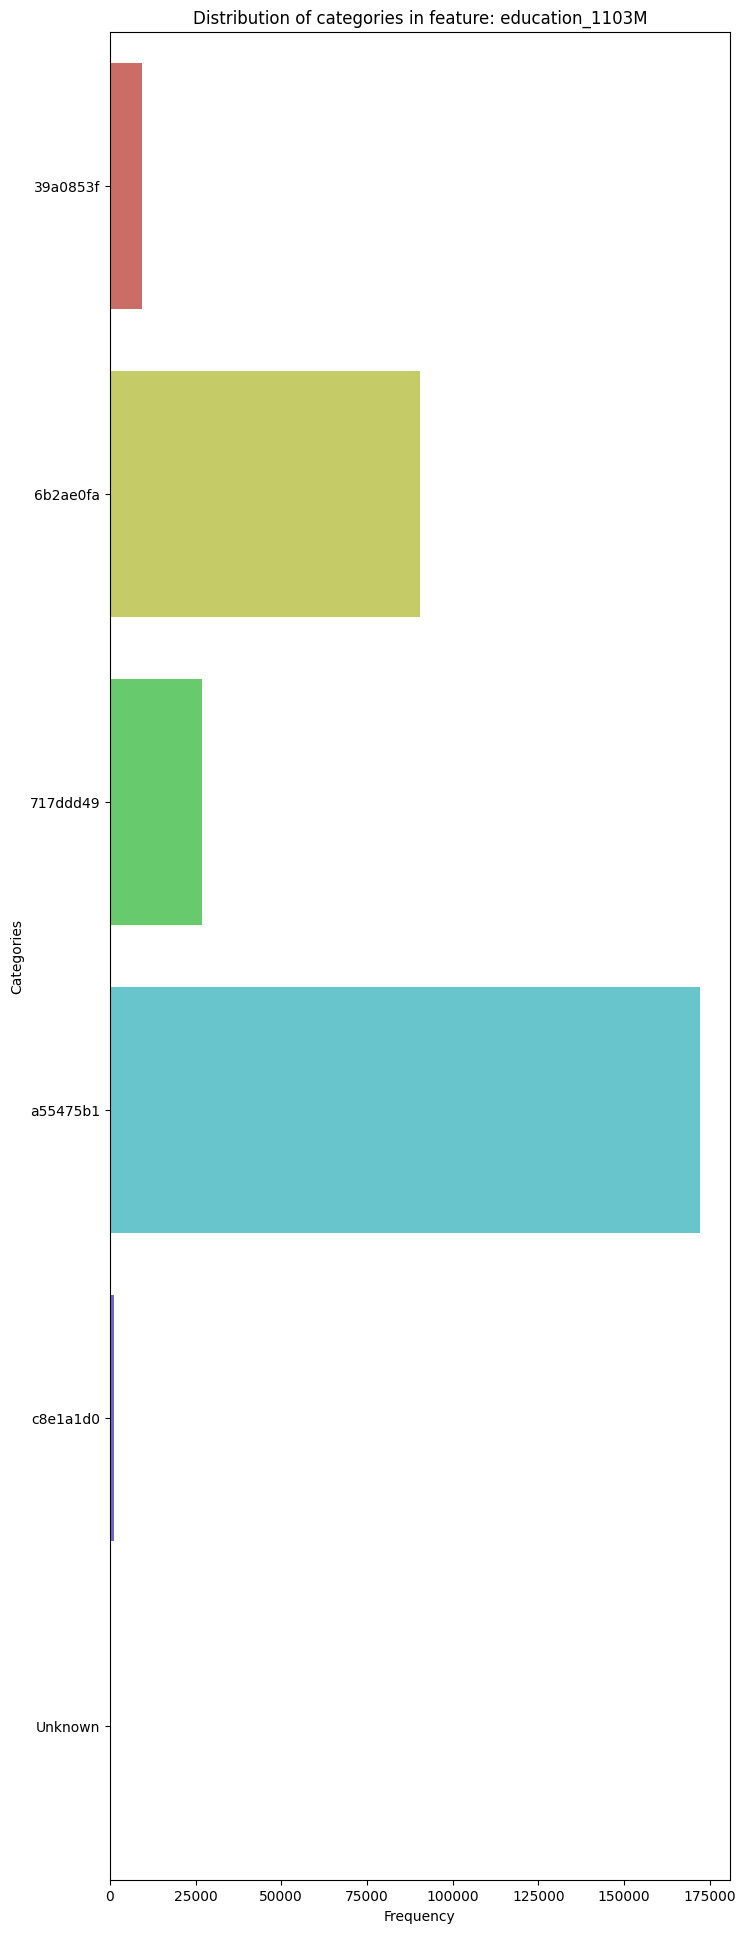

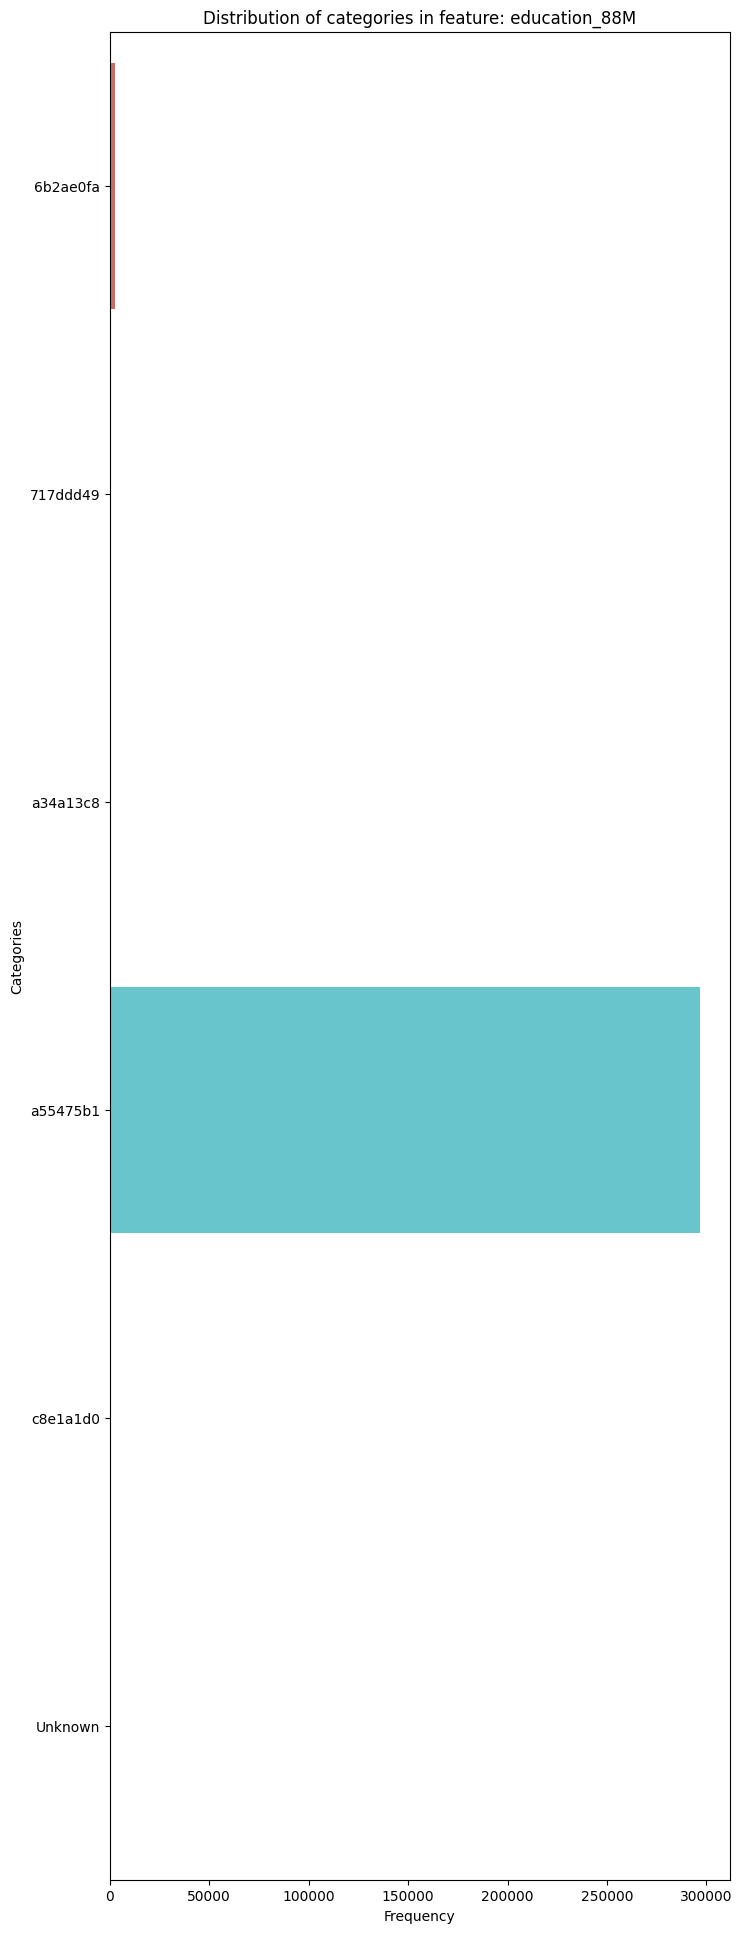

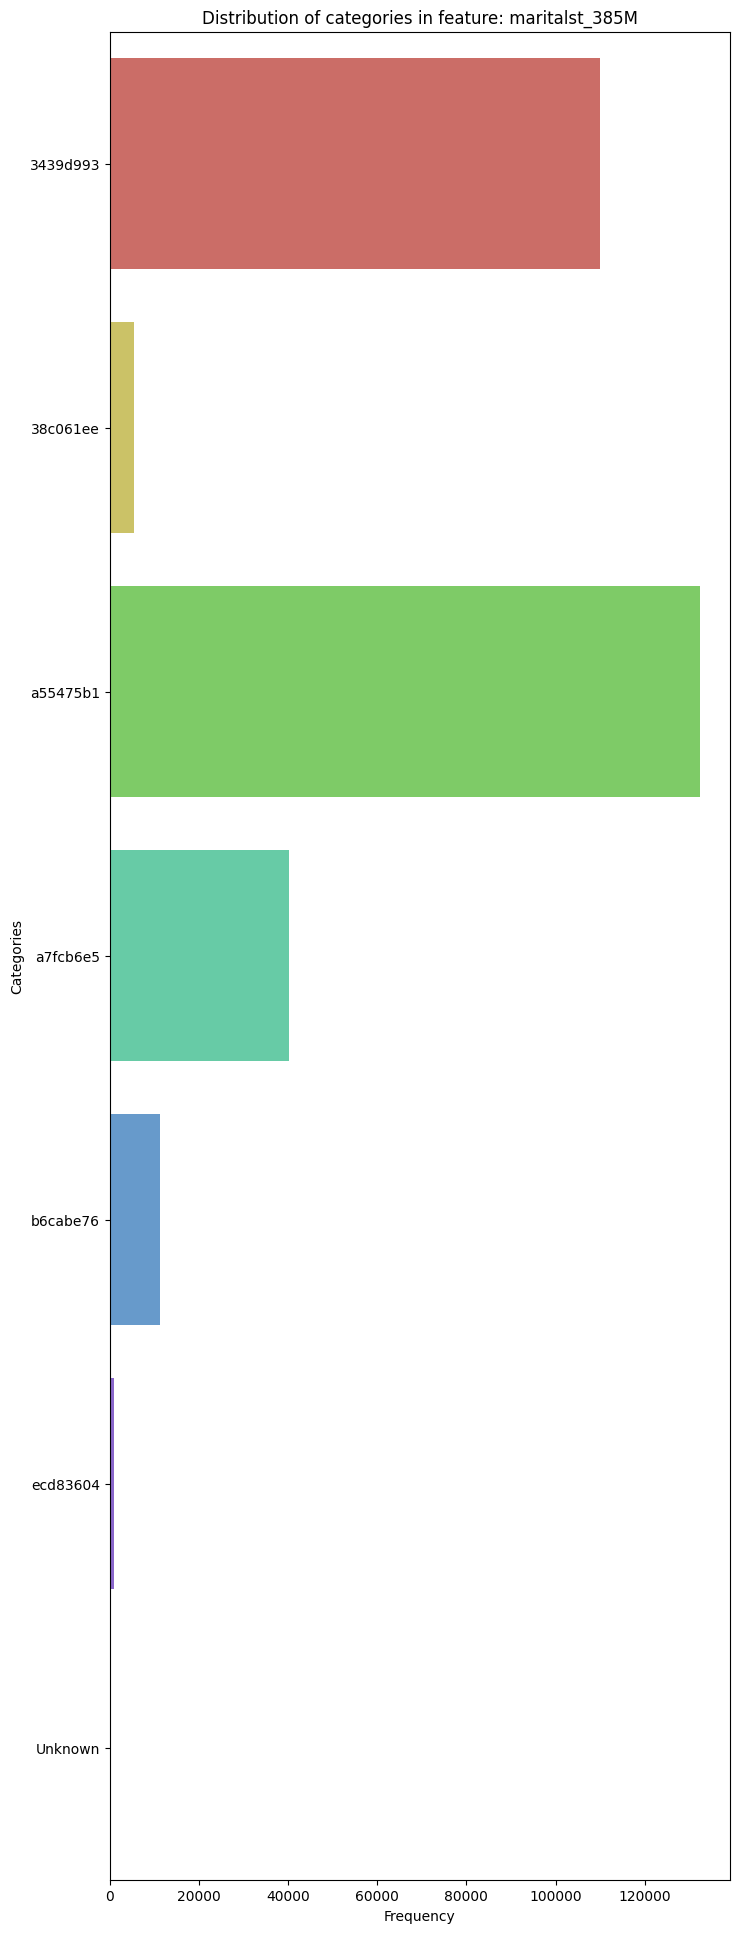

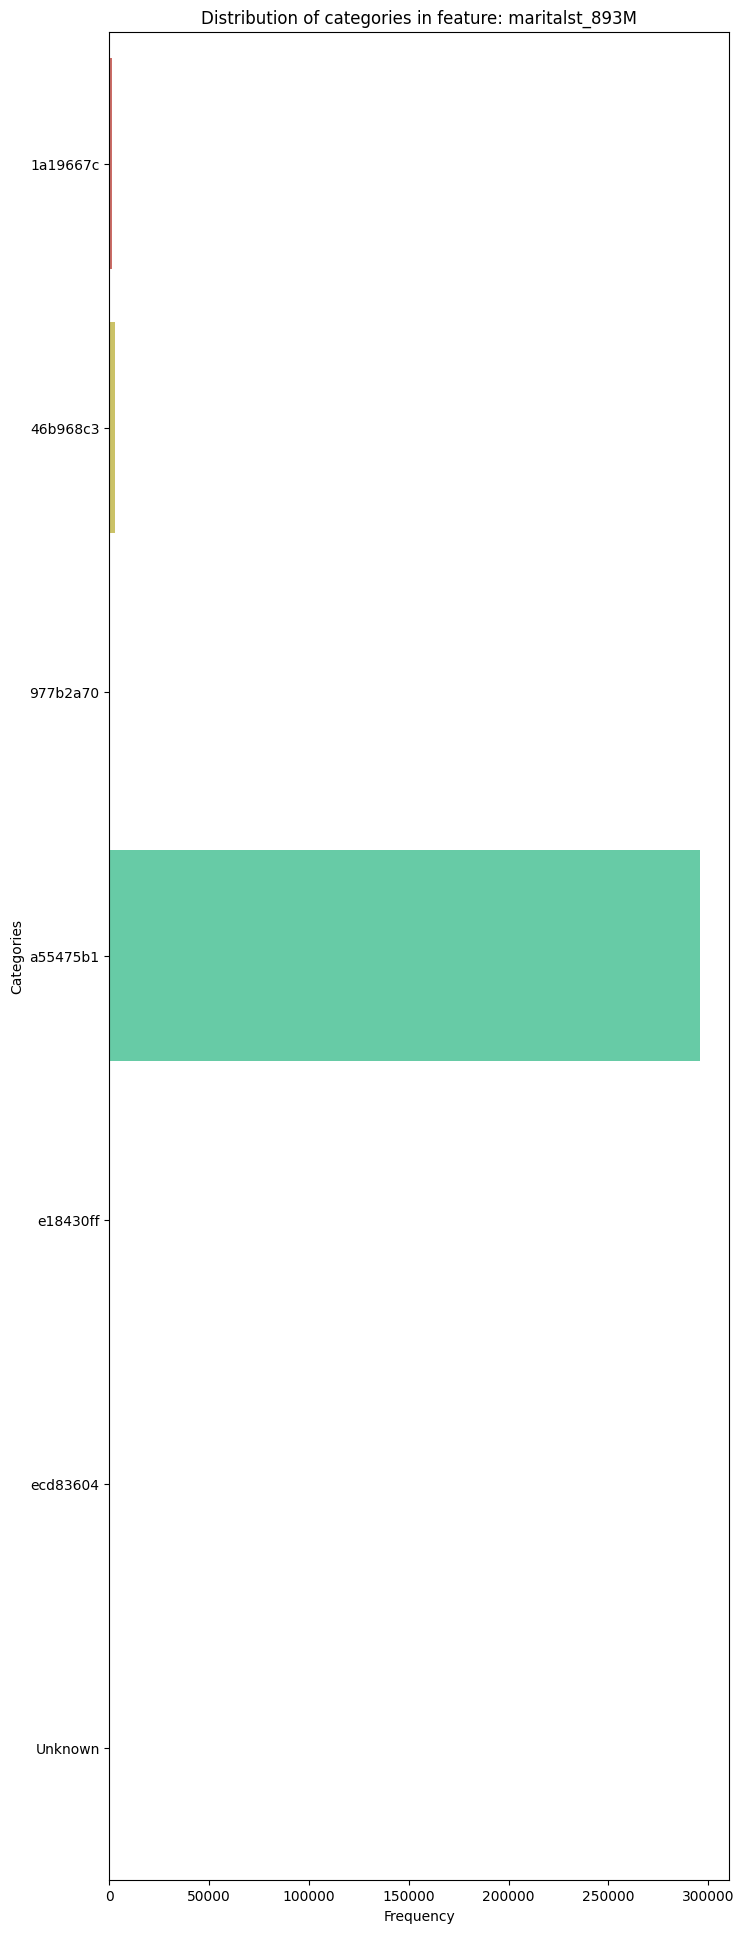

<Axes: xlabel='target', ylabel='Count'>

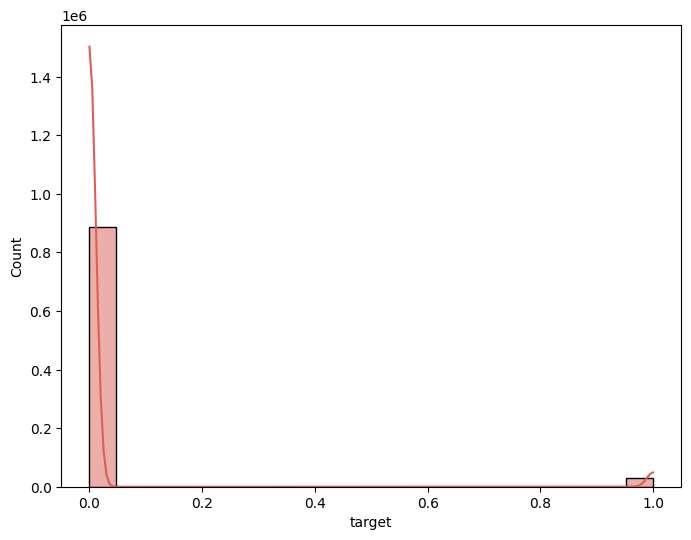

In [28]:
for col in X_train.select_dtypes(include=['category']):
    # Create a count plot with horizontal bars
    plt.figure(figsize=(8, 24))
    sns.countplot(y=col, data=df, palette=sns.color_palette("hls", len(df[col].unique())))
    plt.title(f"Distribution of categories in feature: {col}")
    plt.xlabel("Frequency")
    plt.ylabel("Categories")
    plt.show()


# Target variable visualization
plt.figure(figsize=(8, 6))
sns.histplot(data=y_train, kde=True, color=colors[0])

### Missing

In [27]:
print("Features with missing values:")
for feature, count in features_with_missing_values.items():
    print(f"{feature}: {count} missing values, which is {count/len(X_train):.2%} ")

Features with missing values:
amtinstpaidbefduel24m_4187115A: 336873 missing values, which is 36.78% 
annuitynextmonth_57A: 1 missing values, which is 0.00% 
avginstallast24m_3658937A: 374858 missing values, which is 40.92% 
avglnamtstart24m_4525187A: 818622 missing values, which is 89.37% 
avgoutstandbalancel6m_4187114A: 504619 missing values, which is 55.09% 
avgpmtlast12m_4525200A: 616373 missing values, which is 67.29% 
currdebt_22A: 1 missing values, which is 0.00% 
currdebtcredtyperange_828A: 1 missing values, which is 0.00% 
inittransactionamount_650A: 800636 missing values, which is 87.41% 
lastapprcredamount_781A: 265325 missing values, which is 28.97% 
lastotherinc_902A: 914113 missing values, which is 99.79% 
lastotherlnsexpense_631A: 914128 missing values, which is 99.80% 
lastrejectcredamount_222A: 461137 missing values, which is 50.34% 
maininc_215A: 306860 missing values, which is 33.50% 
maxannuity_159A: 183697 missing values, which is 20.05% 
maxannuity_4075009A: 87054

# One-Hot Encoding and Oversampling


In [3]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [29]:
data_pd1 = data.to_pandas()
fraud = data_pd1[data_pd1["target"] == 1]
normal = data_pd1[data_pd1["target"] == 0]

print(len(fraud),"\n", len(normal))

47994 
 1478665


# Feature Engineering 2

In [30]:
data_encoded = data_pd1.copy()
data_encoded.fillna(0, inplace=True)
data_encoded["date_decision"] = pd.to_datetime(data_encoded["date_decision"], format='%Y-%m-%d', errors='coerce').dt.year * 10000 + \
                                pd.to_datetime(data_encoded["date_decision"], format='%Y-%m-%d', errors='coerce').dt.month * 100 + \
                                pd.to_datetime(data_encoded["date_decision"], format='%Y-%m-%d', errors='coerce').dt.day

Checkpoint :)

In [55]:
# data_encoded.to_csv("data_encoded_saved_kaggle.csv", index=False)
data_encoded = pd.read_csv("/kaggle/input/data-encoded-saved-csv/data_encoded_saved.csv", low_memory=False)

In [45]:
dtypes = {55: 'object', 57: 'object'}  # Adjust based on actual types
data_encoded = pd.read_csv("data_encoded_saved_kaggle.csv", dtype=dtypes)

In [27]:
data_encoded.describe(include='all')

case_id  date_decision         MONTH      WEEK_NUM        target  \
count   1.526659e+06   1.526659e+06  1.526659e+06  1.526659e+06  1.526659e+06   
unique           NaN            NaN           NaN           NaN           NaN   
top              NaN            NaN           NaN           NaN           NaN   
freq             NaN            NaN           NaN           NaN           NaN   
mean    1.286077e+06   2.019364e+07  2.019363e+05  4.076904e+01  3.143728e-02   
std     7.189466e+05   4.473196e+03  4.473597e+01  2.379798e+01  1.744964e-01   
min     0.000000e+00   2.019010e+07  2.019010e+05  0.000000e+00  0.000000e+00   
25%     7.661975e+05   2.019061e+07  2.019060e+05  2.300000e+01  0.000000e+00   
50%     1.357358e+06   2.019101e+07  2.019100e+05  4.000000e+01  0.000000e+00   
75%     1.739022e+06   2.020013e+07  2.020010e+05  5.500000e+01  0.000000e+00   
max     2.703454e+06   2.020100e+07  2.020100e+05  9.100000e+01  1.000000e+00   

        amtinstpaidbefduel24m_4187115A  annuity_780A  annuitynextmonth_57A  \
count                     1.526659e+06  1.526659e+06          1.526659e+06   
unique                             NaN           NaN                   NaN   
top                                NaN           NaN                   NaN   
freq                               NaN           NaN                   NaN   
mean                      3.539083e+04  4.039207e+03          1.435771e+03   
std                       6.301964e+04  3.006608e+03          2.807019e+03   
min                       0.000000e+00  8.080000e+01          0.000000e+00   
25%                       0.000000e+00  1.967600e+03          0.000000e+00   
50%                       4.403400e+03  3.151800e+03          0.000000e+00   
75%                       4.442146e+04  5.231400e+03          2.029400e+03   
max                       1.408010e+06  1.060070e+05          8.750000e+04   

        avginstallast24m_3658937A  avglnamtstart24m_4525187A  ...  \
count                1.526659e+06               1.526659e+06  ...   
unique                        NaN                        NaN  ...   
top                           NaN                        NaN  ...   
freq                          NaN                        NaN  ...   
mean                 3.190670e+03               4.760072e+03  ...   
std                  5.679257e+03               2.010650e+04  ...   
min                  0.000000e+00               0.000000e+00  ...   
25%                  0.000000e+00               0.000000e+00  ...   
50%                  1.990400e+03               0.000000e+00  ...   
75%                  4.670200e+03               0.000000e+00  ...   
max                  4.961488e+05               5.135200e+05  ...   

        maritalst_893M  pmtaverage_3A  pmtaverage_4527227A  \
count          1526659   1.526659e+06         1.526659e+06   
unique               7            NaN                  NaN   
top           a55475b1            NaN                  NaN   
freq           1479303            NaN                  NaN   
mean               NaN   8.750043e+02         7.556620e+02   
std                NaN   3.206981e+03         3.041831e+03   
min                NaN   0.000000e+00         0.000000e+00   
25%                NaN   0.000000e+00         0.000000e+00   
50%                NaN   0.000000e+00         0.000000e+00   
75%                NaN   0.000000e+00         0.000000e+00   
max                NaN   1.452574e+05         2.058486e+05   

        pmtaverage_4955615A   pmtssum_45A  mainoccupationinc_384A_max  \
count          1.526659e+06  1.526659e+06                1.526659e+06   
unique                  NaN           NaN                         NaN   
top                     NaN           NaN                         NaN   
freq                    NaN           NaN                         NaN   
mean           8.306955e+02  4.951194e+03                5.770748e+04   
std            4.024339e+03  1.280464e+04                3.334830e+04   
min            0.0

In [57]:
data_encoded_copy1 = data_encoded.copy()
categorical_features = [col for col in data_encoded_copy1.columns if data_encoded_copy1[col].dtype == object]

In [58]:
data_encoded_copy1.head()

case_id  date_decision   MONTH  WEEK_NUM  target  \
0        0       20190103  201901         0       0   
1        1       20190103  201901         0       0   
2        2       20190104  201901         0       0   
3        3       20190103  201901         0       0   
4        4       20190104  201901         0       1   

   amtinstpaidbefduel24m_4187115A  annuity_780A  annuitynextmonth_57A  \
0                             0.0        1917.6                   0.0   
1                             0.0        3134.0                   0.0   
2                             0.0        4937.0                   0.0   
3                             0.0        4643.6                   0.0   
4                             0.0        3390.2                   0.0   

   avginstallast24m_3658937A  avglnamtstart24m_4525187A  ...  maritalst_893M  \
0                        0.0                        0.0  ...               0   
1                        0.0                        0.0  ...               0   
2                        0.0                        0.0  ...               0   
3                        0.0                        0.0  ...               0   
4                        0.0                        0.0  ...               0   

   pmtaverage_3A  pmtaverage_4527227A  pmtaverage_4955615A  pmtssum_45A  \
0            0.0                  0.0                  0.0          0.0   
1            0.0                  0.0                  0.0          0.0   
2            0.0                  0.0                  0.0          0.0   
3            0.0                  0.0                  0.0          0.0   
4            0.0                  0.0                  0.0          0.0   

   mainoccupationinc_384A_max  mainoccupationinc_384A_any_selfemployed  \
0                     10800.0                                    False   
1                     10000.0                                    False   
2                     14000.0                                    False   
3                     10000.0                                    False   
4                     24000.0                                    False   

   person_housetype pmts_pmtsoverdue_635A_max pmts_dpdvalue_108P_over31  
0                 0                       0.0                         0  
1                 0                       0.0                         0  
2                 0                       0.0                         0  
3                 0                       0.0                         0  
4                 0                       0.0                         0  

[5 rows x 58 columns]

In [37]:
data_encoded_copy1.describe(include='all')

case_id  date_decision         MONTH      WEEK_NUM        target  \
count   1.526659e+06   1.526659e+06  1.526659e+06  1.526659e+06  1.526659e+06   
unique           NaN            NaN           NaN           NaN           NaN   
top              NaN            NaN           NaN           NaN           NaN   
freq             NaN            NaN           NaN           NaN           NaN   
mean    1.286077e+06   2.019364e+07  2.019363e+05  4.076904e+01  3.143728e-02   
std     7.189466e+05   4.473196e+03  4.473597e+01  2.379798e+01  1.744964e-01   
min     0.000000e+00   2.019010e+07  2.019010e+05  0.000000e+00  0.000000e+00   
25%     7.661975e+05   2.019061e+07  2.019060e+05  2.300000e+01  0.000000e+00   
50%     1.357358e+06   2.019101e+07  2.019100e+05  4.000000e+01  0.000000e+00   
75%     1.739022e+06   2.020013e+07  2.020010e+05  5.500000e+01  0.000000e+00   
max     2.703454e+06   2.020100e+07  2.020100e+05  9.100000e+01  1.000000e+00   

        amtinstpaidbefduel24m_4187115A  annuity_780A  annuitynextmonth_57A  \
count                     1.526659e+06  1.526659e+06          1.526659e+06   
unique                             NaN           NaN                   NaN   
top                                NaN           NaN                   NaN   
freq                               NaN           NaN                   NaN   
mean                      3.539083e+04  4.039207e+03          1.435771e+03   
std                       6.301964e+04  3.006608e+03          2.807019e+03   
min                       0.000000e+00  8.080000e+01          0.000000e+00   
25%                       0.000000e+00  1.967600e+03          0.000000e+00   
50%                       4.403400e+03  3.151800e+03          0.000000e+00   
75%                       4.442146e+04  5.231400e+03          2.029400e+03   
max                       1.408010e+06  1.060070e+05          8.750000e+04   

        avginstallast24m_3658937A  avglnamtstart24m_4525187A  ...  \
count                1.526659e+06               1.526659e+06  ...   
unique                        NaN                        NaN  ...   
top                           NaN                        NaN  ...   
freq                          NaN                        NaN  ...   
mean                 3.190670e+03               4.760072e+03  ...   
std                  5.679257e+03               2.010650e+04  ...   
min                  0.000000e+00               0.000000e+00  ...   
25%                  0.000000e+00               0.000000e+00  ...   
50%                  1.990400e+03               0.000000e+00  ...   
75%                  4.670200e+03               0.000000e+00  ...   
max                  4.961488e+05               5.135200e+05  ...   

        maritalst_893M  pmtaverage_3A  pmtaverage_4527227A  \
count          1526659   1.526659e+06         1.526659e+06   
unique               7            NaN                  NaN   
top           a55475b1            NaN                  NaN   
freq           1479303            NaN                  NaN   
mean               NaN   8.750043e+02         7.556620e+02   
std                NaN   3.206981e+03         3.041831e+03   
min                NaN   0.000000e+00         0.000000e+00   
25%                NaN   0.000000e+00         0.000000e+00   
50%                NaN   0.000000e+00         0.000000e+00   
75%                NaN   0.000000e+00         0.000000e+00   
max                NaN   1.452574e+05         2.058486e+05   

        pmtaverage_4955615A   pmtssum_45A  mainoccupationinc_384A_max  \
count          1.526659e+06  1.526659e+06                1.526659e+06   
unique                  NaN           NaN                         NaN   
top                     NaN           NaN                         NaN   
freq                    NaN           NaN                         NaN   
mean           8.306955e+02  4.951194e+03                5.770748e+04   
std            4.024339e+03  1.280464e+04                3.334830e+04   
min            0.0

In [48]:
categorical_features

['lastapprcommoditycat_1041M',
 'lastapprcommoditytypec_5251766M',
 'lastcancelreason_561M',
 'lastrejectcommoditycat_161M',
 'lastrejectcommodtypec_5251769M',
 'lastrejectreason_759M',
 'lastrejectreasonclient_4145040M',
 'previouscontdistrict_112M',
 'description_5085714M',
 'education_1103M',
 'education_88M',
 'maritalst_385M',
 'maritalst_893M',
 'person_housetype',
 'pmts_dpdvalue_108P_over31']

In [ ]:
"""# Iterate through categorical features and perform one-hot encoding
for col in categorical_features[9:-2]:
    # Check if the feature has the expected data type (string)
    if data_encoded_copy[col].dtype == object:
        encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
        encoded_features = encoder.fit_transform(data_encoded_copy[[col]])  # Encode single feature

        # Add encoded features back to the DataFrame, dropping the original categorical feature
        data_encoded_copy.drop(col, axis=1, inplace=True)
        for i, new_col in enumerate(encoder.get_feature_names_out()):
            data_encoded_copy[new_col] = encoded_features[:, i]
    else:
        print(f"Warning: Skipping feature '{col}' because it's not a string (categorical).")

# Now your data_encoded DataFrame contains one-hot encoded features
print(data_encoded.head())
"""
### KEEPS CRASHING, PROBABLY BECAUSE IT IS MEMEORY INTENSIVE ###

## Using Concat to avoid crashing
""" 
encoded_data = pd.DataFrame()  # Initialize an empty DataFrame to store encoded features

for col in categorical_features:
    if data_encoded_copy[col].dtype == object:
        encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
        encoded_features = encoder.fit_transform(data_encoded_copy[[col]])
        encoded_data = pd.concat([encoded_data, pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())], axis=1)
    else:
        print(f"Warning: Skipping feature '{col}' because it's not a string (categorical).")

# Combine encoded features with numerical features (if any)
final_df = pd.concat([data_encoded_copy.drop(categorical_features, axis=1), encoded_data], axis=1)

print(final_df.head())
print(len(final_df.columns))

###### STILL CRASHING!! ####
"""

Performing Concatenations in batches to avoid crashing

In [21]:
print(encoded_features[:5])

  (0, 44)	1.0
  (1, 44)	1.0
  (2, 44)	1.0
  (3, 44)	1.0
  (4, 44)	1.0


In [ ]:
# # Identify potential categorical features by data type and unique values 
# potential_categorical = [col for col in data_encoded_copy.columns if data_encoded_copy[col].dtype == object]
# #  or data_encoded_copy[col].nunique() > 10]

# Define batch size
batch_size = 1 # crashing for 3

# Create an empty DataFrame to store encoded features
encoded_data = pd.DataFrame()
final_df = pd.DataFrame()
# Process features in batches
for i in range(0, len(categorical_features[:-2]), batch_size):
    features_to_encode = potential_categorical[i:i+batch_size]
    encoded_features_set = set()  # Reset encoded features set for each batch

    # Iterate through the batch and perform one-hot encoding
    for col in features_to_encode:
        if col not in encoded_features_set and data_encoded_copy1[col].dtype == object:
            print(col)
            encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore') # make sparse=True to save memory
            encoded_features = encoder.fit_transform(data_encoded_copy1[[col]])
            encoded_data = pd.concat([encoded_data, pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())], axis=1)
            encoded_features_set.add(col)
        else:
            print(f"Skipping feature '{col}' because it's already encoded or not a string (categorical).")

    # Combine encoded features with numerical features and update final_df
    final_df = pd.concat([final_df if any(final_df) else data_encoded_copy1.drop(potential_categorical, axis=1), encoded_data], axis=1)
    encoded_data = pd.DataFrame()  # Reset encoded_data for the next batch

# Tensorflow with batching for one-hot encoding

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

data_encoded = pd.read_csv("/kaggle/input/data-encoded-saved-csv/data_encoded_saved.csv")
data_encoded_copy = data_encoded.copy()

/tmp/ipykernel_42/2966538032.py:4: DtypeWarning: Columns (55,57) have mixed types. Specify dtype option on import or set low_memory=False.
  data_encoded = pd.read_csv("/kaggle/input/data-encoded-saved-csv/data_encoded_saved.csv")


In [2]:
import tensorflow as tf
from tensorflow_addons.utils import keras_utils 

# Identify potential categorical features (unchanged)
potential_categorical = [col for col in data_encoded_copy.columns if data_encoded_copy[col].dtype == object]
#  or data_encoded_copy[col].nunique() > 10]

# Define batch size (unchanged)
batch_size = 2

# Create empty DataFrames for encoded data and final result (unchanged)
encoded_data = pd.DataFrame()
final_df = pd.DataFrame()

# Process features in batches (with GPU utilization)
for i in range(0, len(potential_categorical[:-2]), batch_size):
    features_to_encode = potential_categorical[i:i+batch_size]
    encoded_features_set = set()

    # --- Correction: Convert categorical data to integers before moving to GPU ---
    data_batch_int = pd.get_dummies(data_encoded_copy[features_to_encode], columns=features_to_encode)
    data_batch_gpu = tf.convert_to_tensor(data_batch_int, dtype=tf.int64)

    with tf.device('/gpu:0'):
        for col in features_to_encode:
            if col not in encoded_features_set and data_encoded_copy[col].dtype == object:
                print(col)

                # # Use tf.one_hot directly on the GPU for efficiency
                # encoded_features = tf.one_hot(data_batch_gpu[:, col], depth=data_encoded_copy[col].nunique())

                # Move encoded features back to CPU and convert to DataFrame
                col_index = features_to_encode.index(col)  # Get the integer index of the column
                depth = data_encoded_copy[col].nunique()
                encoded_features = tf.one_hot(data_batch_gpu[:, col_index], depth=data_encoded_copy[col].nunique())

                # encoded_data = pd.concat([encoded_data, pd.DataFrame(encoded_features.numpy(), columns=encoder.get_feature_names_out())], axis=1)
                encoded_data = pd.concat([encoded_data, pd.DataFrame(encoded_features.numpy(), columns=[f"{col}_{i}" for i in range(depth)])], axis=1)
                encoded_features_set.add(col)
            else:
                print(f"Skipping feature '{col}' because it's already encoded or not a string (categorical).")

    # Combine encoded features with numerical features and update final_df (unchanged)
    final_df = pd.concat([final_df if any(final_df) else data_encoded_copy.drop(potential_categorical, axis=1), encoded_data], axis=1)
    encoded_data = pd.DataFrame()  # Reset encoded_data for the next batch

# Check the resulting DataFrame (unchanged)
print(final_df.head())

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


lastapprcommoditycat_1041M
lastapprcommoditytypec_5251766M
lastcancelreason_561M
lastrejectcommoditycat_161M
lastrejectcommodtypec_5251769M
lastrejectreason_759M
lastrejectreasonclient_4145040M
previouscontdistrict_112M
description_5085714M
education_1103M
education_88M
maritalst_385M
maritalst_893M
person_housetype
   case_id  date_decision   MONTH  WEEK_NUM  target  \
0        0       20190103  201901         0       0   
1        1       20190103  201901         0       0   
2        2       20190104  201901         0       0   
3        3       20190103  201901         0       0   
4        4       20190104  201901         0       1   

   amtinstpaidbefduel24m_4187115A  annuity_780A  annuitynextmonth_57A  \
0                             0.0        1917.6                   0.0   
1                             0.0        3134.0                   0.0   
2                             0.0        4937.0                   0.0   
3                             0.0        4643.6            

In [3]:
final_df.fillna(0, inplace=True)
final_df.head()

case_id  date_decision   MONTH  WEEK_NUM  target  \
0        0       20190103  201901         0       0   
1        1       20190103  201901         0       0   
2        2       20190104  201901         0       0   
3        3       20190103  201901         0       0   
4        4       20190104  201901         0       1   

   amtinstpaidbefduel24m_4187115A  annuity_780A  annuitynextmonth_57A  \
0                             0.0        1917.6                   0.0   
1                             0.0        3134.0                   0.0   
2                             0.0        4937.0                   0.0   
3                             0.0        4643.6                   0.0   
4                             0.0        3390.2                   0.0   

   avginstallast24m_3658937A  avglnamtstart24m_4525187A  ...  \
0                        0.0                        0.0  ...   
1                        0.0                        0.0  ...   
2                        0.0                        0.0  ...   
3                        0.0                        0.0  ...   
4                        0.0                        0.0  ...   

   maritalst_893M_5  maritalst_893M_6  person_housetype_0  person_housetype_1  \
0               0.0               0.0                 1.0                 0.0   
1               0.0               0.0                 1.0                 0.0   
2               0.0               0.0                 1.0                 0.0   
3               0.0               0.0                 1.0                 0.0   
4               0.0               0.0                 1.0                 0.0   

   person_housetype_2  person_housetype_3  person_housetype_4  \
0                 0.0                 0.0                 0.0   
1                 0.0                 0.0                 0.0   
2                 0.0                 0.0                 0.0   
3                 0.0                 0.0                 0.0   
4                 0.0                 0.0                 0.0   

   person_housetype_5  person_housetype_6  person_housetype_7  
0                 0.0                 0.0                 0.0  
1                 0.0                 0.0                 0.0  
2                 0.0                 0.0                 0.0  
3                 0.0                 0.0                 0.0  
4                 0.0                 0.0                 0.0  

[5 rows x 900 columns]

# Checkpoint 2 :')

In [8]:
final_df.to_csv("final_df_after_tf_ohc.csv")

In [5]:
# import pandas as pd
# final_df = pd.read_csv("/kaggle/working/final_df_after_tf_ohc.csv")
final_df.fillna(0, inplace=True)

case_id  date_decision   MONTH  WEEK_NUM  target  \
0              0       20190103  201901         0       0   
1              1       20190103  201901         0       0   
2              2       20190104  201901         0       0   
3              3       20190103  201901         0       0   
4              4       20190104  201901         0       1   
...          ...            ...     ...       ...     ...   
1526654  2703450       20201005  202010        91       0   
1526655  2703451       20201005  202010        91       0   
1526656  2703452       20201005  202010        91       0   
1526657  2703453       20201005  202010        91       0   
1526658  2703454       20201005  202010        91       0   

         amtinstpaidbefduel24m_4187115A  annuity_780A  annuitynextmonth_57A  \
0                                  0.00     1917.6000                   0.0   
1                                  0.00     3134.0000                   0.0   
2                                  0.00     4937.0000                   0.0   
3                                  0.00     4643.6000                   0.0   
4                                  0.00     3390.2000                   0.0   
...                                 ...           ...                   ...   
1526654                       176561.36     3675.4001                   0.0   
1526655                       301276.47     7088.6000                6191.6   
1526656                        14232.40     7788.8003                   0.0   
1526657                       197371.58     1195.4000                2827.2   
1526658                        82949.60     4533.8003                2986.8   

         avginstallast24m_3658937A  avglnamtstart24m_4525187A  ...  \
0                           0.0000                        0.0  ...   
1                           0.0000                        0.0  ...   
2                           0.0000                        0.0  ...   
3                           0.0000                        0.0  ...   
4                           0.0000                        0.0  ...   
...                            ...                        ...  ...   
1526654                  7356.8003                        0.0  ...   
1526655                 12553.2000                        0.0  ...   
1526656                  2662.4001                        0.0  ...   
1526657                  8212.6010                        0.0  ...   
1526658                  6405.4000                    15998.0  ...   

         maritalst_893M_5  maritalst_893M_6  person_housetype_0  \
0                     0.0               0.0                 1.0   
1                     0.0               0.0                 1.0   
2                     0.0               0.0                 1.0   
3                     0.0               0.0                 1.0   
4                     0.0               0.0                 1.0   
...                   ...               ...                 ...   
1526654               0.0               0.0                 1.0   
1526655               0.0               0.0                 1.0   
1526656               0.0               0.0                 1.0   
1526657               0.0               0.0                 1.0   
1526658               0.0               0.0                 1.0   

         person_housetype_1  person_housetype_2  person_housetype_3  \
0                       0.0                 0.0                 0.0   
1                       0.0                 0.0                 0.0   
2                       0.0                 0.0                 0.0   
3                       0.0                 0.0                 0.0   
4                       0.0                 0.0                 0.0   
...                     ...                 ...                 ...   
1526654                 0.0                 0.0                 0.0   
1526655                 0.0                 0.0                 0.0   
1526656                 0.0               

Read 5.6 GB csv file generated, chunkwise, using dask

In [2]:
# # import pandas as pd
# # final_df = pd.read_csv("/content/drive/MyDrive/final_df_after_tf_ohc.csv")
# import dask.dataframe as dd

# # Replace with your actual file path
# filepath = "/kaggle/working/final_df_after_tf_ohc.csv"

# # Define chunk size (adjust based on available memory)
# chunksize = 1000  # Number of rows per chunk

# # Read the file in chunks
# # Create a Dask DataFrame by defining chunks manually
# ddf = dd.read_csv(filepath, blocksize=chunksize * 40)  # Adjust blocksize for optimal performance

# # Collect the results and create the final DataFrame
# final_df = ddf.compute()

KeyboardInterrupt: 

In [ ]:
# import pandas as pd
# import logging

# def read_csv_chunks(filepath, chunksize=10000):
#   """Reads a large CSV file in chunks and returns a final DataFrame with logging.

#   Args:
#     filepath: Path to the CSV file.
#     chunksize: Number of rows to read in each chunk.

#   Returns:
#     A final DataFrame containing all data from the file.
#   """
#   chunks = []
#   processed_lines = 0
#   total_lines = sum(1 for _ in open(filepath, 'r'))  # Count total lines (excluding header)
#   print(f"Total lines to process: {total_lines}")

#   with open(filepath, 'r') as f:
#     # Skip header row if present
#     header = f.readline()
#     if header:
#       columns = header.strip().split(',')
    
#     while True:
#       chunk = []
#       for _ in range(chunksize):
#         line = f.readline()
#         if not line:
#           break
#         processed_lines += 1
#         chunk.append(line.strip().split(','))
#       # Append chunk to list and log progress
#       if chunk:
#         chunks.append(pd.DataFrame(chunk, columns=columns))
#         print(f"Processed {processed_lines} lines ({processed_lines/total_lines:.2%})")
#       else:
#         break

#   # Concatenate chunks into final DataFrame
#   final_df = pd.concat(chunks, ignore_index=True)
#   return final_df

# filepath = "/kaggle/working/final_df_after_tf_ohc.csv"
# chunksize = 50 # Adjust based on available memory

# logging.basicConfig(level=logging.INFO)  # Configure logging to show info messages

# final_df = read_csv_chunks(filepath, chunksize)

In [6]:
from sklearn.model_selection import train_test_split
# X = final_df.drop("target", axis=1)
y = final_df["target"]
X = final_df.loc[:, final_df.columns != "target"]

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Print the shapes of the split data
# print("X_train shape:", X_train.shape)
# print("X_test shape:", X_test.shape)
# print("y_train shape:", y_train.shape)
# print("y_test shape:", y_test.shape)

In [12]:
X.shape

NameError: name 'X' is not defined

# Oversampling underrepresented targets

In [9]:
def oversample_chunk(X_chunk, y_chunk):
    """Oversamples a single chunk of data using RandomOverSampler."""
    os = RandomOverSampler()
    X_res_chunk, y_res_chunk = os.fit_resample(X_chunk, y_chunk)
    return X_res_chunk, y_res_chunk

In [10]:
import dask.dataframe as dd
from imblearn.over_sampling import RandomOverSampler


In [ ]:
X_dask = dd.from_pandas(X, npartitions=2)  # Adjust npartitions based on your system
y_dask = dd.from_pandas(y, npartitions=2)


In [4]:
target_col_index= final_df.columns.get_loc("target")
target_col_index

4

In [5]:
X_1 = final_df.iloc[: 381663, :target_col_index] + final_df.iloc[: 381663, target_col_index + 1:]
y_1 = final_df["target"][:381663]

In [6]:
X_1.fillna(0, inplace=True)

In [8]:
from imblearn.over_sampling import RandomOverSampler
os = RandomOverSampler()

In [9]:
X_res_1, y_res_1 = os.fit_resample(X_1, y_1)

In [33]:
# (y_res_1 == 0).sum() 369857
(y_res_1 == 1).sum() 369857

369857

In [12]:
X_1.head()

MONTH  WEEK_NUM  amtinstpaidbefduel24m_4187115A  annuity_780A  \
0    0.0       0.0                             0.0           0.0   
1    0.0       0.0                             0.0           0.0   
2    0.0       0.0                             0.0           0.0   
3    0.0       0.0                             0.0           0.0   
4    0.0       0.0                             0.0           0.0   

   annuitynextmonth_57A  avginstallast24m_3658937A  avglnamtstart24m_4525187A  \
0                   0.0                        0.0                        0.0   
1                   0.0                        0.0                        0.0   
2                   0.0                        0.0                        0.0   
3                   0.0                        0.0                        0.0   
4                   0.0                        0.0                        0.0   

   avgoutstandbalancel6m_4187114A  avgpmtlast12m_4525200A  case_id  ...  \
0                             0.0                     0.0      0.0  ...   
1                             0.0                     0.0      0.0  ...   
2                             0.0                     0.0      0.0  ...   
3                             0.0                     0.0      0.0  ...   
4                             0.0                     0.0      0.0  ...   

   previouscontdistrict_112M_96  previouscontdistrict_112M_97  \
0                           0.0                           0.0   
1                           0.0                           0.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           0.0                           0.0   

   previouscontdistrict_112M_98  previouscontdistrict_112M_99  price_1097A  \
0                           0.0                           0.0          0.0   
1                           0.0                           0.0          0.0   
2                           0.0                           0.0          0.0   
3                           0.0                           0.0          0.0   
4                           0.0                           0.0          0.0   

   sumoutstandtotal_3546847A  sumoutstandtotalest_4493215A  totaldebt_9A  \
0                        0.0                           0.0           0.0   
1                        0.0                           0.0           0.0   
2                        0.0                           0.0           0.0   
3                        0.0                           0.0           0.0   
4                        0.0                           0.0           0.0   

   totalsettled_863A  totinstallast1m_4525188A  
0                0.0                       0.0  
1                0.0                       0.0  
2                0.0                       0.0  
3                0.0                       0.0  
4                0.0                       0.0  

[5 rows x 899 columns]

In [10]:
X_res_1.to_csv("X_res_1.csv")
y_res_1.to_csv("y_res_1.csv")

In [11]:
X_2 = final_df.iloc[381664: 763328, :target_col_index] + final_df.iloc[381664: 763328, target_col_index + 1:]
y_2 = final_df["target"][381664: 763328]

In [ ]:
X_2 = final_df.iloc[381664: 763328, :target_col_index] + final_df.iloc[381664: 763328, target_col_index + 1:]
y_2 = final_df["target"][381664: 763328]

In [74]:
%whos

Variable           Type         Data/Info
-----------------------------------------
X_2                DataFrame            MONTH  WEEK_NUM  <...>81664 rows x 899 columns]
X_res_1            DataFrame            MONTH  WEEK_NUM  <...>39714 rows x 899 columns]
col_index          int          1
final_df           DataFrame             case_id  date_de<...>26659 rows x 900 columns]
gc                 module       <module 'gc' (built-in)>
pd                 module       <module 'pandas' from '/o<...>ages/pandas/__init__.py'>
target_col_index   int          4
y_2                Series       381664    0\n381665    0\<...>gth: 381664, dtype: int64
y_res_1            Series       0         0\n1         0\<...>gth: 739714, dtype: int64


In [84]:
import gc
gc.collect()

0

In [71]:
del y_1

In [25]:
X_2.fillna(0, inplace=True)

In [58]:
X_2.head()

MONTH  WEEK_NUM  amtinstpaidbefduel24m_4187115A  annuity_780A  \
381664    0.0       0.0                             0.0           0.0   
381665    0.0       0.0                             0.0           0.0   
381666    0.0       0.0                             0.0           0.0   
381667    0.0       0.0                             0.0           0.0   
381668    0.0       0.0                             0.0           0.0   

        annuitynextmonth_57A  avginstallast24m_3658937A  \
381664                   0.0                        0.0   
381665                   0.0                        0.0   
381666                   0.0                        0.0   
381667                   0.0                        0.0   
381668                   0.0                        0.0   

        avglnamtstart24m_4525187A  avgoutstandbalancel6m_4187114A  \
381664                        0.0                             0.0   
381665                        0.0                             0.0   
381666                        0.0                             0.0   
381667                        0.0                             0.0   
381668                        0.0                             0.0   

        avgpmtlast12m_4525200A  case_id  ...  previouscontdistrict_112M_96  \
381664                     0.0      0.0  ...                           0.0   
381665                     0.0      0.0  ...                           0.0   
381666                     0.0      0.0  ...                           0.0   
381667                     0.0      0.0  ...                           0.0   
381668                     0.0      0.0  ...                           0.0   

        previouscontdistrict_112M_97  previouscontdistrict_112M_98  \
381664                           0.0                           0.0   
381665                           0.0                           0.0   
381666                           0.0                           0.0   
381667                           0.0                           0.0   
381668                           0.0                           0.0   

        previouscontdistrict_112M_99  price_1097A  sumoutstandtotal_3546847A  \
381664                           0.0          0.0                        0.0   
381665                           0.0          0.0                        0.0   
381666                           0.0          0.0                        0.0   
381667                           0.0          0.0                        0.0   
381668                           0.0          0.0                        0.0   

        sumoutstandtotalest_4493215A  totaldebt_9A  totalsettled_863A  \
381664                           0.0           0.0                0.0   
381665                           0.0           0.0                0.0   
381666                           0.0           0.0                0.0   
381667                           0.0           0.0                0.0   
381668                           0.0           0.0                0.0   

        totinstallast1m_4525188A  
381664                       0.0  
381665                       0.0  
381666                       0.0  
381667                       0.0  
381668                       0.0  

[5 rows x 899 columns]

In [86]:
X_2.to_csv("X_2.csv")
y_2.to_csv("y_2.csv") 

In [85]:
del y_res_2

NameError: name 'y_res_2' is not defined

In [80]:
X_3 = final_df.iloc[763328: 1144992, :target_col_index] + final_df.iloc[763328: 1144992, target_col_index + 1:]
y_3 = final_df["target"][763328: 1144992]

In [81]:
X_3.fillna(0, inplace=True)

In [87]:
X_3.to_csv("X_3.csv")
y_3.to_csv("y_3.csv")

In [88]:
X_4 = final_df.iloc[1144992: , :target_col_index] + final_df.iloc[1144992: , target_col_index + 1:]
y_4 = final_df["target"][1144992: ]

In [89]:
X_4.fillna(0, inplace=True)

In [90]:
X_4

MONTH  WEEK_NUM  amtinstpaidbefduel24m_4187115A  annuity_780A  \
1144992    0.0       0.0                             0.0           0.0   
1144993    0.0       0.0                             0.0           0.0   
1144994    0.0       0.0                             0.0           0.0   
1144995    0.0       0.0                             0.0           0.0   
1144996    0.0       0.0                             0.0           0.0   
...        ...       ...                             ...           ...   
1526654    0.0       0.0                             0.0           0.0   
1526655    0.0       0.0                             0.0           0.0   
1526656    0.0       0.0                             0.0           0.0   
1526657    0.0       0.0                             0.0           0.0   
1526658    0.0       0.0                             0.0           0.0   

         annuitynextmonth_57A  avginstallast24m_3658937A  \
1144992                   0.0                        0.0   
1144993                   0.0                        0.0   
1144994                   0.0                        0.0   
1144995                   0.0                        0.0   
1144996                   0.0                        0.0   
...                       ...                        ...   
1526654                   0.0                        0.0   
1526655                   0.0                        0.0   
1526656                   0.0                        0.0   
1526657                   0.0                        0.0   
1526658                   0.0                        0.0   

         avglnamtstart24m_4525187A  avgoutstandbalancel6m_4187114A  \
1144992                        0.0                             0.0   
1144993                        0.0                             0.0   
1144994                        0.0                             0.0   
1144995                        0.0                             0.0   
1144996                        0.0                             0.0   
...                            ...                             ...   
1526654                        0.0                             0.0   
1526655                        0.0                             0.0   
1526656                        0.0                             0.0   
1526657                        0.0                             0.0   
1526658                        0.0                             0.0   

         avgpmtlast12m_4525200A  case_id  ...  previouscontdistrict_112M_96  \
1144992                     0.0      0.0  ...                           0.0   
1144993                     0.0      0.0  ...                           0.0   
1144994                     0.0      0.0  ...                           0.0   
1144995                     0.0      0.0  ...                           0.0   
1144996                     0.0      0.0  ...                           0.0   
...                         ...      ...  ...                           ...   
1526654                     0.0      0.0  ...                           0.0   
1526655                     0.0      0.0  ...                           0.0   
1526656                     0.0      0.0  ...                           0.0   
1526657                     0.0      0.0  ...                           0.0   
1526658                     0.0      0.0  ...                           0.0   

         previouscontdistrict_112M_97  previouscontdistrict_112M_98  \
1144992                           0.0                           0.0   
1144993                           0.0                           0.0   
1144994                           0.0                           0.0   
1144995                           0.0                           0.0   
1144996                           0.0                           0.0   
...                               ...                           ...   
1526654                           0.0                           0.0   
1526655                           0.0    

In [91]:
X_4.to_csv("X_4.csv")
y_4.to_csv("y_4.csv")

In [75]:
from imblearn.combine import SMOTETomek
os_smote = SMOTETomek(random_state=42)

In [76]:
X_res_2, y_res_2 = os_smote.fit_resample(X_2, y_2)

KeyboardInterrupt: 

In [ ]:
X_res_2.to_csv("X_res_2.csv")
y_res_2.to_csv("y_res_2.csv")

In [53]:
number_of_zeros = (y_res_1 == 0).sum()
number_of_zeros

369857

In [54]:
number_of_ones = (y_res_1 == 1).sum()
number_of_ones

369857

### 

BALANCED DATASET (with synthetic oversampling)

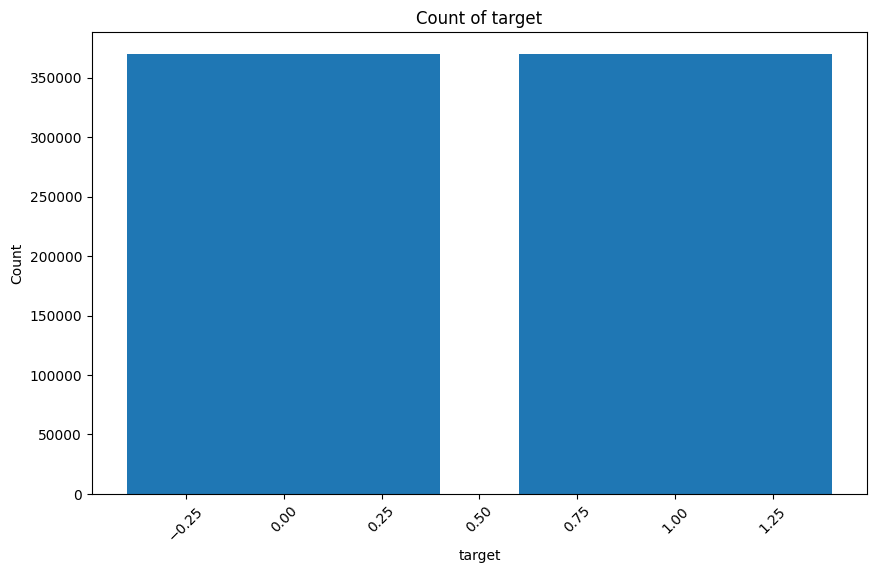

In [102]:
df_train = pd.concat([X_res_1, y_res_1], axis=1)
plot_count(df_train, ["target"])

## Training LightGBM

Minimal example of LightGBM training is shown below.

In [ ]:
import pandas as pd

X_res_1 = pd.read_csv("/kaggle/working/X_res_1.csv")
y_res_1 = pd.read_csv("/kaggle/working/y_res_1.csv")
y_2 = pd.read_csv("/kaggle/working/y_2.csv")
X_2 = pd.read_csv("/kaggle/working/X_2.csv")


In [ ]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 3,
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "n_estimators": 1000,
    "verbose": -1,
}

gbm = lgb.train(
    params,
    lgb_train,
    valid_sets=lgb_valid,
    callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10)]
)

Evaluation with AUC and then comparison with the stability metric is shown below.

In [ ]:
for base, X in [(base_train, X_train), (base_valid, X_valid), (base_test, X_test)]:
    y_pred = gbm.predict(X, num_iteration=gbm.best_iteration)
    base["score"] = y_pred

print(f'The AUC score on the train set is: {roc_auc_score(base_train["target"], base_train["score"])}') 
print(f'The AUC score on the valid set is: {roc_auc_score(base_valid["target"], base_valid["score"])}') 
print(f'The AUC score on the test set is: {roc_auc_score(base_test["target"], base_test["score"])}')  

In [ ]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()
    
    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

stability_score_train = gini_stability(base_train)
stability_score_valid = gini_stability(base_valid)
stability_score_test = gini_stability(base_test)

print(f'The stability score on the train set is: {stability_score_train}') 
print(f'The stability score on the valid set is: {stability_score_valid}') 
print(f'The stability score on the test set is: {stability_score_test}')  

## Submission

Scoring the submission dataset is below, we need to take care of new categories. Then we save the score as a last step. 

In [ ]:
X_submission = data_submission[cols_pred].to_pandas()
X_submission = convert_strings(X_submission)
categorical_cols = X_train.select_dtypes(include=['category']).columns

for col in categorical_cols:
    train_categories = set(X_train[col].cat.categories)
    submission_categories = set(X_submission[col].cat.categories)
    new_categories = submission_categories - train_categories
    X_submission.loc[X_submission[col].isin(new_categories), col] = "Unknown"
    new_dtype = pd.CategoricalDtype(categories=train_categories, ordered=True)
    X_train[col] = X_train[col].astype(new_dtype)
    X_submission[col] = X_submission[col].astype(new_dtype)

y_submission_pred = gbm.predict(X_submission, num_iteration=gbm.best_iteration)

In [ ]:
submission = pd.DataFrame({
    "case_id": data_submission["case_id"].to_numpy(),
    "score": y_submission_pred
}).set_index('case_id')
submission.to_csv("./submission.csv")